In [487]:
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.transforms.functional import to_tensor, to_pil_image
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from tqdm import tqdm

In [595]:
def normalize(image):
    return image


def resize(image):
    im = torch.zeros(1, 32, 32)
    im[:, 2:30, 2:30] = image
    return im

In [596]:
train_dataset = MNIST(root="data", download=True, transform=Compose([ToTensor(), normalize, resize]))
train_data = DataLoader(train_dataset, batch_size=32)

In [606]:
image, label = train_dataset[10]

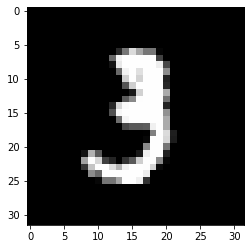

In [607]:
plt.imshow(image.numpy()[0], cmap="gray", vmin=0, vmax=1)
plt.show()

In [665]:
class PCNet1(nn.Module):
    def __init__(self, num_channels=1, input_size=(28, 28), num_iter=4):
        super(PCNet1, self).__init__()
        self.num_iter = num_iter
        self.input_size = input_size
        
        self.conv1 = nn.Conv2d(num_channels, 16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1)
        
        self.fc1 = nn.Linear(26 * 26 * 32, 128) # Lose structure here
        self.fc2 = nn.Linear(128, 26 * 26 * 32)
        
        #self.latent = nn.Conv2d(32, 32, kernel_size=5)
        
        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=5, stride=1)
        self.deconv2 = nn.ConvTranspose2d(16, num_channels, kernel_size=3, stride=1)
        
    def forward(self, x1):
        # Easy way to construct error units with correct sizes.
        with torch.no_grad():
            x1_pred = torch.zeros_like(x1)
            x2_pred = self.conv1(x1_pred)
            x3_pred = self.conv2(x2_pred)
            x4_pred = self.fc1(x3_pred.flatten(start_dim=1))
        
        # Rollout
        x1_preds = [x1_pred.clone()] # Store history of predictions
        
        for i in range(self.num_iter):
            # Bottom-up signal is inhibited by top-down
            e1 = F.relu(x1 - x1_pred) 
            x2 = self.conv1(e1)
            e2 = F.relu(x2 - x2_pred)
            x3 = self.conv2(e2)
            e3 = F.relu(x3 - x3_pred)
            
            x4 = self.fc1(e3.flatten(start_dim=1))
            x4_pred = F.relu(x4 - x4_pred) # This just seems to be alternating? Maybe add some decay?
            
            # Top-down
            e3_pred = F.relu(x4_pred - x4)
            x3_pred = self.fc2(e3_pred).view(x3.shape)
            e2_pred = F.relu(x3_pred - x3)
            x2_pred = self.deconv1(e2_pred)
            e1_pred = F.relu(x2_pred - x2)
            x1_pred = self.deconv2(e1_pred)
            
            x1_preds.append(x1_pred.clone())
            
        return x1_pred, x1_preds # Return predicted input along with its history.

In [699]:
class PCNet(nn.Module):
    """
        Changes from original:
            - Removed inhibation of top-down signal.
            #- Remember latent over time steps.
    """
    def __init__(self, num_channels=1, input_size=(28, 28), num_iter=2):
        super(PCNet, self).__init__()
        self.num_iter = num_iter
        self.input_size = input_size
        
        self.conv1 = nn.Conv2d(num_channels, 16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1)
        
        self.fc1 = nn.Linear(26 * 26 * 32, 128) # Lose structure here
        self.fc2 = nn.Linear(128, 26 * 26 * 32)
        
        #self.latent = nn.Conv2d(32, 32, kernel_size=5)
        
        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=5, stride=1)
        self.deconv2 = nn.ConvTranspose2d(16, num_channels, kernel_size=3, stride=1)
        
    def forward(self, x1):
        # Easy way to construct error units with correct sizes.
        with torch.no_grad():
            x1_pred = torch.zeros_like(x1)
            x2_pred = self.conv1(x1_pred)
            x3_pred = self.conv2(x2_pred)
            latent = self.fc1(x3_pred.flatten(start_dim=1))
        
        # Rollout
        x1_preds = [] # Store history of predictions
        
        for i in range(self.num_iter):
            # Bottom-up signal is inhibited by top-down
            e1 = F.relu(x1 - x1_pred) 
            x2 = self.conv1(e1)
            e2 = F.relu(x2 - x2_pred)
            x3 = self.conv2(e2)
            e3 = F.relu(x3 - x3_pred)
            
            x4 = self.fc1(e3.flatten(start_dim=1))
            latent = 0.5 * latent + 0.5 * F.relu(x4 - latent) # This just seems to be alternating? Maybe add some decay?
            
            # Top-down
            x3_pred = F.relu(self.fc2(latent).view(x3.shape))
            x2_pred = F.relu(self.deconv1(x3_pred))
            x1_pred = torch.sigmoid(self.deconv2(x2_pred))
            
            x1_preds.append(x1_pred.clone())
            
        return x1_pred, x1_preds # Return predicted input along with its history.

In [700]:
model = PCNet()

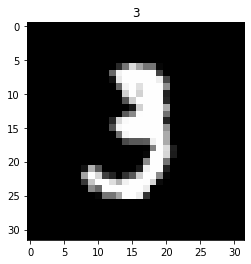

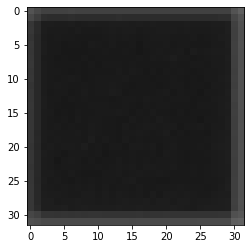

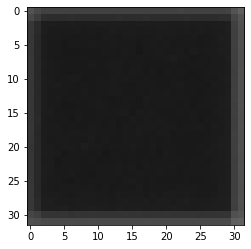

In [708]:
image, label = train_dataset[10]
plt.title(label)
plt.imshow(image[0], cmap="gray", vmin=0, vmax=1)
plt.show()

_, pred_images = model(image[None, :])
for pred_image in pred_images:
    
    plt.imshow(pred_image[0].detach().numpy()[0], cmap="gray", vmin=0, vmax=1)
    plt.show()

# Training

Epoch: 1, Loss: 0.8606:   0%|                                                                                              | 0/1875 [00:00<?, ?it/s]

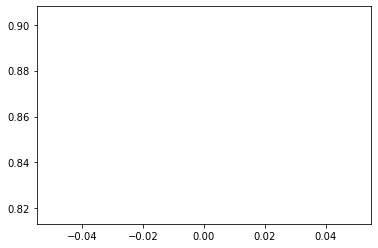

Epoch: 1, Loss: 0.8528:   0%|                                                                                      | 1/1875 [00:01<11:38,  2.68it/s]

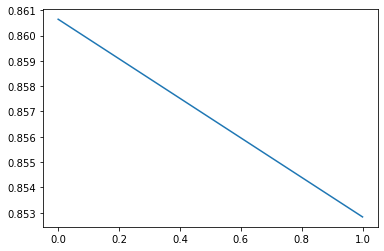

Epoch: 1, Loss: 0.8462:   0%|                                                                                      | 2/1875 [00:02<27:25,  1.14it/s]

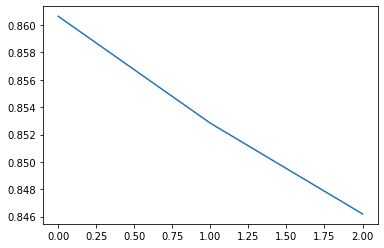

Epoch: 1, Loss: 0.8409:   0%|▏                                                                                     | 3/1875 [00:02<24:10,  1.29it/s]

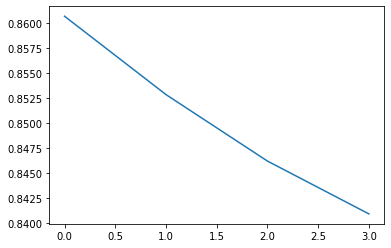

Epoch: 1, Loss: 0.8374:   0%|▏                                                                                     | 4/1875 [00:03<20:00,  1.56it/s]

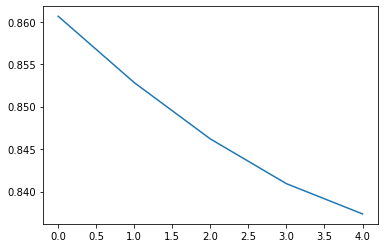

Epoch: 1, Loss: 0.8293:   0%|▏                                                                                     | 5/1875 [00:03<19:23,  1.61it/s]

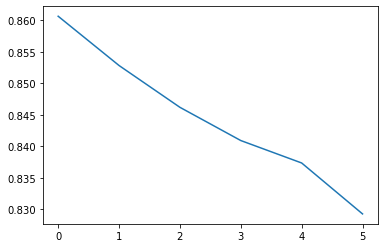

Epoch: 1, Loss: 0.8231:   0%|▎                                                                                     | 6/1875 [00:04<18:03,  1.72it/s]

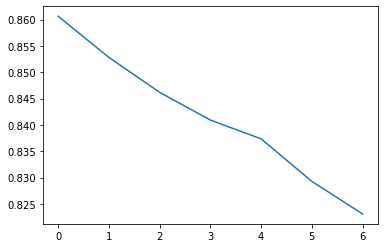

Epoch: 1, Loss: 0.8190:   0%|▎                                                                                     | 7/1875 [00:04<16:42,  1.86it/s]

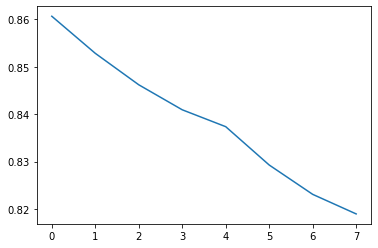

Epoch: 1, Loss: 0.8176:   0%|▎                                                                                     | 8/1875 [00:04<14:54,  2.09it/s]

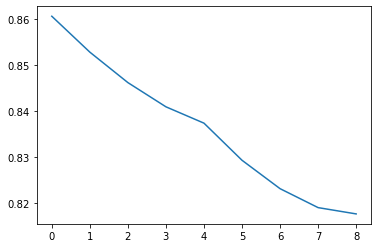

Epoch: 1, Loss: 0.8117:   0%|▍                                                                                     | 9/1875 [00:05<14:11,  2.19it/s]

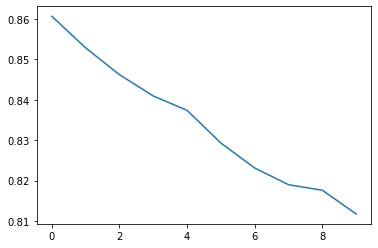

Epoch: 1, Loss: 0.8064:   1%|▍                                                                                    | 10/1875 [00:05<14:36,  2.13it/s]

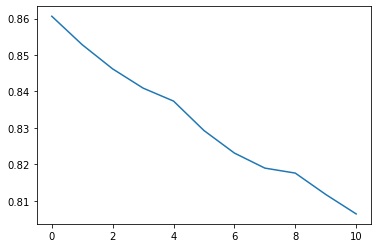

Epoch: 1, Loss: 0.8044:   1%|▍                                                                                    | 11/1875 [00:06<14:40,  2.12it/s]

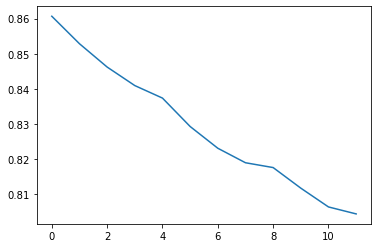

Epoch: 1, Loss: 0.8004:   1%|▌                                                                                    | 12/1875 [00:06<15:11,  2.04it/s]

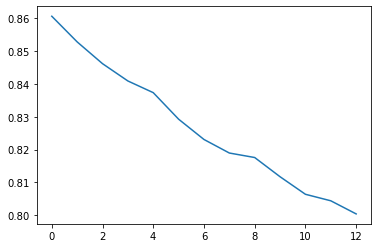

Epoch: 1, Loss: 0.7961:   1%|▌                                                                                    | 13/1875 [00:07<15:21,  2.02it/s]

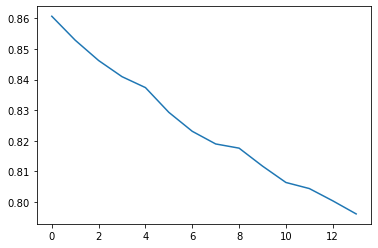

Epoch: 1, Loss: 0.7917:   1%|▋                                                                                    | 14/1875 [00:07<15:28,  2.01it/s]

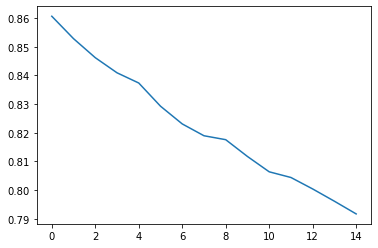

Epoch: 1, Loss: 0.7894:   1%|▋                                                                                    | 15/1875 [00:08<15:11,  2.04it/s]

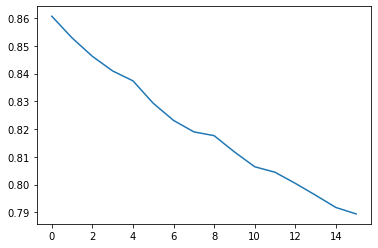

Epoch: 1, Loss: 0.7839:   1%|▋                                                                                    | 16/1875 [00:08<15:06,  2.05it/s]

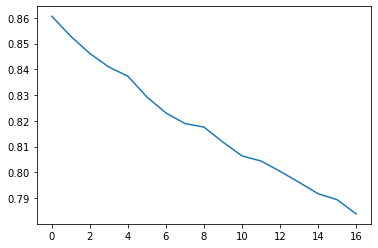

Epoch: 1, Loss: 0.7806:   1%|▊                                                                                    | 17/1875 [00:09<15:12,  2.04it/s]

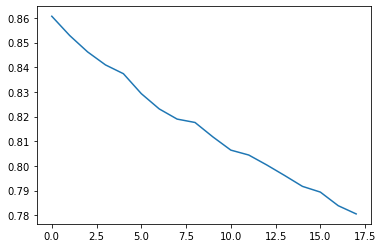

Epoch: 1, Loss: 0.7785:   1%|▊                                                                                    | 18/1875 [00:09<15:08,  2.04it/s]

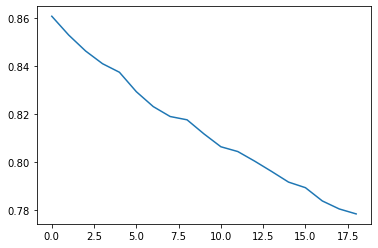

Epoch: 1, Loss: 0.7735:   1%|▊                                                                                    | 19/1875 [00:10<15:01,  2.06it/s]

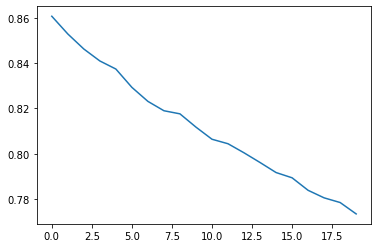

Epoch: 1, Loss: 0.7684:   1%|▉                                                                                    | 20/1875 [00:10<14:46,  2.09it/s]

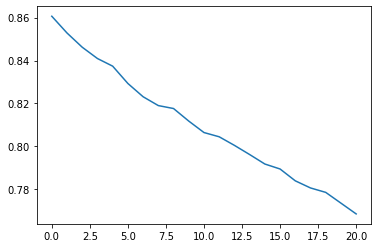

Epoch: 1, Loss: 0.7651:   1%|▉                                                                                    | 21/1875 [00:11<15:08,  2.04it/s]

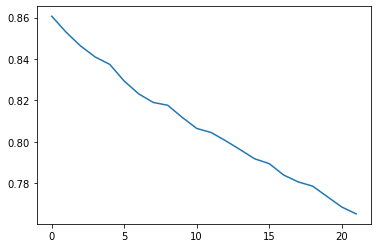

Epoch: 1, Loss: 0.7595:   1%|▉                                                                                    | 22/1875 [00:12<19:38,  1.57it/s]

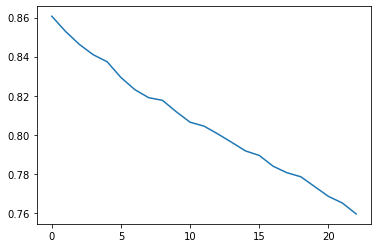

Epoch: 1, Loss: 0.7562:   1%|█                                                                                    | 23/1875 [00:12<19:01,  1.62it/s]

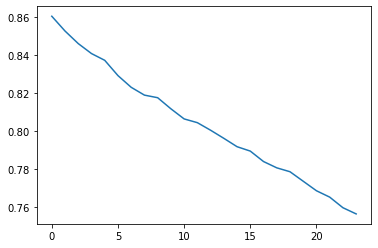

Epoch: 1, Loss: 0.7534:   1%|█                                                                                    | 24/1875 [00:13<16:59,  1.82it/s]

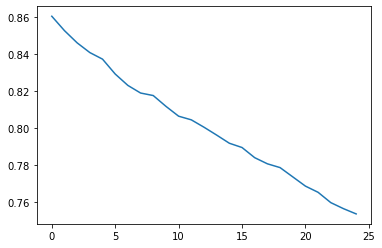

Epoch: 1, Loss: 0.7492:   1%|█▏                                                                                   | 25/1875 [00:13<15:42,  1.96it/s]

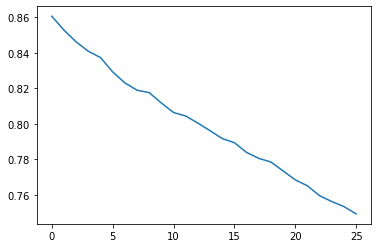

Epoch: 1, Loss: 0.7457:   1%|█▏                                                                                   | 26/1875 [00:14<14:57,  2.06it/s]

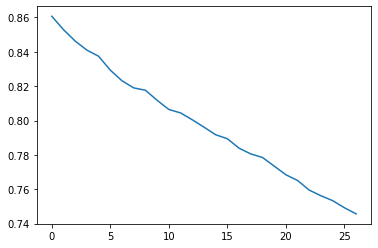

Epoch: 1, Loss: 0.7414:   1%|█▏                                                                                   | 27/1875 [00:14<14:20,  2.15it/s]

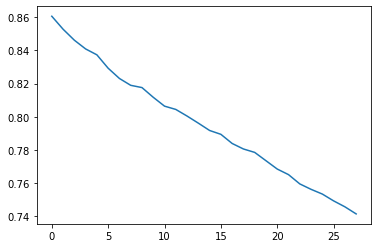

Epoch: 1, Loss: 0.7380:   1%|█▎                                                                                   | 28/1875 [00:15<13:49,  2.23it/s]

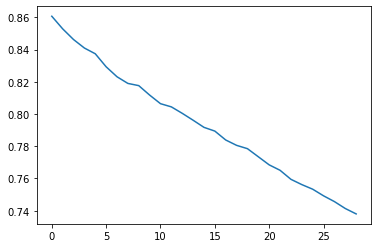

Epoch: 1, Loss: 0.7347:   2%|█▎                                                                                   | 29/1875 [00:15<14:56,  2.06it/s]

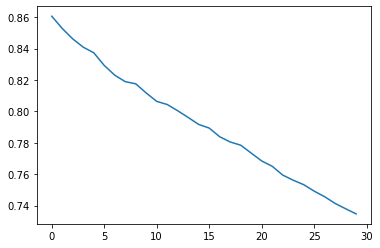

Epoch: 1, Loss: 0.7308:   2%|█▎                                                                                   | 30/1875 [00:15<14:21,  2.14it/s]

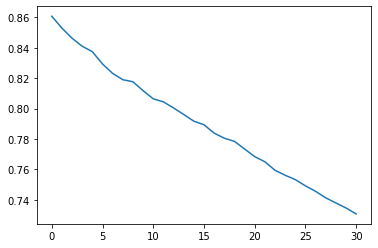

Epoch: 1, Loss: 0.7278:   2%|█▍                                                                                   | 31/1875 [00:16<14:32,  2.11it/s]

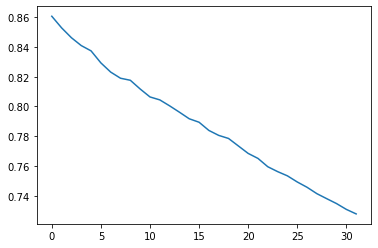

Epoch: 1, Loss: 0.7236:   2%|█▍                                                                                   | 32/1875 [00:17<13:29,  2.28it/s]

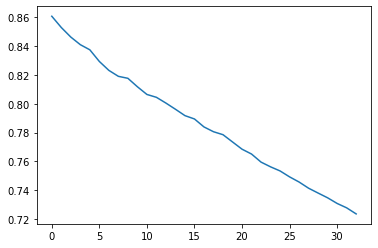

Epoch: 1, Loss: 0.7200:   2%|█▍                                                                                   | 33/1875 [00:17<17:55,  1.71it/s]

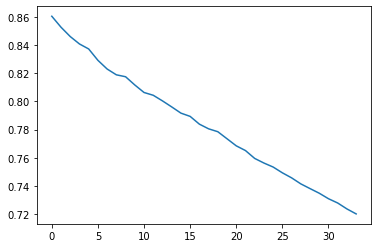

Epoch: 1, Loss: 0.7156:   2%|█▌                                                                                   | 34/1875 [00:18<19:50,  1.55it/s]

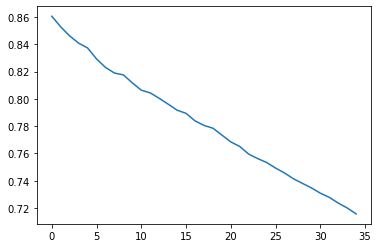

Epoch: 1, Loss: 0.7117:   2%|█▌                                                                                   | 35/1875 [00:18<17:11,  1.78it/s]

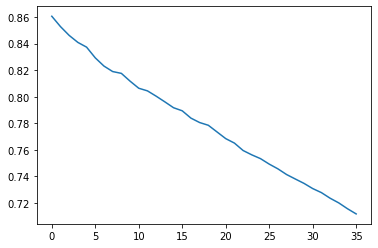

Epoch: 1, Loss: 0.7077:   2%|█▋                                                                                   | 36/1875 [00:19<16:00,  1.91it/s]

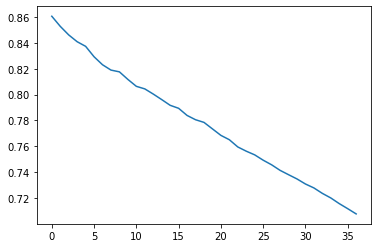

Epoch: 1, Loss: 0.7039:   2%|█▋                                                                                   | 37/1875 [00:19<15:14,  2.01it/s]

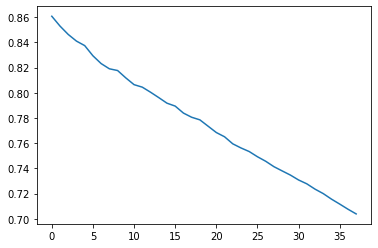

Epoch: 1, Loss: 0.7005:   2%|█▋                                                                                   | 38/1875 [00:20<15:15,  2.01it/s]

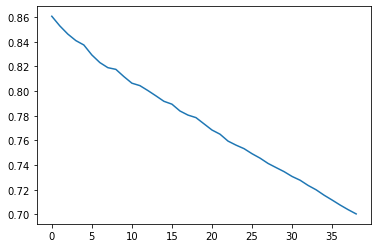

Epoch: 1, Loss: 0.6974:   2%|█▊                                                                                   | 39/1875 [00:20<14:58,  2.04it/s]

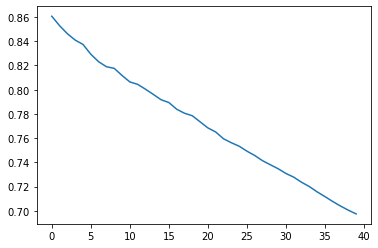

Epoch: 1, Loss: 0.6938:   2%|█▊                                                                                   | 40/1875 [00:21<14:47,  2.07it/s]

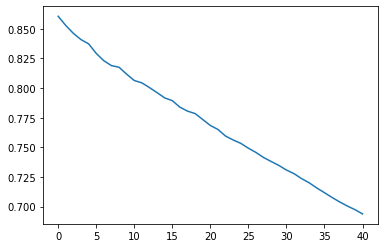

Epoch: 1, Loss: 0.6902:   2%|█▊                                                                                   | 41/1875 [00:21<14:38,  2.09it/s]

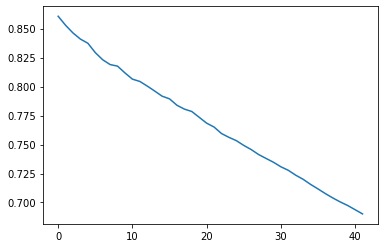

Epoch: 1, Loss: 0.6877:   2%|█▉                                                                                   | 42/1875 [00:22<14:08,  2.16it/s]

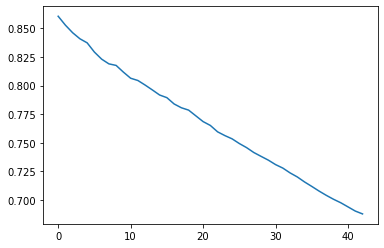

Epoch: 1, Loss: 0.6842:   2%|█▉                                                                                   | 43/1875 [00:22<14:41,  2.08it/s]

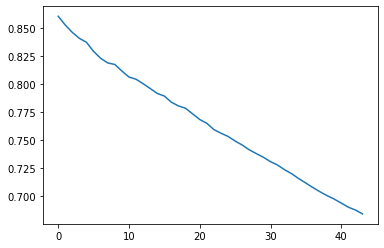

Epoch: 1, Loss: 0.6790:   2%|█▉                                                                                   | 44/1875 [00:23<14:19,  2.13it/s]

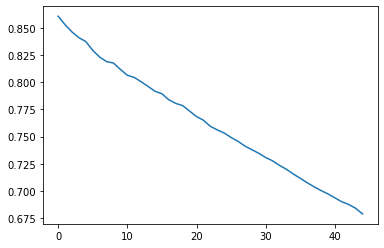

Epoch: 1, Loss: 0.6751:   2%|██                                                                                   | 45/1875 [00:23<14:02,  2.17it/s]

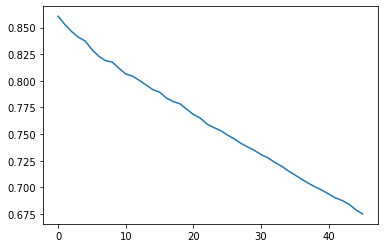

Epoch: 1, Loss: 0.6714:   2%|██                                                                                   | 46/1875 [00:24<16:41,  1.83it/s]

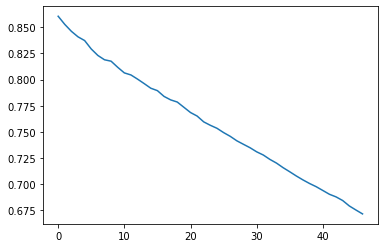

Epoch: 1, Loss: 0.6673:   3%|██▏                                                                                  | 47/1875 [00:24<16:39,  1.83it/s]

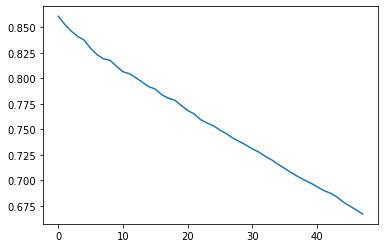

Epoch: 1, Loss: 0.6635:   3%|██▏                                                                                  | 48/1875 [00:25<15:51,  1.92it/s]

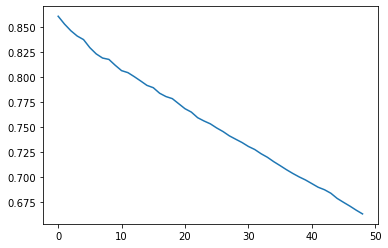

Epoch: 1, Loss: 0.6604:   3%|██▏                                                                                  | 49/1875 [00:25<15:09,  2.01it/s]

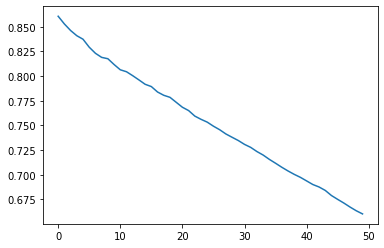

Epoch: 1, Loss: 0.6566:   3%|██▎                                                                                  | 50/1875 [00:26<14:52,  2.04it/s]

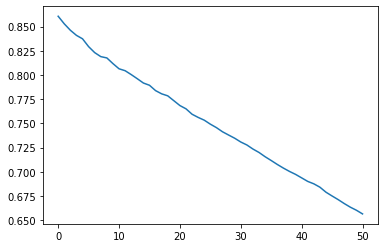

Epoch: 1, Loss: 0.6515:   3%|██▎                                                                                  | 51/1875 [00:26<16:04,  1.89it/s]

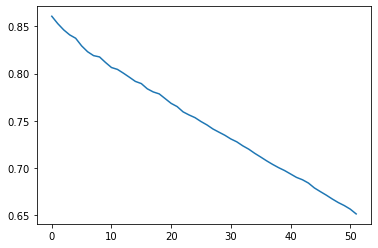

Epoch: 1, Loss: 0.6483:   3%|██▎                                                                                  | 52/1875 [00:27<14:29,  2.10it/s]

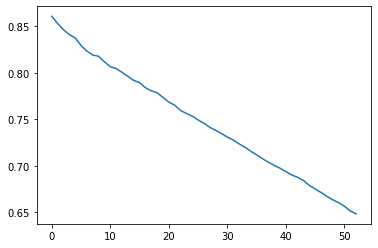

Epoch: 1, Loss: 0.6452:   3%|██▍                                                                                  | 53/1875 [00:28<18:05,  1.68it/s]

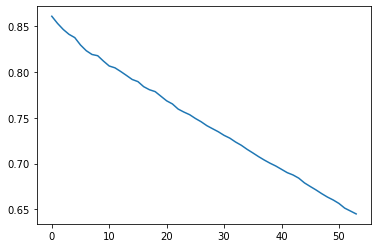

Epoch: 1, Loss: 0.6413:   3%|██▍                                                                                  | 54/1875 [00:28<21:03,  1.44it/s]

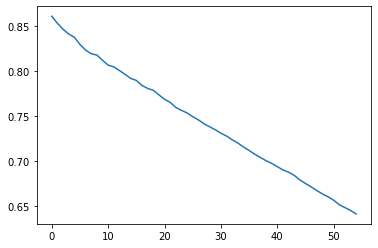

Epoch: 1, Loss: 0.6386:   3%|██▍                                                                                  | 55/1875 [00:29<20:04,  1.51it/s]

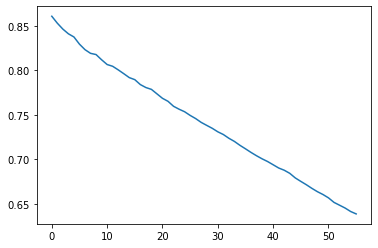

Epoch: 1, Loss: 0.6327:   3%|██▌                                                                                  | 56/1875 [00:29<18:27,  1.64it/s]

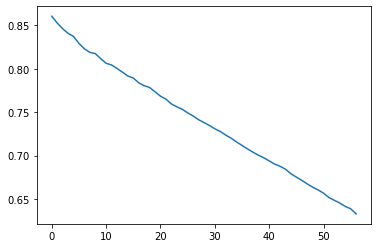

Epoch: 1, Loss: 0.6324:   3%|██▌                                                                                  | 57/1875 [00:30<16:43,  1.81it/s]

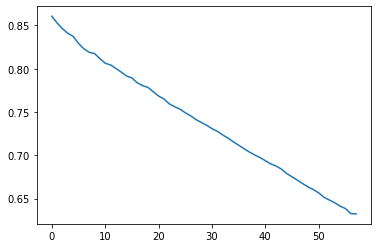

Epoch: 1, Loss: 0.6311:   3%|██▋                                                                                  | 58/1875 [00:30<16:07,  1.88it/s]

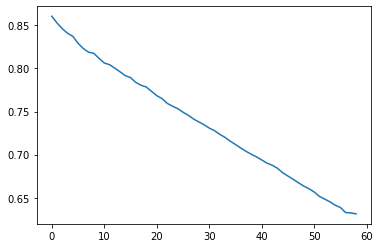

Epoch: 1, Loss: 0.6240:   3%|██▋                                                                                  | 59/1875 [00:31<15:30,  1.95it/s]

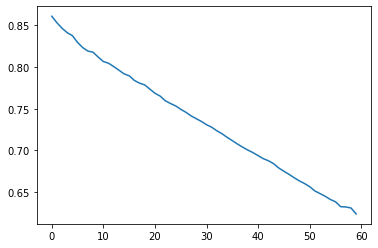

Epoch: 1, Loss: 0.6235:   3%|██▋                                                                                  | 60/1875 [00:31<14:51,  2.04it/s]

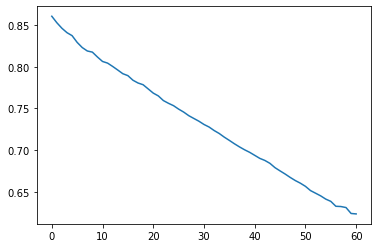

Epoch: 1, Loss: 0.6228:   3%|██▊                                                                                  | 61/1875 [00:32<14:28,  2.09it/s]

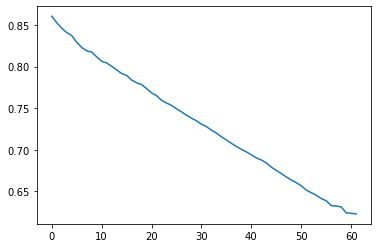

Epoch: 1, Loss: 0.6210:   3%|██▊                                                                                  | 62/1875 [00:33<14:10,  2.13it/s]

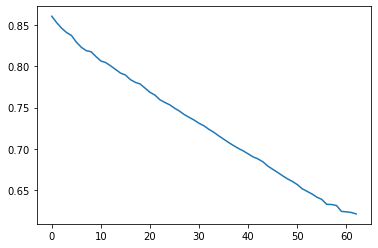

Epoch: 1, Loss: 0.6152:   3%|██▊                                                                                  | 63/1875 [00:33<20:04,  1.50it/s]

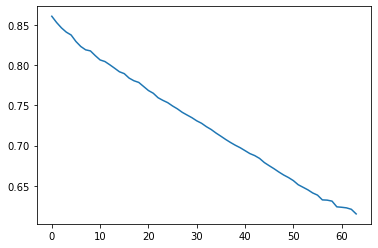

Epoch: 1, Loss: 0.6122:   3%|██▉                                                                                  | 64/1875 [00:34<17:59,  1.68it/s]

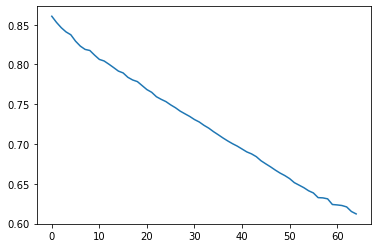

Epoch: 1, Loss: 0.6071:   3%|██▉                                                                                  | 65/1875 [00:34<16:41,  1.81it/s]

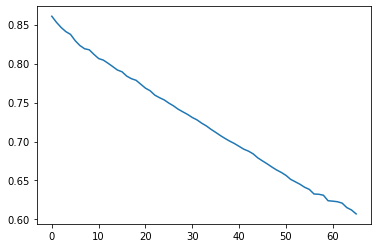

Epoch: 1, Loss: 0.6024:   4%|██▉                                                                                  | 66/1875 [00:35<16:25,  1.84it/s]

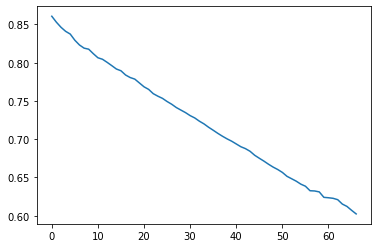

Epoch: 1, Loss: 0.6015:   4%|███                                                                                  | 67/1875 [00:35<15:00,  2.01it/s]

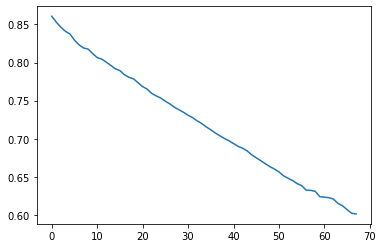

Epoch: 1, Loss: 0.5978:   4%|███                                                                                  | 68/1875 [00:36<14:38,  2.06it/s]

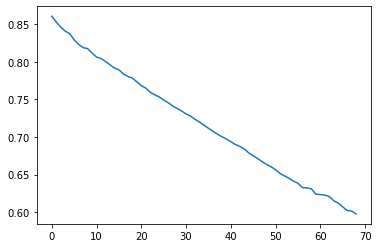

Epoch: 1, Loss: 0.5908:   4%|███▏                                                                                 | 69/1875 [00:36<14:34,  2.07it/s]

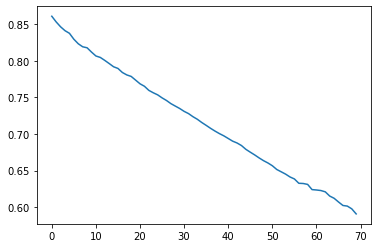

Epoch: 1, Loss: 0.5937:   4%|███▏                                                                                 | 70/1875 [00:36<14:27,  2.08it/s]

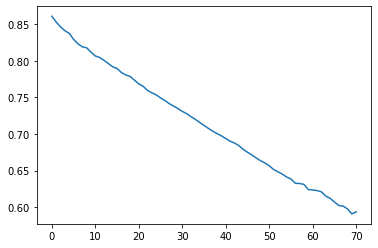

Epoch: 1, Loss: 0.5893:   4%|███▏                                                                                 | 71/1875 [00:37<13:17,  2.26it/s]

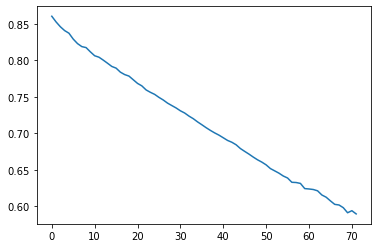

Epoch: 1, Loss: 0.5830:   4%|███▎                                                                                 | 72/1875 [00:37<13:30,  2.23it/s]

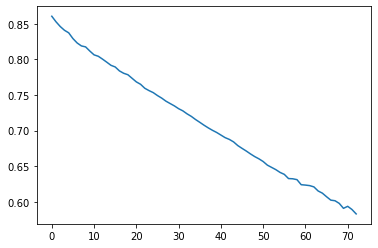

Epoch: 1, Loss: 0.5820:   4%|███▎                                                                                 | 73/1875 [00:38<13:49,  2.17it/s]

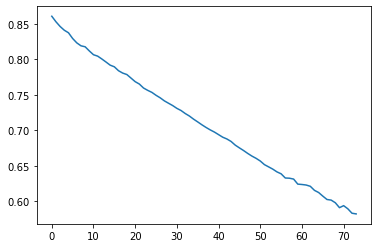

Epoch: 1, Loss: 0.5760:   4%|███▎                                                                                 | 74/1875 [00:38<14:17,  2.10it/s]

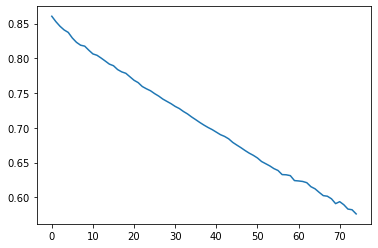

Epoch: 1, Loss: 0.5758:   4%|███▍                                                                                 | 75/1875 [00:39<14:27,  2.08it/s]

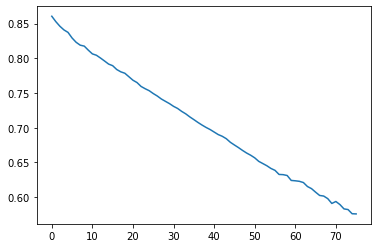

Epoch: 1, Loss: 0.5675:   4%|███▍                                                                                 | 76/1875 [00:39<14:23,  2.08it/s]

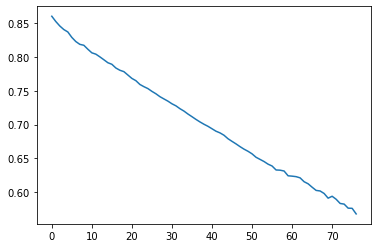

Epoch: 1, Loss: 0.5736:   4%|███▍                                                                                 | 77/1875 [00:40<14:51,  2.02it/s]

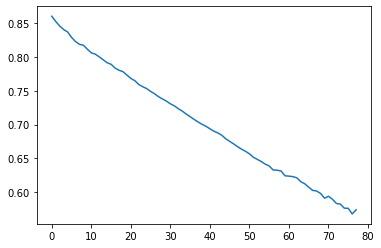

Epoch: 1, Loss: 0.5697:   4%|███▌                                                                                 | 78/1875 [00:40<14:34,  2.05it/s]

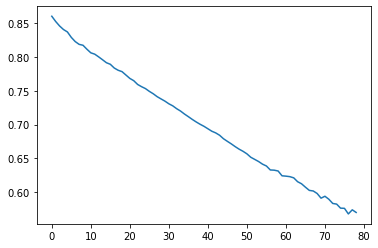

Epoch: 1, Loss: 0.5653:   4%|███▌                                                                                 | 79/1875 [00:41<14:05,  2.13it/s]

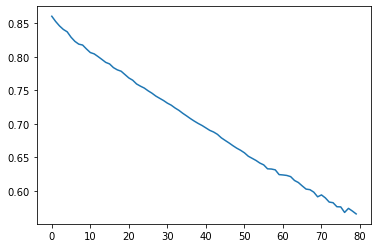

Epoch: 1, Loss: 0.5646:   4%|███▋                                                                                 | 80/1875 [00:41<13:46,  2.17it/s]

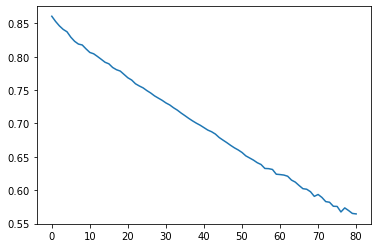

Epoch: 1, Loss: 0.5561:   4%|███▋                                                                                 | 81/1875 [00:42<13:45,  2.17it/s]

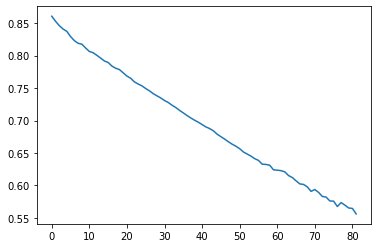

Epoch: 1, Loss: 0.5581:   4%|███▋                                                                                 | 82/1875 [00:42<13:45,  2.17it/s]

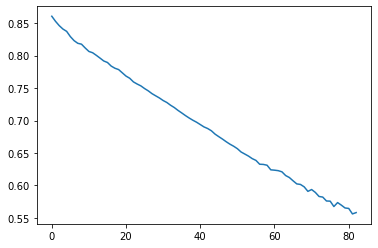

Epoch: 1, Loss: 0.5572:   4%|███▊                                                                                 | 83/1875 [00:43<13:38,  2.19it/s]

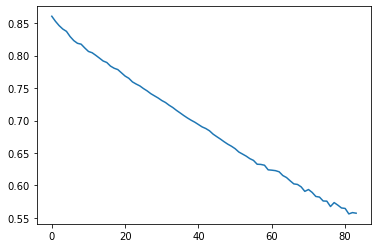

Epoch: 1, Loss: 0.5453:   4%|███▊                                                                                 | 84/1875 [00:44<16:09,  1.85it/s]

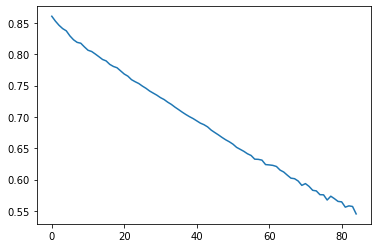

Epoch: 1, Loss: 0.5477:   5%|███▊                                                                                 | 85/1875 [00:44<20:30,  1.45it/s]

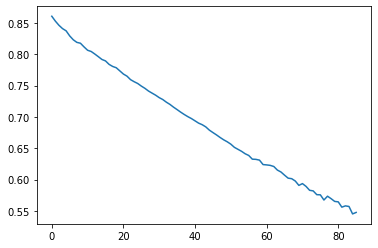

Epoch: 1, Loss: 0.5449:   5%|███▉                                                                                 | 86/1875 [00:45<18:47,  1.59it/s]

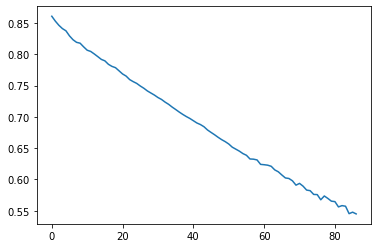

Epoch: 1, Loss: 0.5428:   5%|███▉                                                                                 | 87/1875 [00:45<18:03,  1.65it/s]

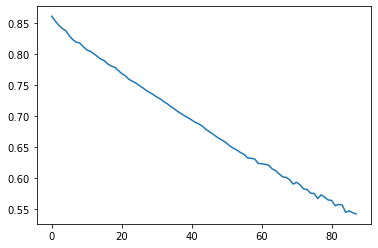

Epoch: 1, Loss: 0.5406:   5%|███▉                                                                                 | 88/1875 [00:46<16:58,  1.76it/s]

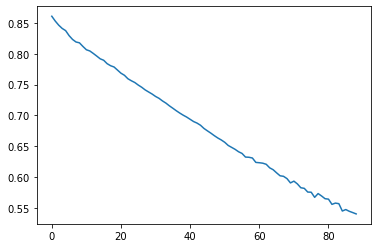

Epoch: 1, Loss: 0.5436:   5%|████                                                                                 | 89/1875 [00:47<15:59,  1.86it/s]

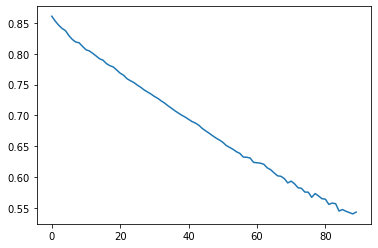

Epoch: 1, Loss: 0.5331:   5%|████                                                                                 | 90/1875 [00:47<19:21,  1.54it/s]

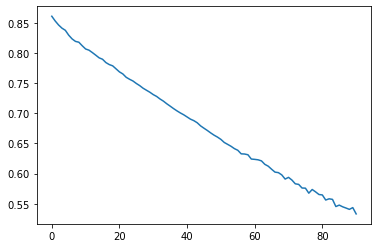

Epoch: 1, Loss: 0.5352:   5%|████▏                                                                                | 91/1875 [00:48<16:19,  1.82it/s]

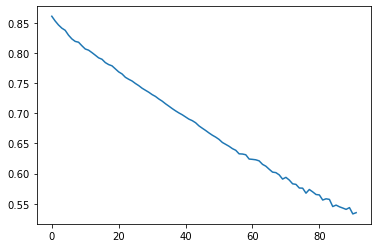

Epoch: 1, Loss: 0.5250:   5%|████▏                                                                                | 92/1875 [00:48<16:04,  1.85it/s]

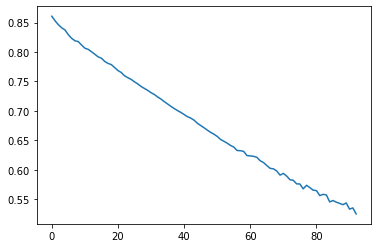

Epoch: 1, Loss: 0.5178:   5%|████▏                                                                                | 93/1875 [00:49<15:34,  1.91it/s]

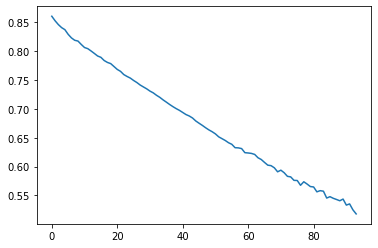

Epoch: 1, Loss: 0.5272:   5%|████▎                                                                                | 94/1875 [00:50<22:58,  1.29it/s]

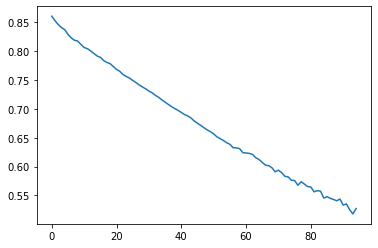

Epoch: 1, Loss: 0.5156:   5%|████▎                                                                                | 95/1875 [00:51<20:47,  1.43it/s]

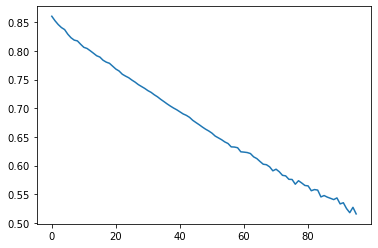

Epoch: 1, Loss: 0.5131:   5%|████▎                                                                                | 96/1875 [00:51<19:30,  1.52it/s]

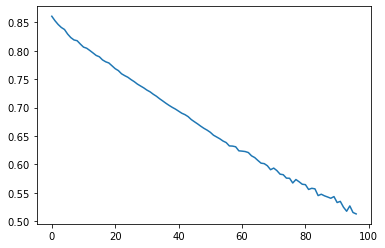

Epoch: 1, Loss: 0.5105:   5%|████▍                                                                                | 97/1875 [00:52<17:47,  1.67it/s]

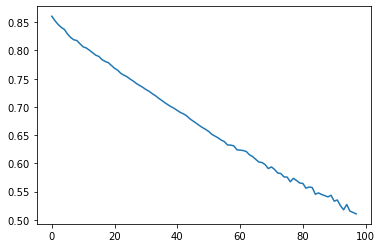

Epoch: 1, Loss: 0.5096:   5%|████▍                                                                                | 98/1875 [00:52<17:34,  1.69it/s]

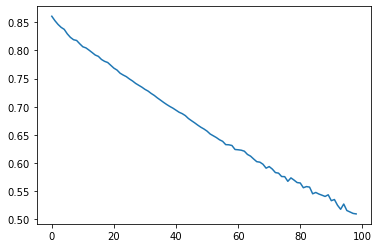

Epoch: 1, Loss: 0.5044:   5%|████▍                                                                                | 99/1875 [00:53<17:05,  1.73it/s]

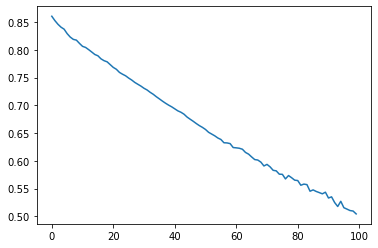

Epoch: 1, Loss: 0.4985:   5%|████▍                                                                               | 100/1875 [00:53<15:51,  1.86it/s]

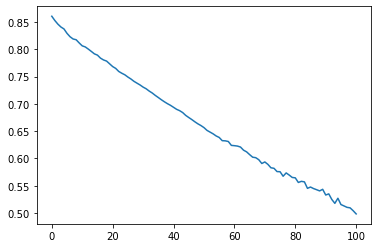

Epoch: 1, Loss: 0.5066:   5%|████▌                                                                               | 101/1875 [00:54<15:30,  1.91it/s]

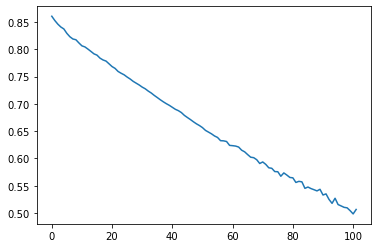

Epoch: 1, Loss: 0.4954:   5%|████▌                                                                               | 102/1875 [00:54<14:56,  1.98it/s]

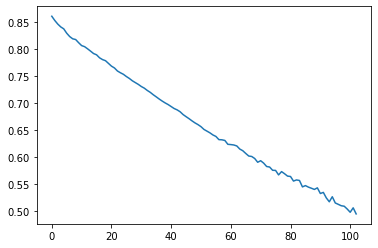

Epoch: 1, Loss: 0.4964:   5%|████▌                                                                               | 103/1875 [00:55<14:42,  2.01it/s]

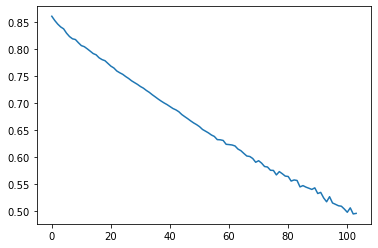

Epoch: 1, Loss: 0.4982:   6%|████▋                                                                               | 104/1875 [00:55<15:15,  1.94it/s]

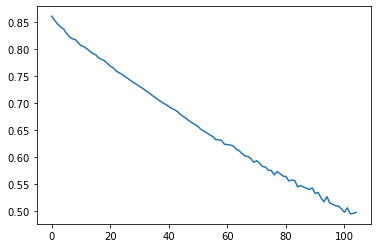

Epoch: 1, Loss: 0.4988:   6%|████▋                                                                               | 105/1875 [00:55<14:16,  2.07it/s]

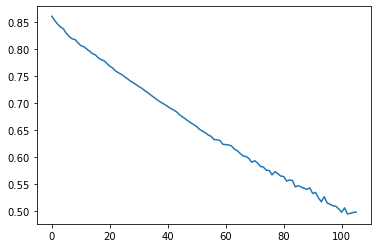

Epoch: 1, Loss: 0.4899:   6%|████▋                                                                               | 106/1875 [00:56<14:21,  2.05it/s]

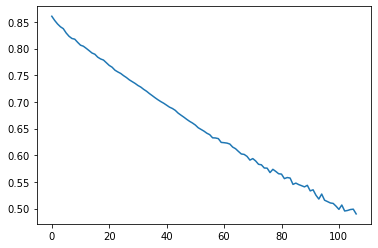

Epoch: 1, Loss: 0.4819:   6%|████▊                                                                               | 107/1875 [00:57<13:57,  2.11it/s]

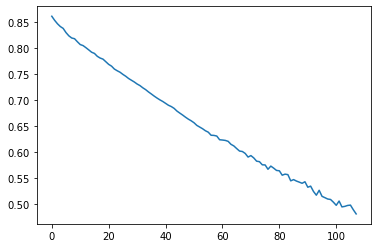

Epoch: 1, Loss: 0.4796:   6%|████▊                                                                               | 108/1875 [00:57<15:16,  1.93it/s]

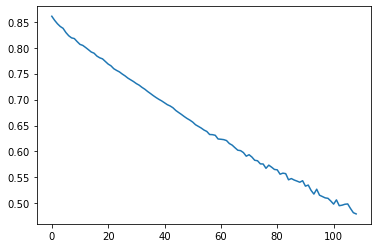

Epoch: 1, Loss: 0.4842:   6%|████▉                                                                               | 109/1875 [00:58<15:12,  1.94it/s]

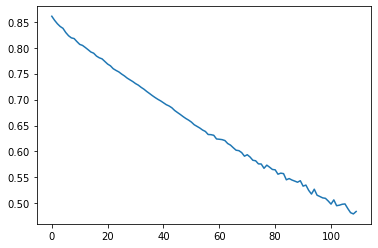

Epoch: 1, Loss: 0.4819:   6%|████▉                                                                               | 110/1875 [00:58<15:14,  1.93it/s]

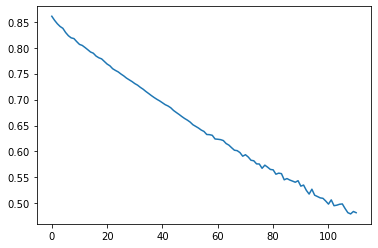

Epoch: 1, Loss: 0.4872:   6%|████▉                                                                               | 111/1875 [00:59<15:56,  1.84it/s]

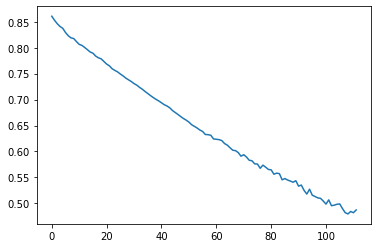

Epoch: 1, Loss: 0.4898:   6%|█████                                                                               | 112/1875 [00:59<18:34,  1.58it/s]

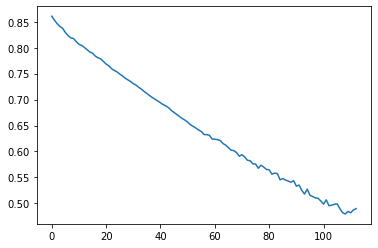

Epoch: 1, Loss: 0.4837:   6%|█████                                                                               | 113/1875 [01:00<17:20,  1.69it/s]

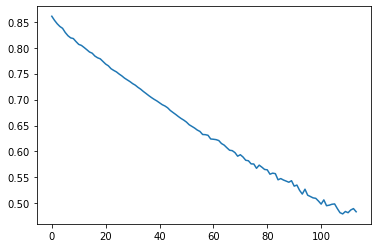

Epoch: 1, Loss: 0.4899:   6%|█████                                                                               | 114/1875 [01:00<16:29,  1.78it/s]

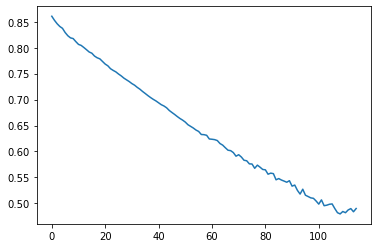

Epoch: 1, Loss: 0.4882:   6%|█████▏                                                                              | 115/1875 [01:01<15:33,  1.89it/s]

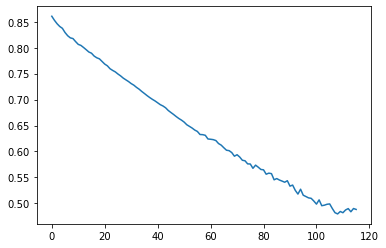

Epoch: 1, Loss: 0.4731:   6%|█████▏                                                                              | 116/1875 [01:02<15:46,  1.86it/s]

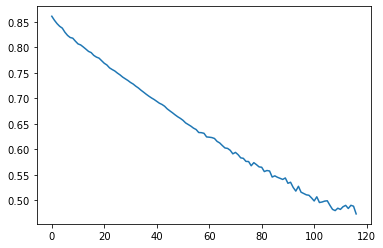

Epoch: 1, Loss: 0.4706:   6%|█████▏                                                                              | 117/1875 [01:02<15:40,  1.87it/s]

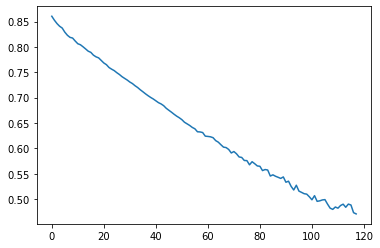

Epoch: 1, Loss: 0.4688:   6%|█████▎                                                                              | 118/1875 [01:02<15:08,  1.93it/s]

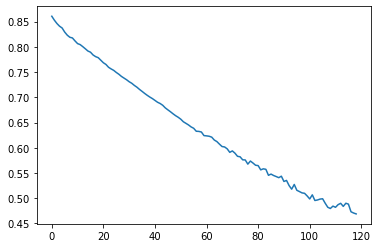

Epoch: 1, Loss: 0.4675:   6%|█████▎                                                                              | 119/1875 [01:03<14:40,  2.00it/s]

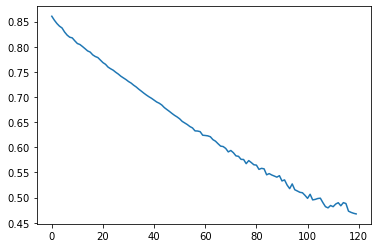

Epoch: 1, Loss: 0.4637:   6%|█████▍                                                                              | 120/1875 [01:04<14:55,  1.96it/s]

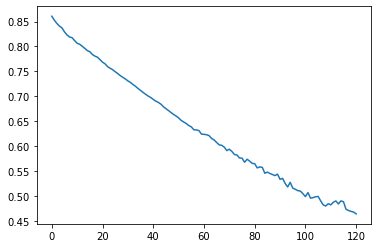

Epoch: 1, Loss: 0.4593:   6%|█████▍                                                                              | 121/1875 [01:05<17:16,  1.69it/s]

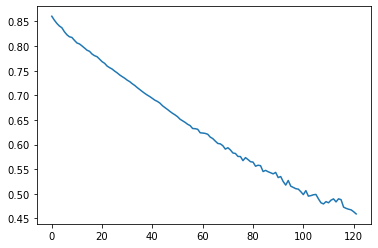

Epoch: 1, Loss: 0.4595:   7%|█████▍                                                                              | 122/1875 [01:06<23:08,  1.26it/s]

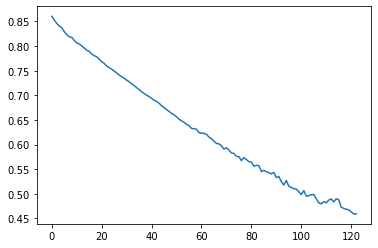

Epoch: 1, Loss: 0.4619:   7%|█████▌                                                                              | 123/1875 [01:06<20:19,  1.44it/s]

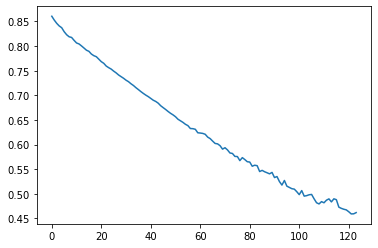

Epoch: 1, Loss: 0.4582:   7%|█████▌                                                                              | 124/1875 [01:06<18:32,  1.57it/s]

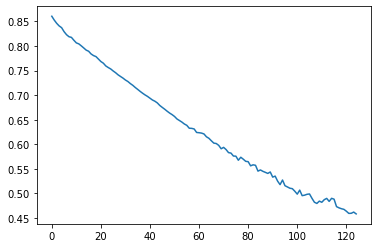

Epoch: 1, Loss: 0.4553:   7%|█████▌                                                                              | 125/1875 [01:07<17:15,  1.69it/s]

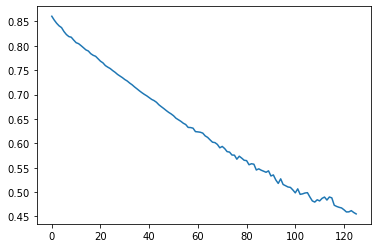

Epoch: 1, Loss: 0.4659:   7%|█████▋                                                                              | 126/1875 [01:08<18:01,  1.62it/s]

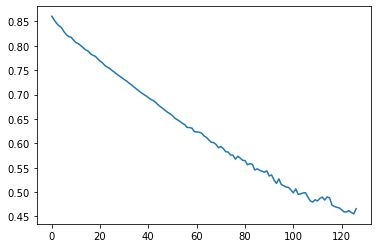

Epoch: 1, Loss: 0.4577:   7%|█████▋                                                                              | 127/1875 [01:08<16:51,  1.73it/s]

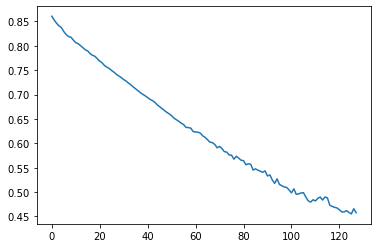

Epoch: 1, Loss: 0.4571:   7%|█████▋                                                                              | 128/1875 [01:09<16:15,  1.79it/s]

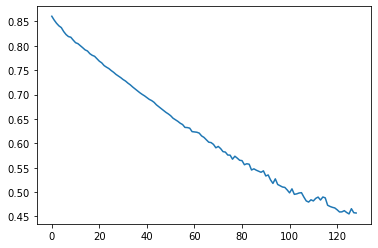

Epoch: 1, Loss: 0.4442:   7%|█████▊                                                                              | 129/1875 [01:09<15:46,  1.84it/s]

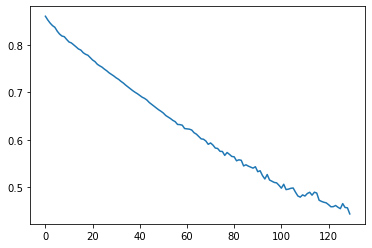

Epoch: 1, Loss: 0.4374:   7%|█████▊                                                                              | 130/1875 [01:10<14:57,  1.95it/s]

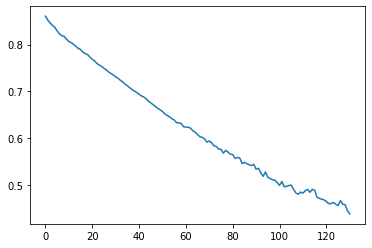

Epoch: 1, Loss: 0.4517:   7%|█████▊                                                                              | 131/1875 [01:10<14:47,  1.97it/s]

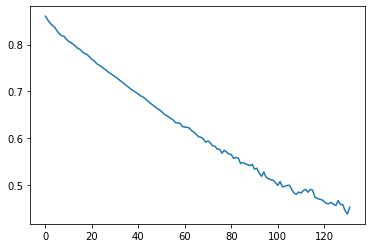

Epoch: 1, Loss: 0.4540:   7%|█████▉                                                                              | 132/1875 [01:11<14:33,  2.00it/s]

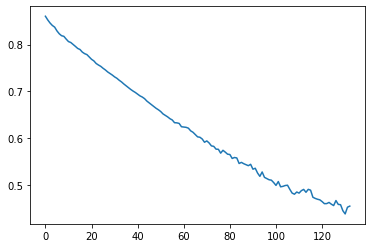

Epoch: 1, Loss: 0.4477:   7%|█████▉                                                                              | 133/1875 [01:11<14:19,  2.03it/s]

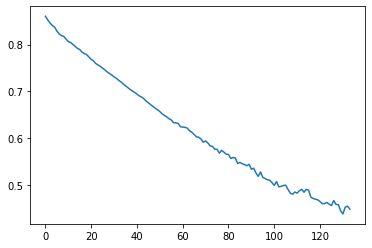

Epoch: 1, Loss: 0.4441:   7%|██████                                                                              | 134/1875 [01:12<15:01,  1.93it/s]

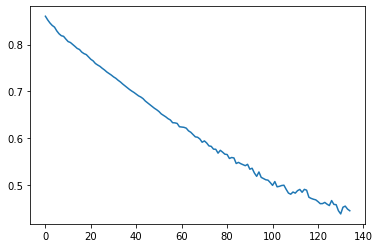

Epoch: 1, Loss: 0.4388:   7%|██████                                                                              | 135/1875 [01:12<14:26,  2.01it/s]

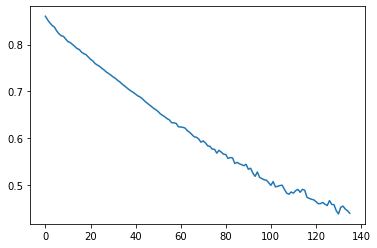

Epoch: 1, Loss: 0.4383:   7%|██████                                                                              | 136/1875 [01:12<13:57,  2.08it/s]

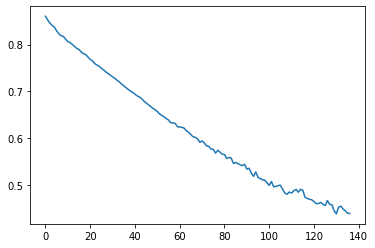

Epoch: 1, Loss: 0.4242:   7%|██████▏                                                                             | 137/1875 [01:13<13:23,  2.16it/s]

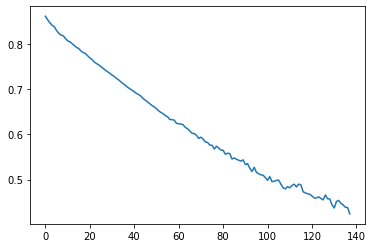

Epoch: 1, Loss: 0.4301:   7%|██████▏                                                                             | 138/1875 [01:14<15:10,  1.91it/s]

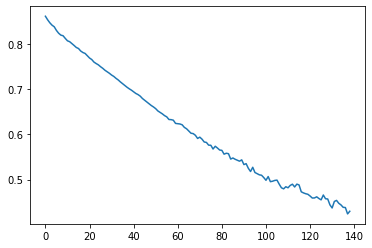

Epoch: 1, Loss: 0.4419:   7%|██████▏                                                                             | 139/1875 [01:14<13:49,  2.09it/s]

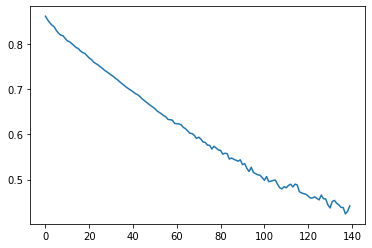

Epoch: 1, Loss: 0.4539:   7%|██████▎                                                                             | 140/1875 [01:14<12:51,  2.25it/s]

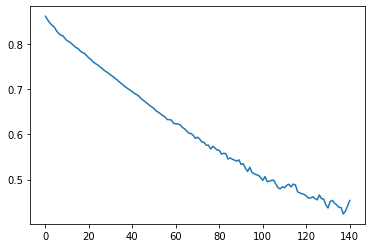

Epoch: 1, Loss: 0.4500:   8%|██████▎                                                                             | 141/1875 [01:15<16:35,  1.74it/s]

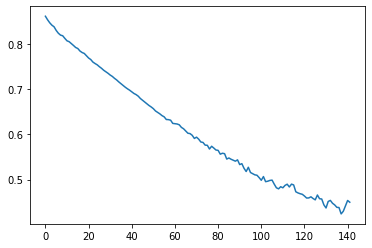

Epoch: 1, Loss: 0.4275:   8%|██████▎                                                                             | 142/1875 [01:16<14:59,  1.93it/s]

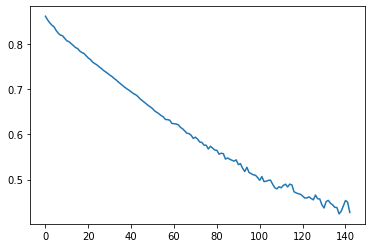

Epoch: 1, Loss: 0.4442:   8%|██████▍                                                                             | 143/1875 [01:17<19:14,  1.50it/s]

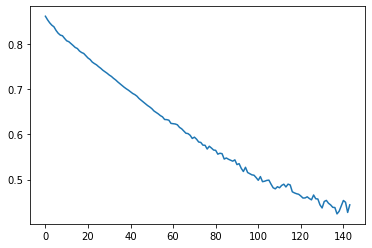

Epoch: 1, Loss: 0.4414:   8%|██████▍                                                                             | 144/1875 [01:17<18:06,  1.59it/s]

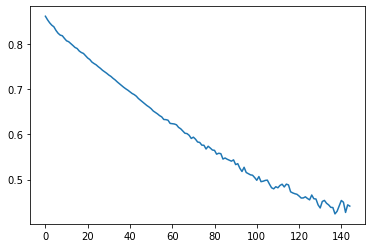

Epoch: 1, Loss: 0.4477:   8%|██████▍                                                                             | 145/1875 [01:18<16:03,  1.80it/s]

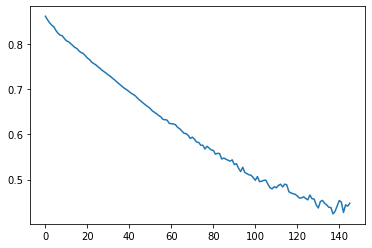

Epoch: 1, Loss: 0.4596:   8%|██████▌                                                                             | 146/1875 [01:18<15:26,  1.87it/s]

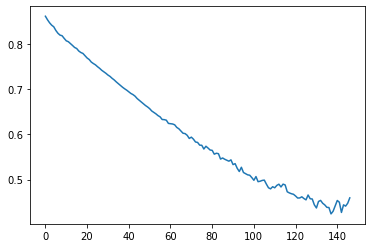

Epoch: 1, Loss: 0.4439:   8%|██████▌                                                                             | 147/1875 [01:19<14:52,  1.94it/s]

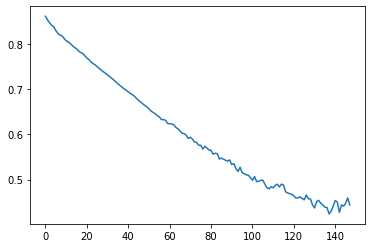

Epoch: 1, Loss: 0.4358:   8%|██████▋                                                                             | 148/1875 [01:19<14:31,  1.98it/s]

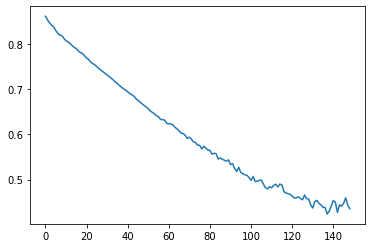

Epoch: 1, Loss: 0.4296:   8%|██████▋                                                                             | 149/1875 [01:20<12:49,  2.24it/s]

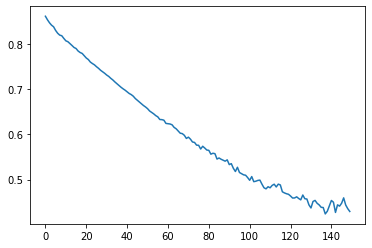

Epoch: 1, Loss: 0.4259:   8%|██████▋                                                                             | 150/1875 [01:21<15:51,  1.81it/s]

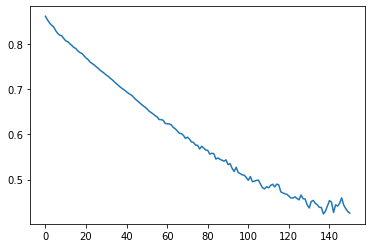

Epoch: 1, Loss: 0.4480:   8%|██████▊                                                                             | 151/1875 [01:21<20:06,  1.43it/s]

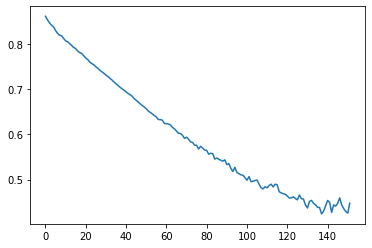

Epoch: 1, Loss: 0.4442:   8%|██████▊                                                                             | 152/1875 [01:22<17:37,  1.63it/s]

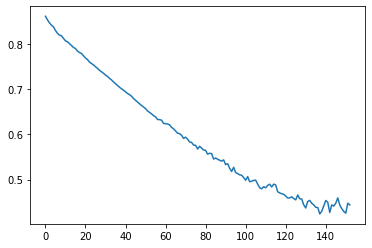

Epoch: 1, Loss: 0.4210:   8%|██████▊                                                                             | 153/1875 [01:22<16:14,  1.77it/s]

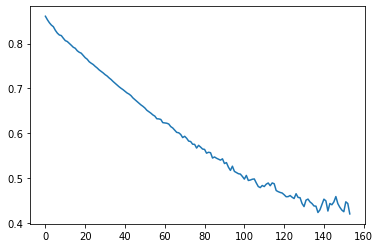

Epoch: 1, Loss: 0.4199:   8%|██████▉                                                                             | 154/1875 [01:22<14:02,  2.04it/s]

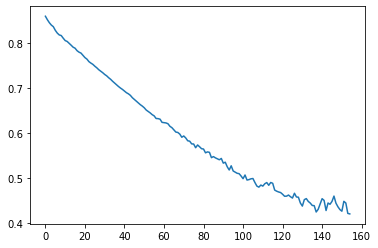

Epoch: 1, Loss: 0.4082:   8%|██████▉                                                                             | 155/1875 [01:23<12:48,  2.24it/s]

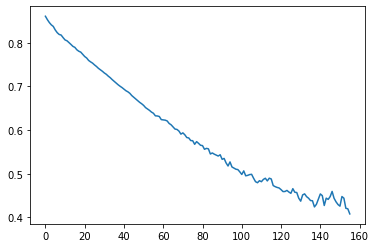

Epoch: 1, Loss: 0.4219:   8%|██████▉                                                                             | 156/1875 [01:23<12:49,  2.23it/s]

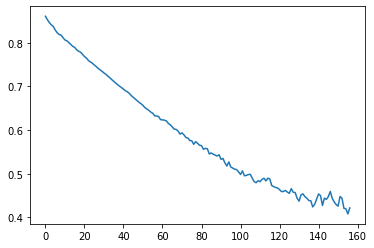

Epoch: 1, Loss: 0.4224:   8%|███████                                                                             | 157/1875 [01:24<13:08,  2.18it/s]

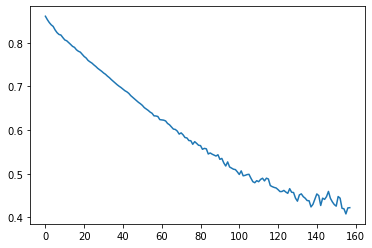

Epoch: 1, Loss: 0.4311:   8%|███████                                                                             | 158/1875 [01:24<13:26,  2.13it/s]

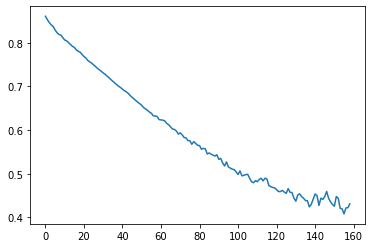

Epoch: 1, Loss: 0.4258:   8%|███████                                                                             | 159/1875 [01:25<12:53,  2.22it/s]

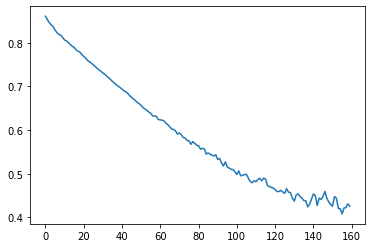

Epoch: 1, Loss: 0.4236:   9%|███████▏                                                                            | 160/1875 [01:25<13:18,  2.15it/s]

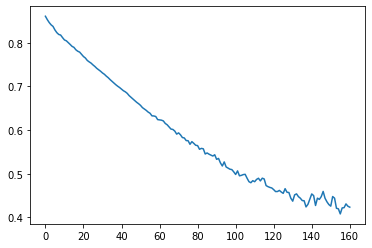

Epoch: 1, Loss: 0.4276:   9%|███████▏                                                                            | 161/1875 [01:25<12:38,  2.26it/s]

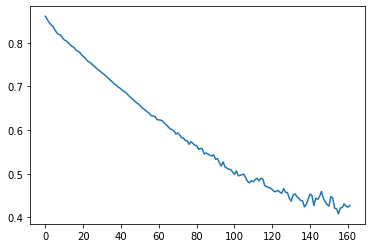

Epoch: 1, Loss: 0.4241:   9%|███████▎                                                                            | 162/1875 [01:26<13:04,  2.18it/s]

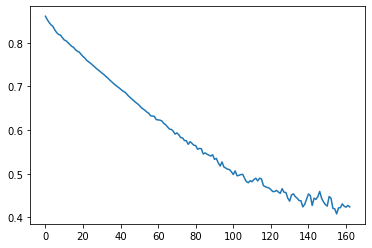

Epoch: 1, Loss: 0.4205:   9%|███████▎                                                                            | 163/1875 [01:26<13:56,  2.05it/s]

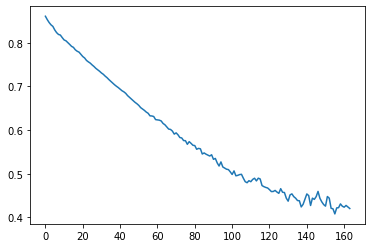

Epoch: 1, Loss: 0.4284:   9%|███████▎                                                                            | 164/1875 [01:27<13:44,  2.08it/s]

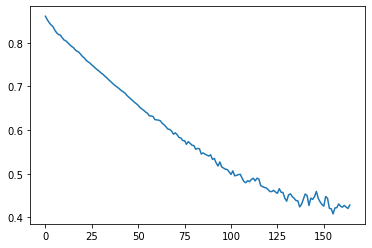

Epoch: 1, Loss: 0.4070:   9%|███████▍                                                                            | 165/1875 [01:27<13:19,  2.14it/s]

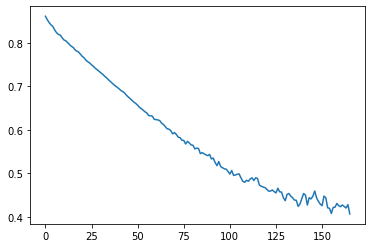

Epoch: 1, Loss: 0.4366:   9%|███████▍                                                                            | 166/1875 [01:28<12:28,  2.28it/s]

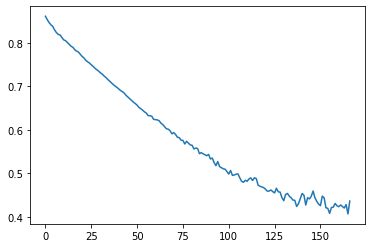

Epoch: 1, Loss: 0.4321:   9%|███████▍                                                                            | 167/1875 [01:28<12:20,  2.31it/s]

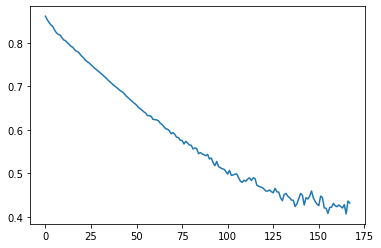

Epoch: 1, Loss: 0.4373:   9%|███████▌                                                                            | 168/1875 [01:29<13:50,  2.05it/s]

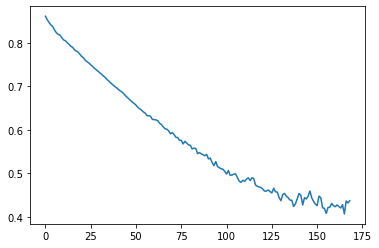

Epoch: 1, Loss: 0.4230:   9%|███████▌                                                                            | 169/1875 [01:29<13:24,  2.12it/s]

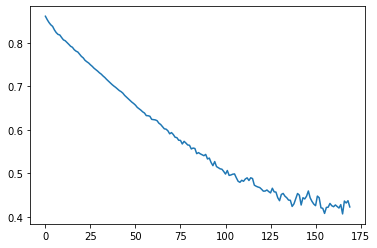

Epoch: 1, Loss: 0.4339:   9%|███████▌                                                                            | 170/1875 [01:30<13:24,  2.12it/s]

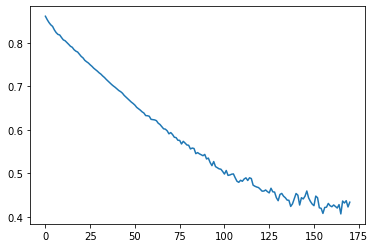

Epoch: 1, Loss: 0.4231:   9%|███████▋                                                                            | 171/1875 [01:30<13:46,  2.06it/s]

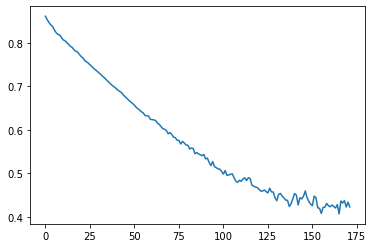

Epoch: 1, Loss: 0.4168:   9%|███████▋                                                                            | 172/1875 [01:31<13:10,  2.15it/s]

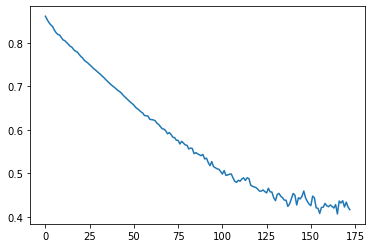

Epoch: 1, Loss: 0.4205:   9%|███████▊                                                                            | 173/1875 [01:32<18:35,  1.53it/s]

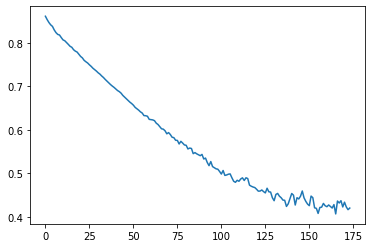

Epoch: 1, Loss: 0.4135:   9%|███████▊                                                                            | 174/1875 [01:32<17:47,  1.59it/s]

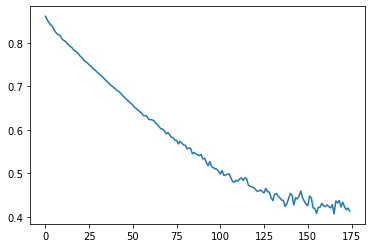

Epoch: 1, Loss: 0.4165:   9%|███████▊                                                                            | 175/1875 [01:33<15:51,  1.79it/s]

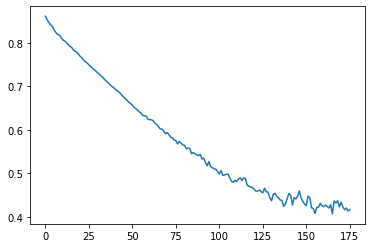

Epoch: 1, Loss: 0.4099:   9%|███████▉                                                                            | 176/1875 [01:33<14:42,  1.92it/s]

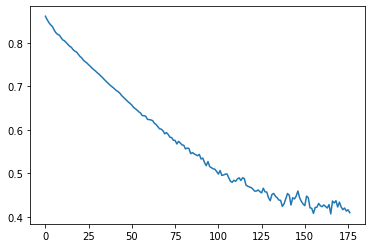

Epoch: 1, Loss: 0.4090:   9%|███████▉                                                                            | 177/1875 [01:33<14:03,  2.01it/s]

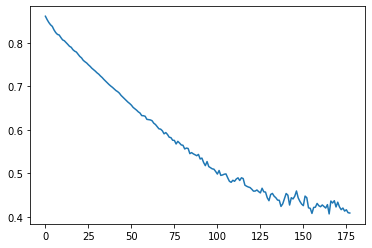

Epoch: 1, Loss: 0.4127:   9%|███████▉                                                                            | 178/1875 [01:34<13:05,  2.16it/s]

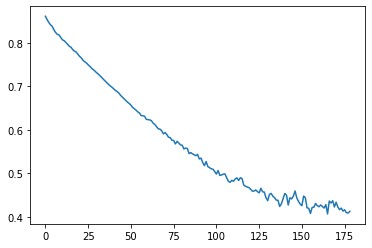

Epoch: 1, Loss: 0.4141:  10%|████████                                                                            | 179/1875 [01:34<12:45,  2.22it/s]

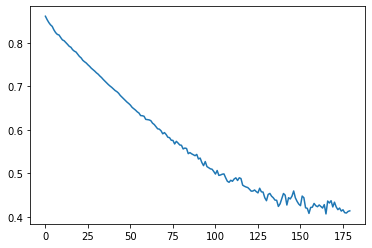

Epoch: 1, Loss: 0.3923:  10%|████████                                                                            | 180/1875 [01:35<12:45,  2.22it/s]

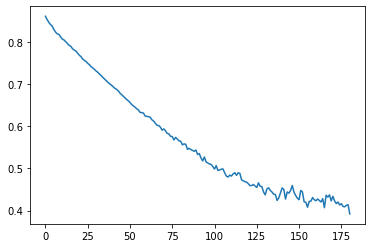

Epoch: 1, Loss: 0.4064:  10%|████████                                                                            | 181/1875 [01:36<13:38,  2.07it/s]

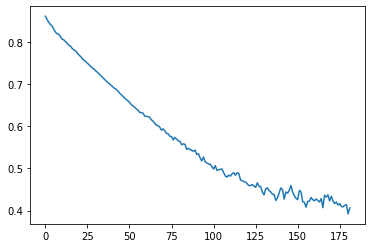

Epoch: 1, Loss: 0.3914:  10%|████████▏                                                                           | 182/1875 [01:37<20:00,  1.41it/s]

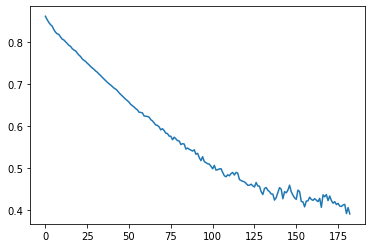

Epoch: 1, Loss: 0.4005:  10%|████████▏                                                                           | 183/1875 [01:38<21:07,  1.34it/s]

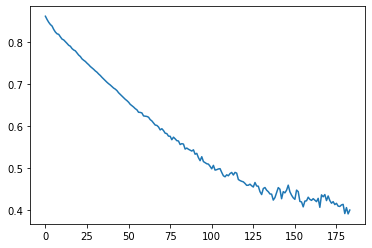

Epoch: 1, Loss: 0.3993:  10%|████████▏                                                                           | 184/1875 [01:38<20:14,  1.39it/s]

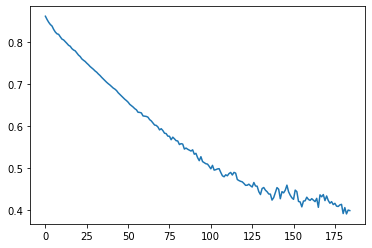

Epoch: 1, Loss: 0.4003:  10%|████████▎                                                                           | 185/1875 [01:39<20:12,  1.39it/s]

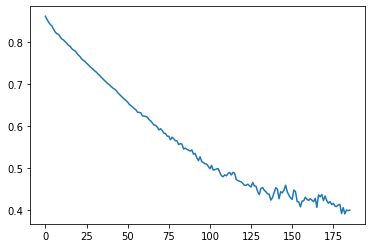

Epoch: 1, Loss: 0.4317:  10%|████████▎                                                                           | 186/1875 [01:39<18:16,  1.54it/s]

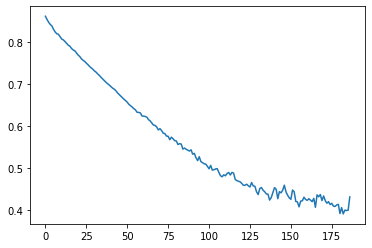

Epoch: 1, Loss: 0.4360:  10%|████████▍                                                                           | 187/1875 [01:40<16:55,  1.66it/s]

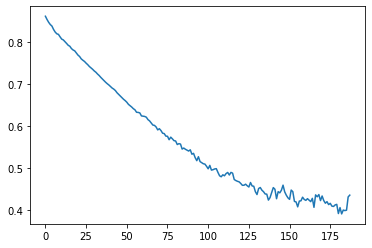

Epoch: 1, Loss: 0.4352:  10%|████████▍                                                                           | 188/1875 [01:40<15:40,  1.79it/s]

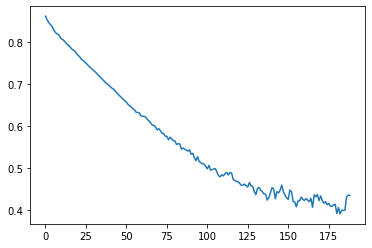

Epoch: 1, Loss: 0.4326:  10%|████████▍                                                                           | 189/1875 [01:40<13:58,  2.01it/s]

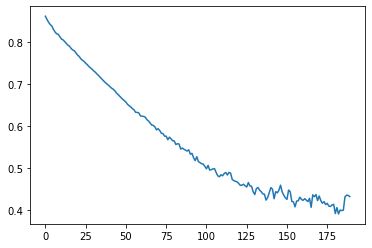

Epoch: 1, Loss: 0.4273:  10%|████████▌                                                                           | 190/1875 [01:41<12:29,  2.25it/s]

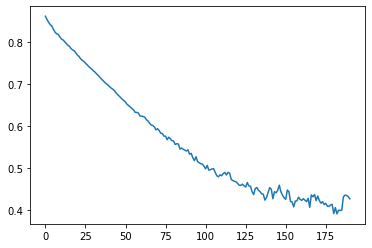

Epoch: 1, Loss: 0.4373:  10%|████████▌                                                                           | 191/1875 [01:41<12:16,  2.29it/s]

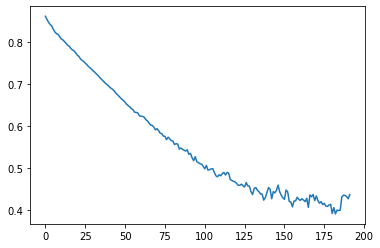

Epoch: 1, Loss: 0.4357:  10%|████████▌                                                                           | 192/1875 [01:42<12:26,  2.25it/s]

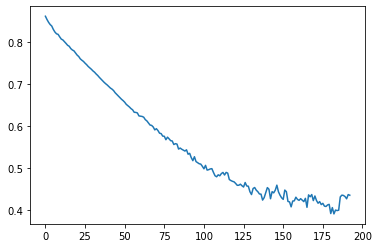

Epoch: 1, Loss: 0.4145:  10%|████████▋                                                                           | 193/1875 [01:42<12:55,  2.17it/s]

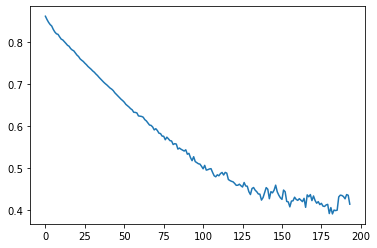

Epoch: 1, Loss: 0.4126:  10%|████████▋                                                                           | 194/1875 [01:43<12:36,  2.22it/s]

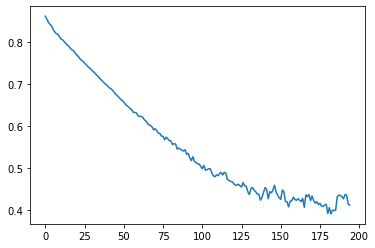

Epoch: 1, Loss: 0.4076:  10%|████████▋                                                                           | 195/1875 [01:43<12:40,  2.21it/s]

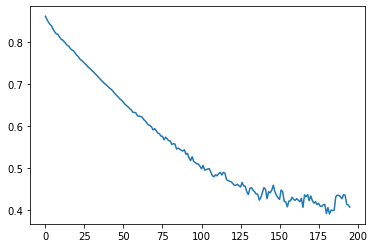

Epoch: 1, Loss: 0.4134:  10%|████████▊                                                                           | 196/1875 [01:44<12:58,  2.16it/s]

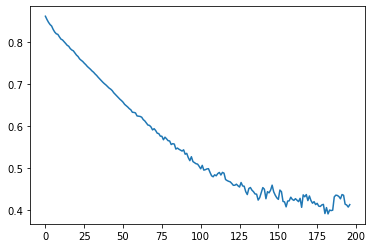

Epoch: 1, Loss: 0.4130:  11%|████████▊                                                                           | 197/1875 [01:44<12:56,  2.16it/s]

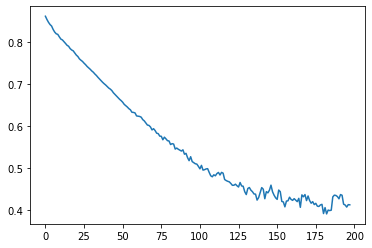

Epoch: 1, Loss: 0.4177:  11%|████████▊                                                                           | 198/1875 [01:44<12:18,  2.27it/s]

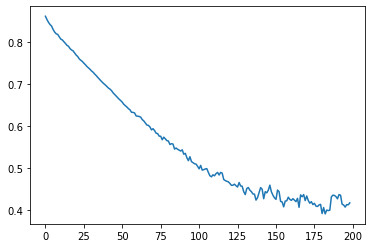

Epoch: 1, Loss: 0.4021:  11%|████████▉                                                                           | 199/1875 [01:45<12:39,  2.21it/s]

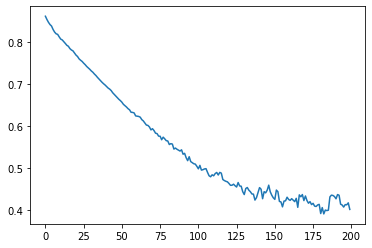

Epoch: 1, Loss: 0.4096:  11%|████████▉                                                                           | 200/1875 [01:45<12:40,  2.20it/s]

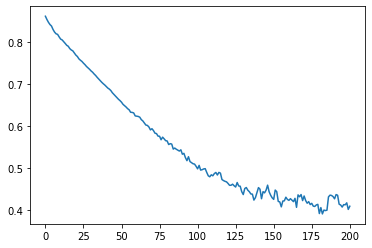

Epoch: 1, Loss: 0.3984:  11%|█████████                                                                           | 201/1875 [01:46<12:46,  2.18it/s]

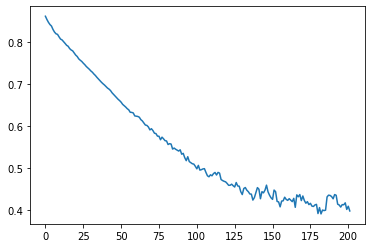

Epoch: 1, Loss: 0.3856:  11%|█████████                                                                           | 202/1875 [01:55<13:10,  2.12it/s]

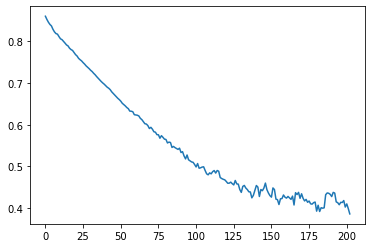

Epoch: 1, Loss: 0.3995:  11%|████████▉                                                                         | 203/1875 [01:56<1:23:20,  2.99s/it]

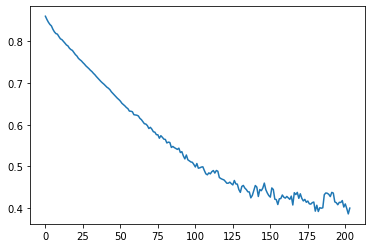

Epoch: 1, Loss: 0.3770:  11%|████████▉                                                                         | 204/1875 [01:57<1:07:44,  2.43s/it]

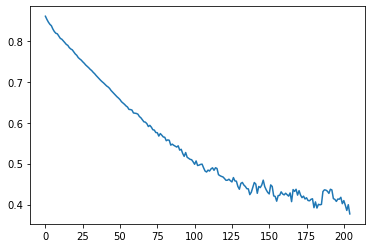

Epoch: 1, Loss: 0.3842:  11%|█████████▏                                                                          | 205/1875 [01:57<55:27,  1.99s/it]

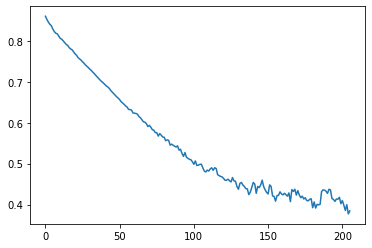

Epoch: 1, Loss: 0.4128:  11%|█████████▏                                                                          | 206/1875 [01:58<41:19,  1.49s/it]

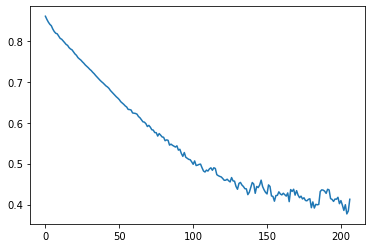

Epoch: 1, Loss: 0.3857:  11%|█████████▎                                                                          | 207/1875 [01:58<33:00,  1.19s/it]

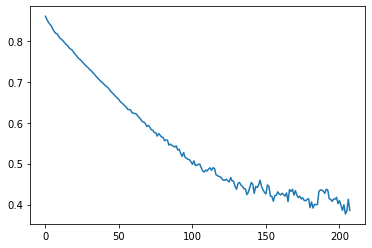

Epoch: 1, Loss: 0.3638:  11%|█████████▎                                                                          | 208/1875 [01:59<27:34,  1.01it/s]

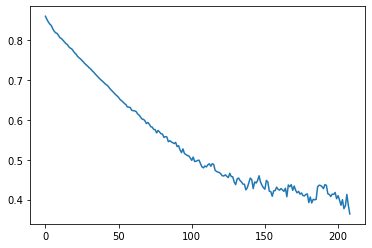

Epoch: 1, Loss: 0.3589:  11%|█████████▎                                                                          | 209/1875 [01:59<21:53,  1.27it/s]

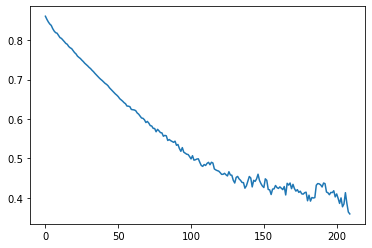

Epoch: 1, Loss: 0.3619:  11%|█████████▍                                                                          | 210/1875 [01:59<18:06,  1.53it/s]

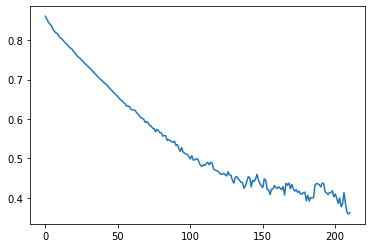

Epoch: 1, Loss: 0.3691:  11%|█████████▍                                                                          | 211/1875 [02:00<16:15,  1.71it/s]

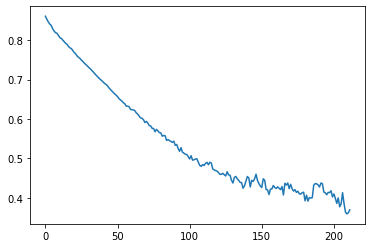

Epoch: 1, Loss: 0.3582:  11%|█████████▍                                                                          | 212/1875 [02:00<14:31,  1.91it/s]

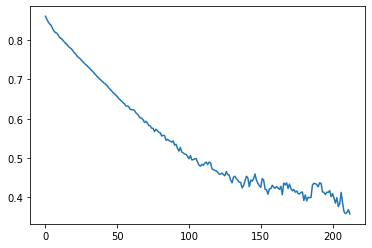

Epoch: 1, Loss: 0.3535:  11%|█████████▌                                                                          | 213/1875 [02:01<13:47,  2.01it/s]

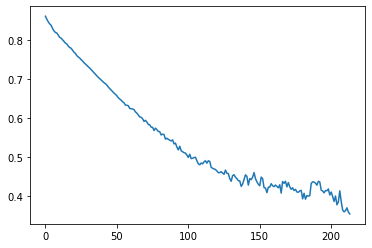

Epoch: 1, Loss: 0.3923:  11%|█████████▌                                                                          | 214/1875 [02:01<13:39,  2.03it/s]

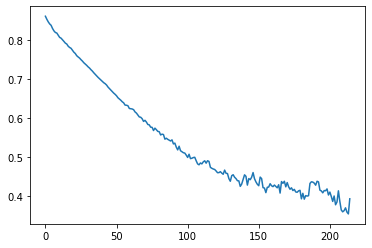

Epoch: 1, Loss: 0.4047:  11%|█████████▋                                                                          | 215/1875 [02:02<13:30,  2.05it/s]

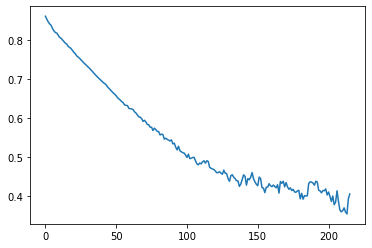

Epoch: 1, Loss: 0.3952:  12%|█████████▋                                                                          | 216/1875 [02:02<12:59,  2.13it/s]

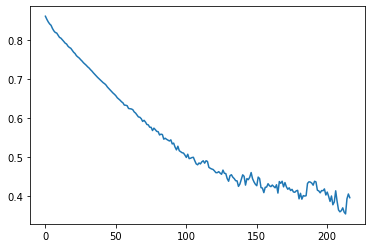

Epoch: 1, Loss: 0.4174:  12%|█████████▋                                                                          | 217/1875 [02:02<11:34,  2.39it/s]

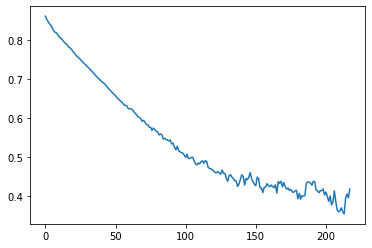

Epoch: 1, Loss: 0.3850:  12%|█████████▊                                                                          | 218/1875 [02:03<11:47,  2.34it/s]

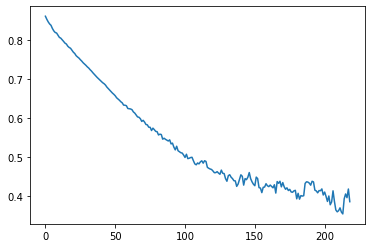

Epoch: 1, Loss: 0.3926:  12%|█████████▊                                                                          | 219/1875 [02:04<14:49,  1.86it/s]

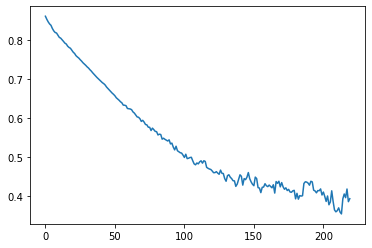

Epoch: 1, Loss: 0.3710:  12%|█████████▊                                                                          | 220/1875 [02:04<16:47,  1.64it/s]

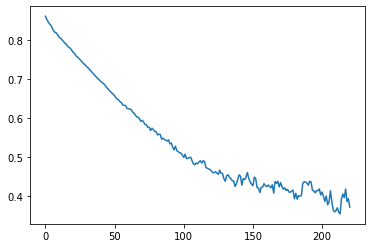

Epoch: 1, Loss: 0.3681:  12%|█████████▉                                                                          | 221/1875 [02:05<14:11,  1.94it/s]

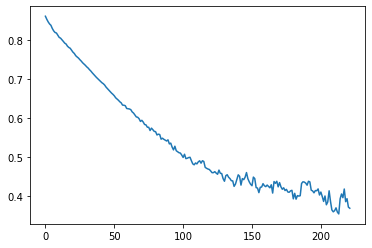

Epoch: 1, Loss: 0.3726:  12%|█████████▉                                                                          | 222/1875 [02:05<13:43,  2.01it/s]

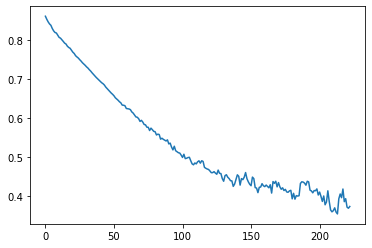

Epoch: 1, Loss: 0.3671:  12%|█████████▉                                                                          | 223/1875 [02:05<12:17,  2.24it/s]

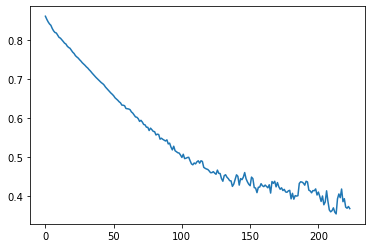

Epoch: 1, Loss: 0.3724:  12%|██████████                                                                          | 224/1875 [02:06<12:26,  2.21it/s]

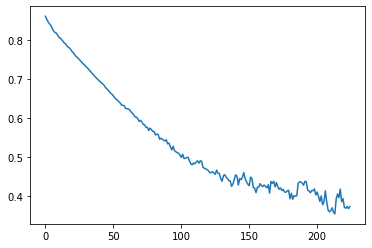

Epoch: 1, Loss: 0.3547:  12%|██████████                                                                          | 225/1875 [02:07<15:55,  1.73it/s]

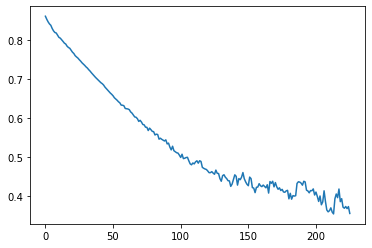

Epoch: 1, Loss: 0.3668:  12%|██████████                                                                          | 226/1875 [02:08<19:52,  1.38it/s]

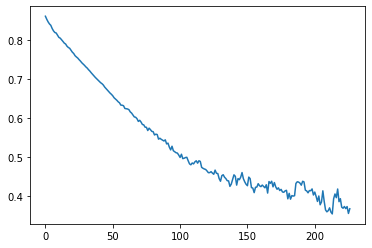

Epoch: 1, Loss: 0.3726:  12%|██████████▏                                                                         | 227/1875 [02:08<16:22,  1.68it/s]

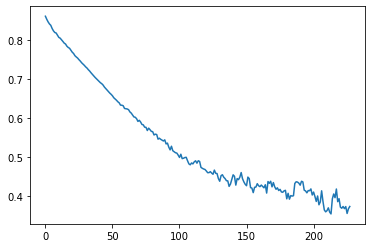

Epoch: 1, Loss: 0.3448:  12%|██████████▏                                                                         | 228/1875 [02:08<14:13,  1.93it/s]

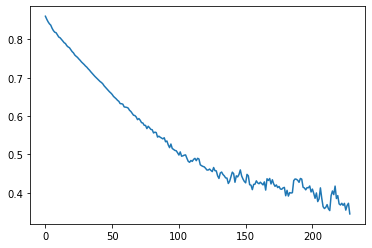

Epoch: 1, Loss: 0.3442:  12%|██████████▎                                                                         | 229/1875 [02:09<12:47,  2.14it/s]

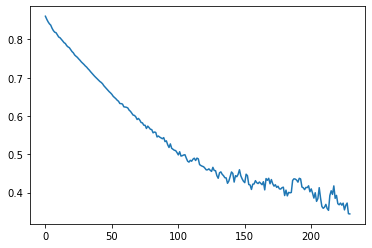

Epoch: 1, Loss: 0.3524:  12%|██████████▎                                                                         | 230/1875 [02:09<12:18,  2.23it/s]

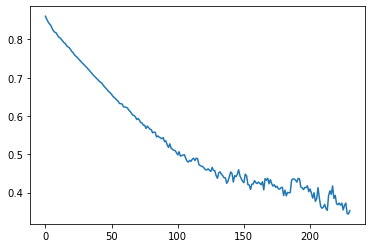

Epoch: 1, Loss: 0.3570:  12%|██████████▎                                                                         | 231/1875 [02:09<11:43,  2.34it/s]

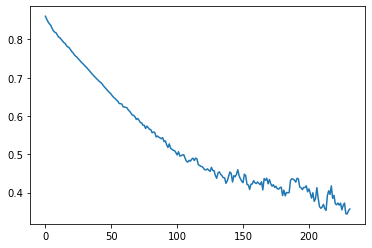

Epoch: 1, Loss: 0.3605:  12%|██████████▍                                                                         | 232/1875 [02:10<10:56,  2.50it/s]

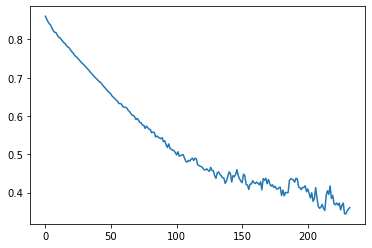

Epoch: 1, Loss: 0.3745:  12%|██████████▍                                                                         | 233/1875 [02:10<10:44,  2.55it/s]

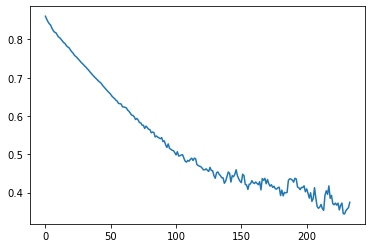

Epoch: 1, Loss: 0.3581:  12%|██████████▍                                                                         | 234/1875 [02:10<10:11,  2.69it/s]

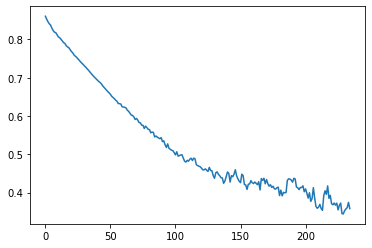

Epoch: 1, Loss: 0.3650:  13%|██████████▌                                                                         | 235/1875 [02:11<09:48,  2.79it/s]

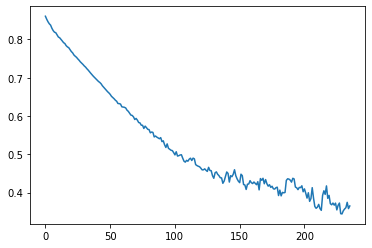

Epoch: 1, Loss: 0.3593:  13%|██████████▌                                                                         | 236/1875 [02:11<09:14,  2.96it/s]

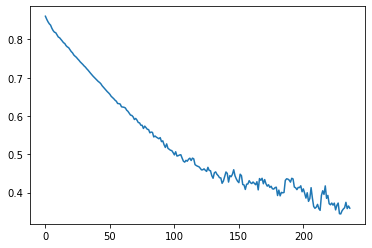

Epoch: 1, Loss: 0.3663:  13%|██████████▌                                                                         | 237/1875 [02:11<09:08,  2.99it/s]

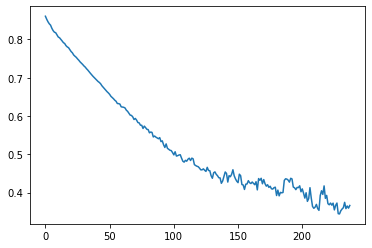

Epoch: 1, Loss: 0.3827:  13%|██████████▋                                                                         | 238/1875 [02:12<08:57,  3.05it/s]

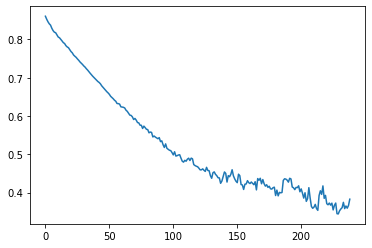

Epoch: 1, Loss: 0.3773:  13%|██████████▋                                                                         | 239/1875 [02:12<09:07,  2.99it/s]

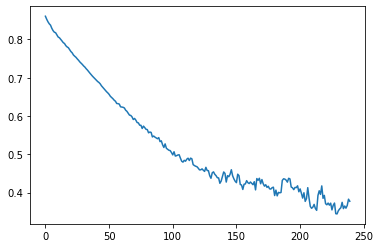

Epoch: 1, Loss: 0.3815:  13%|██████████▊                                                                         | 240/1875 [02:12<08:54,  3.06it/s]

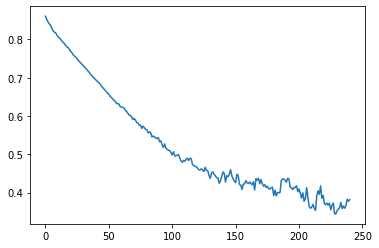

Epoch: 1, Loss: 0.3699:  13%|██████████▊                                                                         | 241/1875 [02:13<08:32,  3.19it/s]

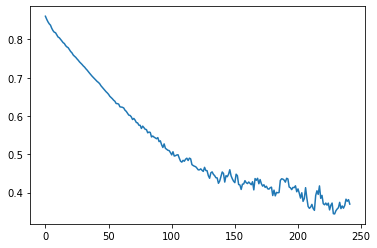

Epoch: 1, Loss: 0.3604:  13%|██████████▊                                                                         | 242/1875 [02:13<08:24,  3.24it/s]

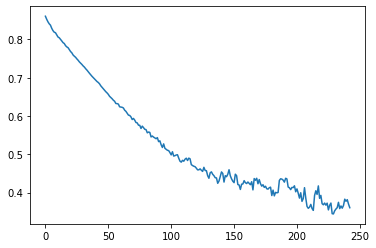

Epoch: 1, Loss: 0.3937:  13%|██████████▉                                                                         | 243/1875 [02:13<08:18,  3.27it/s]

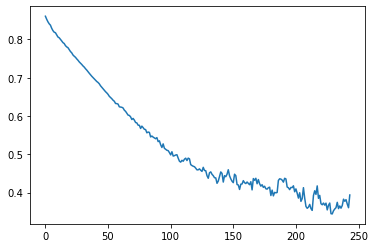

Epoch: 1, Loss: 0.3776:  13%|██████████▉                                                                         | 244/1875 [02:14<08:26,  3.22it/s]

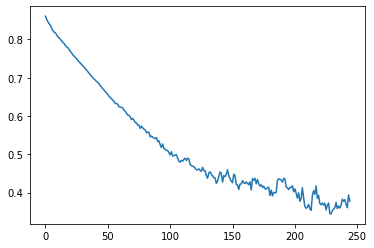

Epoch: 1, Loss: 0.4001:  13%|██████████▉                                                                         | 245/1875 [02:14<08:17,  3.28it/s]

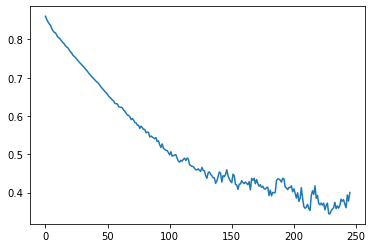

Epoch: 1, Loss: 0.4176:  13%|███████████                                                                         | 246/1875 [02:14<08:42,  3.12it/s]

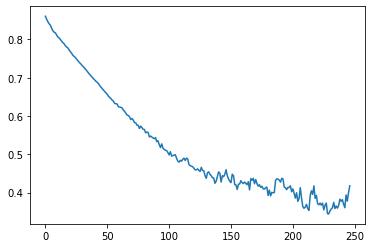

Epoch: 1, Loss: 0.4013:  13%|███████████                                                                         | 247/1875 [02:15<08:19,  3.26it/s]

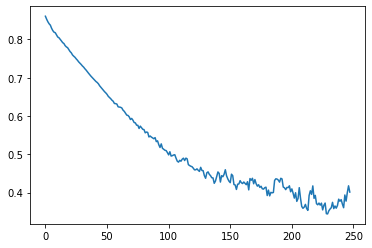

Epoch: 1, Loss: 0.3984:  13%|███████████                                                                         | 248/1875 [02:15<09:04,  2.99it/s]

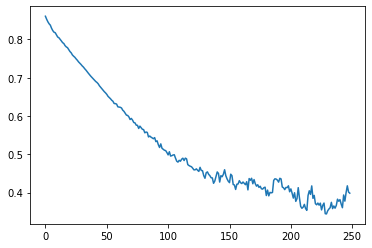

Epoch: 1, Loss: 0.4044:  13%|███████████▏                                                                        | 249/1875 [02:15<09:49,  2.76it/s]

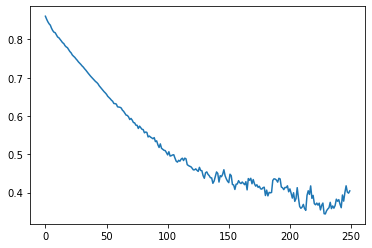

Epoch: 1, Loss: 0.4185:  13%|███████████▏                                                                        | 250/1875 [02:16<09:37,  2.81it/s]

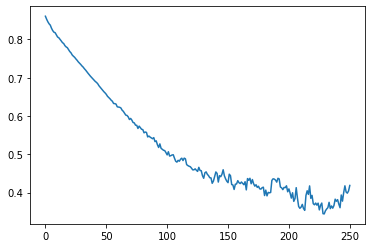

Epoch: 1, Loss: 0.3826:  13%|███████████▏                                                                        | 251/1875 [02:16<08:59,  3.01it/s]

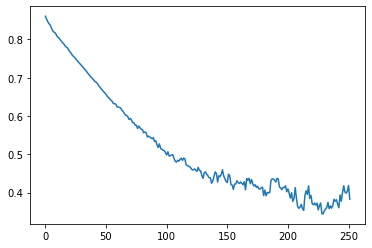

Epoch: 1, Loss: 0.4016:  13%|███████████▎                                                                        | 252/1875 [02:16<09:04,  2.98it/s]

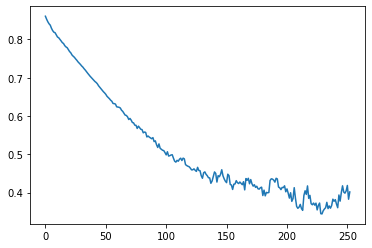

Epoch: 1, Loss: 0.3772:  13%|███████████▎                                                                        | 253/1875 [02:17<08:48,  3.07it/s]

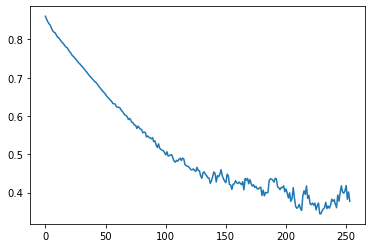

Epoch: 1, Loss: 0.3707:  14%|███████████▍                                                                        | 254/1875 [02:17<12:30,  2.16it/s]

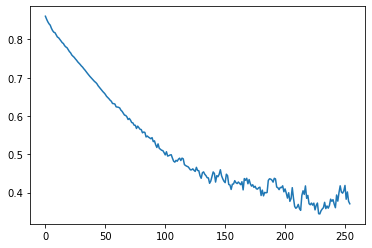

Epoch: 1, Loss: 0.3420:  14%|███████████▍                                                                        | 255/1875 [02:18<11:47,  2.29it/s]

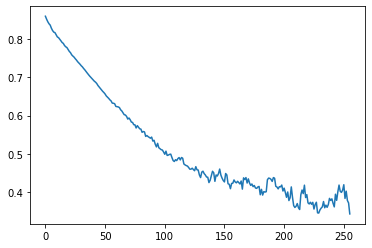

Epoch: 1, Loss: 0.3552:  14%|███████████▍                                                                        | 256/1875 [02:18<12:52,  2.10it/s]

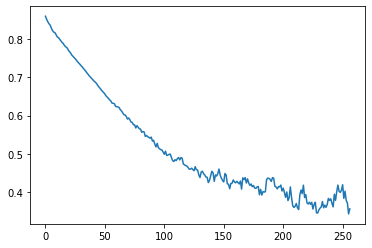

Epoch: 1, Loss: 0.3676:  14%|███████████▌                                                                        | 257/1875 [02:19<11:26,  2.36it/s]

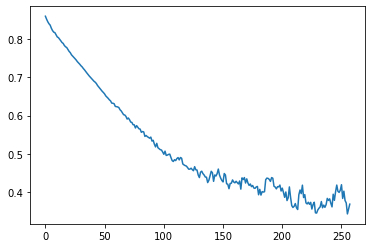

Epoch: 1, Loss: 0.4076:  14%|███████████▌                                                                        | 258/1875 [02:19<10:26,  2.58it/s]

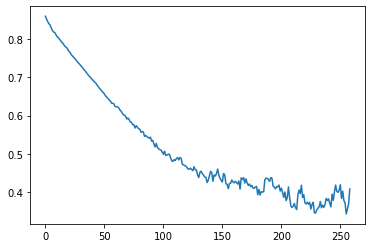

Epoch: 1, Loss: 0.3820:  14%|███████████▌                                                                        | 259/1875 [02:19<10:27,  2.58it/s]

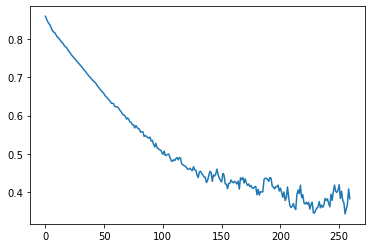

Epoch: 1, Loss: 0.3755:  14%|███████████▋                                                                        | 260/1875 [02:20<09:37,  2.80it/s]

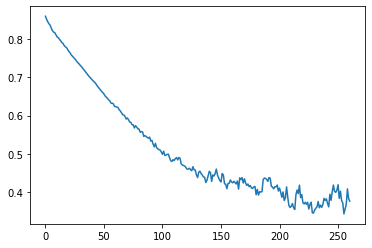

Epoch: 1, Loss: 0.3932:  14%|███████████▋                                                                        | 261/1875 [02:20<09:06,  2.95it/s]

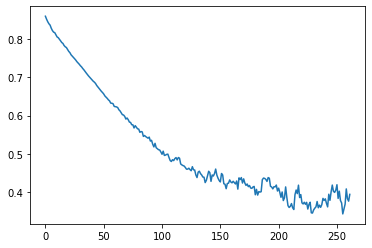

Epoch: 1, Loss: 0.3853:  14%|███████████▋                                                                        | 262/1875 [02:20<08:48,  3.05it/s]

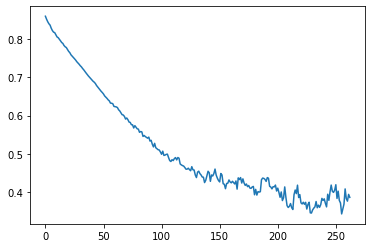

Epoch: 1, Loss: 0.3670:  14%|███████████▊                                                                        | 263/1875 [02:20<08:39,  3.10it/s]

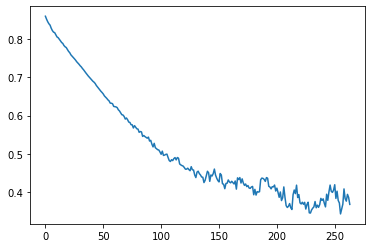

Epoch: 1, Loss: 0.4276:  14%|███████████▊                                                                        | 264/1875 [02:21<08:35,  3.12it/s]

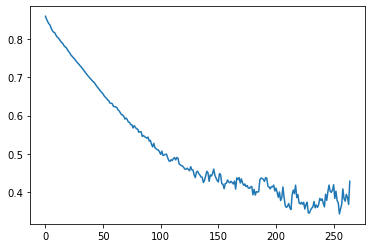

Epoch: 1, Loss: 0.4369:  14%|███████████▊                                                                        | 265/1875 [02:21<08:25,  3.19it/s]

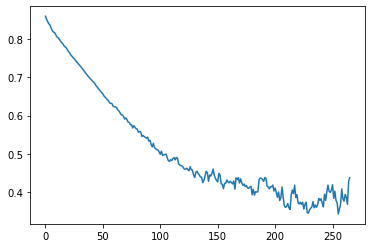

Epoch: 1, Loss: 0.4157:  14%|███████████▉                                                                        | 266/1875 [02:21<08:22,  3.20it/s]

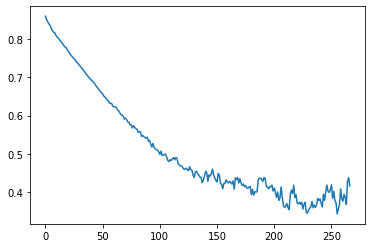

Epoch: 1, Loss: 0.4119:  14%|███████████▉                                                                        | 267/1875 [02:22<08:04,  3.32it/s]

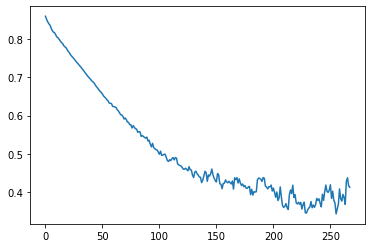

Epoch: 1, Loss: 0.4045:  14%|████████████                                                                        | 268/1875 [02:22<08:29,  3.15it/s]

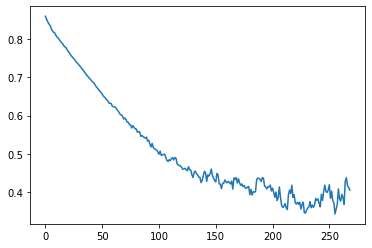

Epoch: 1, Loss: 0.4079:  14%|████████████                                                                        | 269/1875 [02:22<08:19,  3.22it/s]

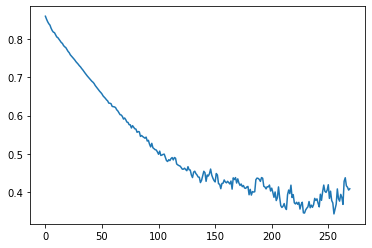

Epoch: 1, Loss: 0.4106:  14%|████████████                                                                        | 270/1875 [02:23<08:09,  3.28it/s]

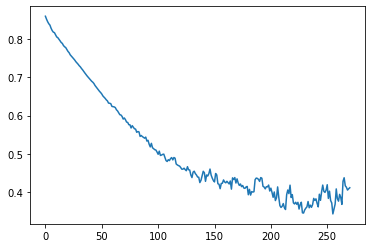

Epoch: 1, Loss: 0.4181:  14%|████████████▏                                                                       | 271/1875 [02:24<14:22,  1.86it/s]

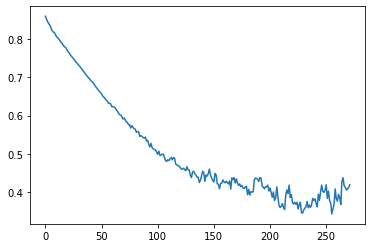

Epoch: 1, Loss: 0.3941:  15%|████████████▏                                                                       | 272/1875 [02:24<13:28,  1.98it/s]

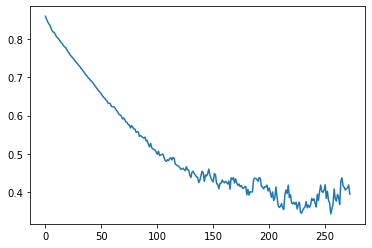

Epoch: 1, Loss: 0.3780:  15%|████████████▏                                                                       | 273/1875 [02:25<12:22,  2.16it/s]

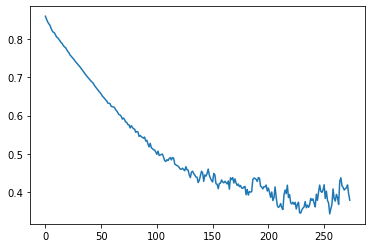

Epoch: 1, Loss: 0.3788:  15%|████████████▎                                                                       | 274/1875 [02:25<11:38,  2.29it/s]

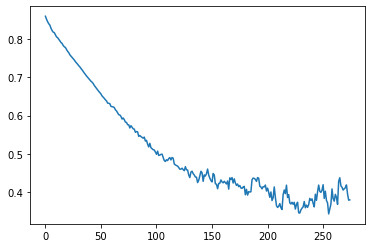

Epoch: 1, Loss: 0.3814:  15%|████████████▎                                                                       | 275/1875 [02:25<11:30,  2.32it/s]

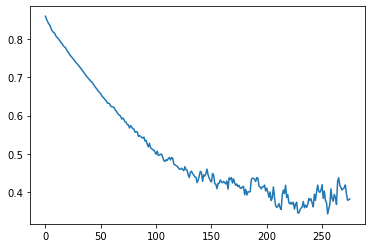

Epoch: 1, Loss: 0.3634:  15%|████████████▎                                                                       | 276/1875 [02:26<10:34,  2.52it/s]

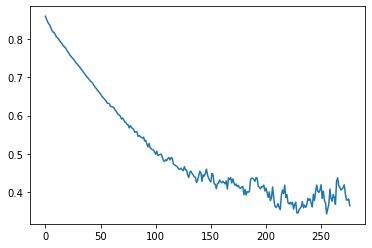

Epoch: 1, Loss: 0.3666:  15%|████████████▍                                                                       | 277/1875 [02:26<11:32,  2.31it/s]

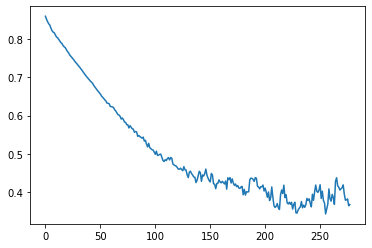

Epoch: 1, Loss: 0.3803:  15%|████████████▍                                                                       | 278/1875 [02:27<10:44,  2.48it/s]

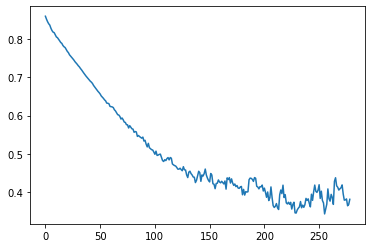

Epoch: 1, Loss: 0.3879:  15%|████████████▍                                                                       | 279/1875 [02:27<11:17,  2.36it/s]

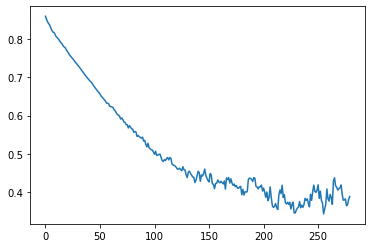

Epoch: 1, Loss: 0.3680:  15%|████████████▌                                                                       | 280/1875 [02:27<10:33,  2.52it/s]

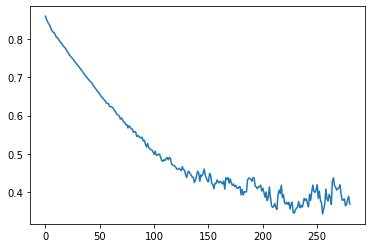

Epoch: 1, Loss: 0.3704:  15%|████████████▌                                                                       | 281/1875 [02:28<09:49,  2.70it/s]

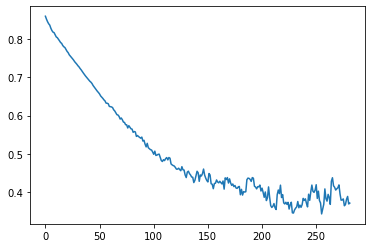

Epoch: 1, Loss: 0.3810:  15%|████████████▋                                                                       | 282/1875 [02:28<09:13,  2.88it/s]

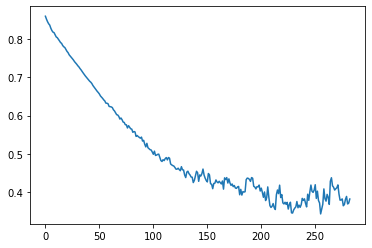

Epoch: 1, Loss: 0.3727:  15%|████████████▋                                                                       | 283/1875 [02:28<09:31,  2.78it/s]

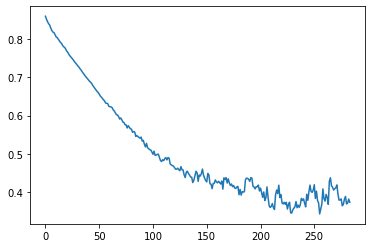

Epoch: 1, Loss: 0.3528:  15%|████████████▋                                                                       | 284/1875 [02:29<08:55,  2.97it/s]

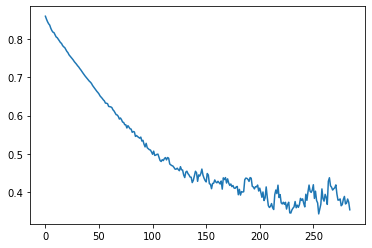

Epoch: 1, Loss: 0.3513:  15%|████████████▊                                                                       | 285/1875 [02:29<09:22,  2.82it/s]

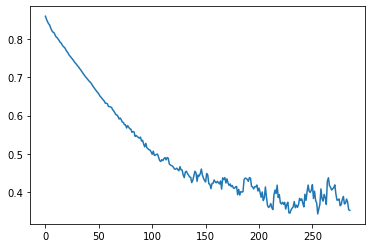

Epoch: 1, Loss: 0.3639:  15%|████████████▊                                                                       | 286/1875 [02:29<08:59,  2.94it/s]

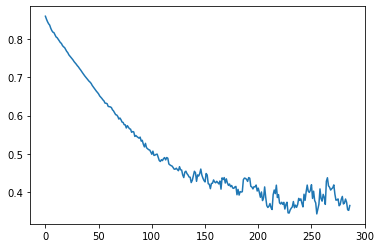

Epoch: 1, Loss: 0.3680:  15%|████████████▊                                                                       | 287/1875 [02:30<08:42,  3.04it/s]

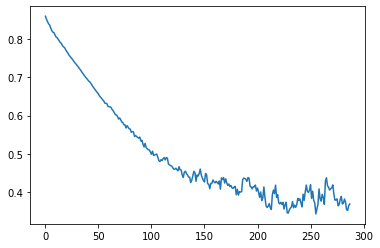

Epoch: 1, Loss: 0.3347:  15%|████████████▉                                                                       | 288/1875 [02:30<08:32,  3.09it/s]

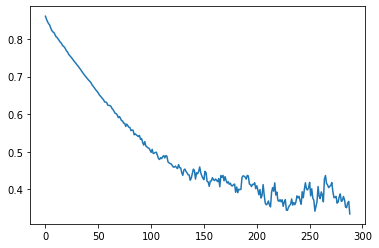

Epoch: 1, Loss: 0.3471:  15%|████████████▉                                                                       | 289/1875 [02:30<08:16,  3.19it/s]

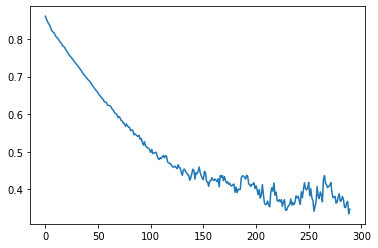

Epoch: 1, Loss: 0.3814:  15%|████████████▉                                                                       | 290/1875 [02:30<08:30,  3.11it/s]

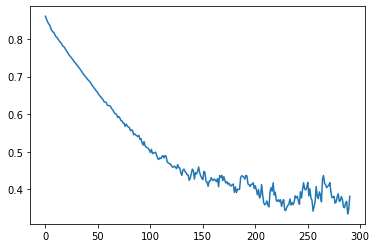

Epoch: 1, Loss: 0.3806:  16%|█████████████                                                                       | 291/1875 [02:31<08:19,  3.17it/s]

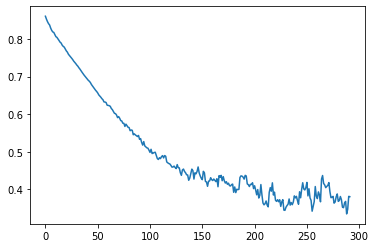

Epoch: 1, Loss: 0.3862:  16%|█████████████                                                                       | 292/1875 [02:31<08:06,  3.25it/s]

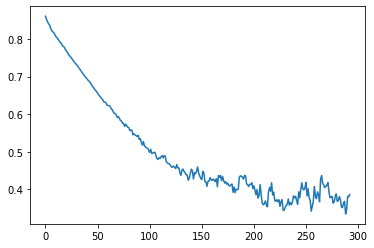

Epoch: 1, Loss: 0.3867:  16%|█████████████▏                                                                      | 293/1875 [02:31<08:10,  3.23it/s]

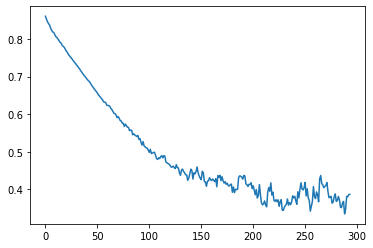

Epoch: 1, Loss: 0.3869:  16%|█████████████▏                                                                      | 294/1875 [02:32<08:00,  3.29it/s]

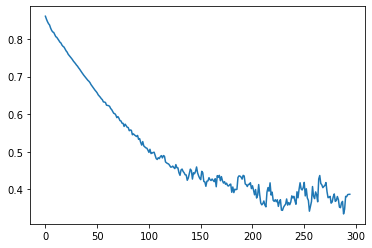

Epoch: 1, Loss: 0.3861:  16%|█████████████▏                                                                      | 295/1875 [02:32<07:52,  3.35it/s]

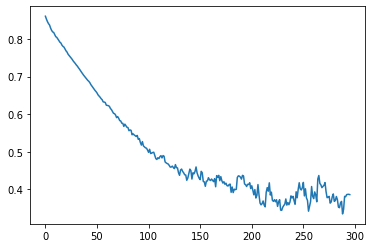

Epoch: 1, Loss: 0.3925:  16%|█████████████▎                                                                      | 296/1875 [02:32<07:55,  3.32it/s]

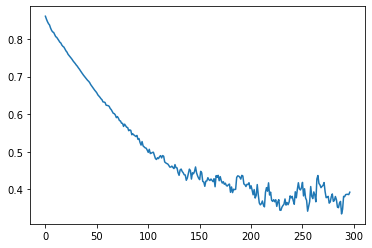

Epoch: 1, Loss: 0.4035:  16%|█████████████▎                                                                      | 297/1875 [02:33<07:56,  3.31it/s]

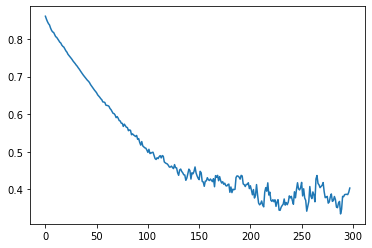

Epoch: 1, Loss: 0.3614:  16%|█████████████▎                                                                      | 298/1875 [02:33<07:48,  3.36it/s]

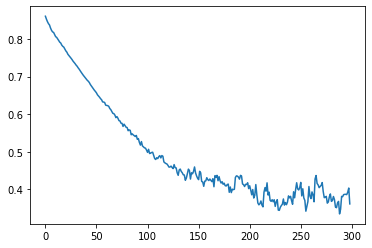

Epoch: 1, Loss: 0.3523:  16%|█████████████▍                                                                      | 299/1875 [02:33<07:56,  3.31it/s]

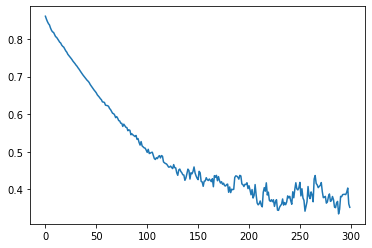

Epoch: 1, Loss: 0.3651:  16%|█████████████▍                                                                      | 300/1875 [02:34<08:19,  3.15it/s]

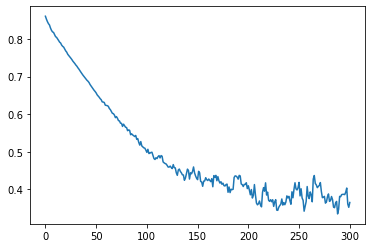

Epoch: 1, Loss: 0.3764:  16%|█████████████▍                                                                      | 301/1875 [02:35<14:28,  1.81it/s]

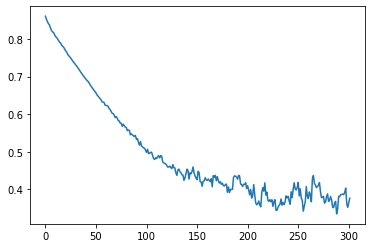

Epoch: 1, Loss: 0.3896:  16%|█████████████▌                                                                      | 302/1875 [02:35<12:48,  2.05it/s]

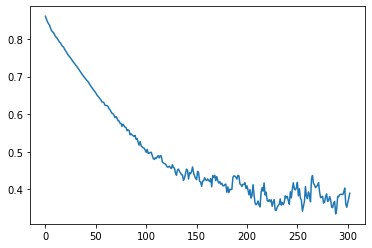

Epoch: 1, Loss: 0.3913:  16%|█████████████▌                                                                      | 303/1875 [02:35<11:38,  2.25it/s]

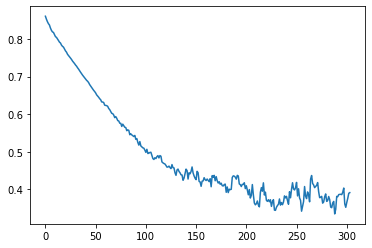

Epoch: 1, Loss: 0.3819:  16%|█████████████▌                                                                      | 304/1875 [02:36<10:28,  2.50it/s]

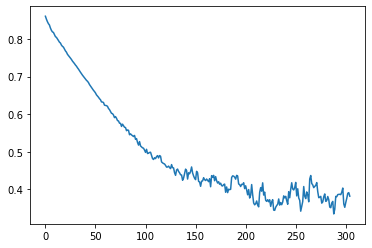

Epoch: 1, Loss: 0.3832:  16%|█████████████▋                                                                      | 305/1875 [02:36<09:43,  2.69it/s]

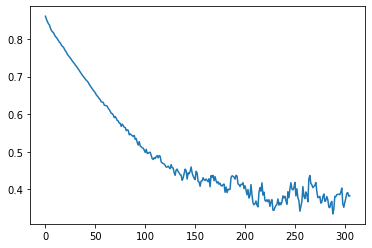

Epoch: 1, Loss: 0.3656:  16%|█████████████▋                                                                      | 306/1875 [02:36<09:08,  2.86it/s]

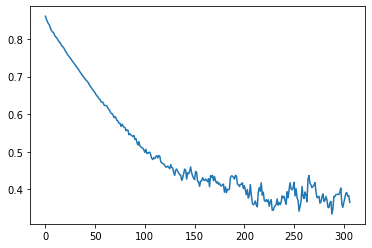

Epoch: 1, Loss: 0.3751:  16%|█████████████▊                                                                      | 307/1875 [02:36<08:43,  3.00it/s]

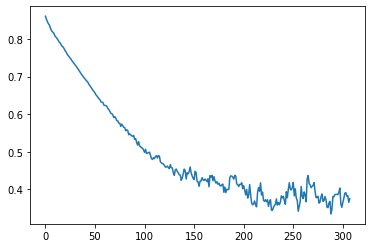

Epoch: 1, Loss: 0.3848:  16%|█████████████▊                                                                      | 308/1875 [02:37<08:35,  3.04it/s]

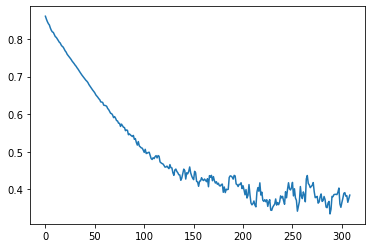

Epoch: 1, Loss: 0.3577:  16%|█████████████▊                                                                      | 309/1875 [02:38<13:30,  1.93it/s]

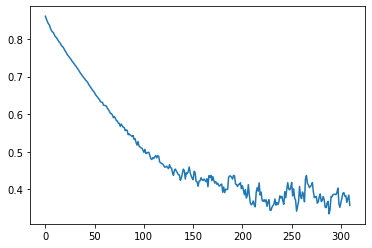

Epoch: 1, Loss: 0.3623:  17%|█████████████▉                                                                      | 310/1875 [02:39<14:15,  1.83it/s]

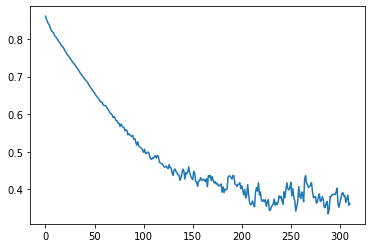

Epoch: 1, Loss: 0.3710:  17%|█████████████▉                                                                      | 311/1875 [02:39<16:11,  1.61it/s]

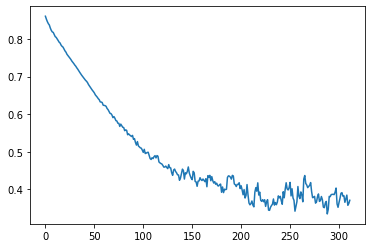

Epoch: 1, Loss: 0.3888:  17%|█████████████▉                                                                      | 312/1875 [02:40<13:40,  1.91it/s]

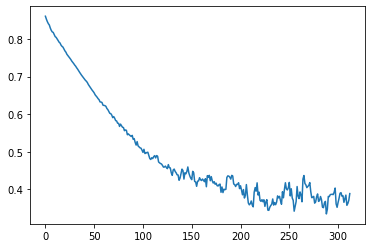

Epoch: 1, Loss: 0.3939:  17%|██████████████                                                                      | 313/1875 [02:40<13:06,  1.99it/s]

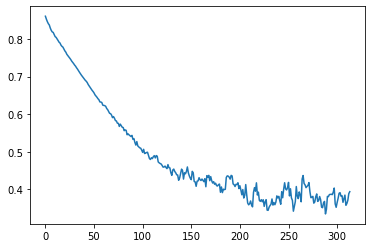

Epoch: 1, Loss: 0.3692:  17%|██████████████                                                                      | 314/1875 [02:40<12:02,  2.16it/s]

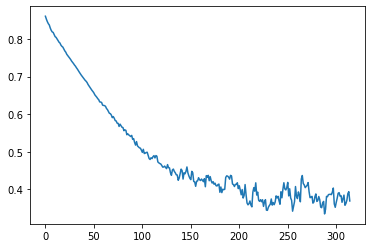

Epoch: 1, Loss: 0.3624:  17%|██████████████                                                                      | 315/1875 [02:41<12:07,  2.15it/s]

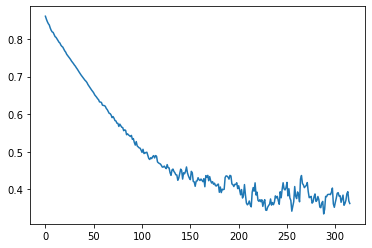

Epoch: 1, Loss: 0.3580:  17%|██████████████▏                                                                     | 316/1875 [02:41<12:10,  2.13it/s]

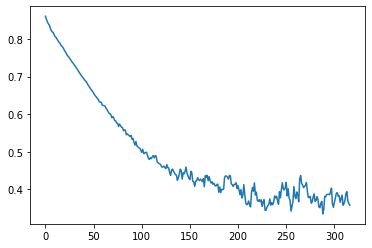

Epoch: 1, Loss: 0.3438:  17%|██████████████▏                                                                     | 317/1875 [02:42<10:59,  2.36it/s]

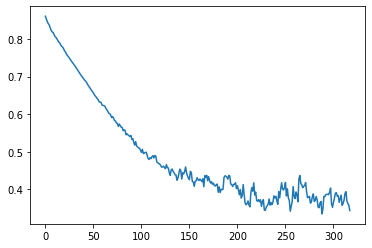

Epoch: 1, Loss: 0.4021:  17%|██████████████▏                                                                     | 318/1875 [02:42<10:05,  2.57it/s]

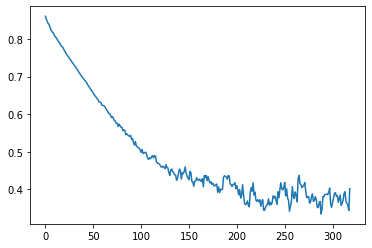

Epoch: 1, Loss: 0.4679:  17%|██████████████▎                                                                     | 319/1875 [02:42<09:30,  2.73it/s]

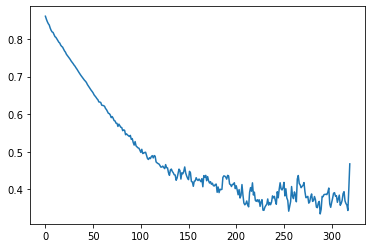

Epoch: 1, Loss: 0.4439:  17%|██████████████▎                                                                     | 320/1875 [02:42<08:58,  2.89it/s]

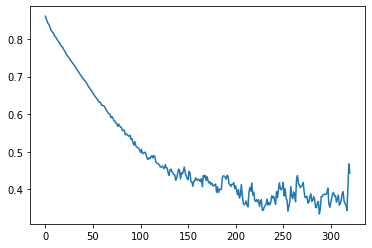

Epoch: 1, Loss: 0.4426:  17%|██████████████▍                                                                     | 321/1875 [02:43<08:28,  3.06it/s]

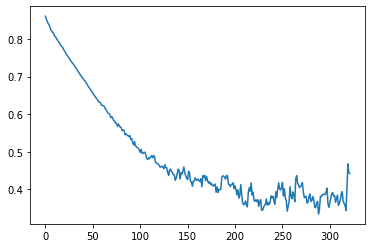

Epoch: 1, Loss: 0.4209:  17%|██████████████▍                                                                     | 322/1875 [02:43<09:09,  2.83it/s]

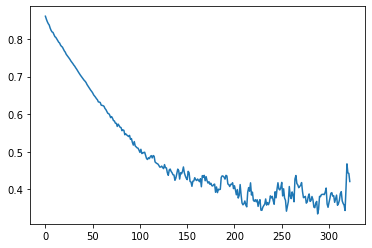

Epoch: 1, Loss: 0.3906:  17%|██████████████▍                                                                     | 323/1875 [02:43<08:51,  2.92it/s]

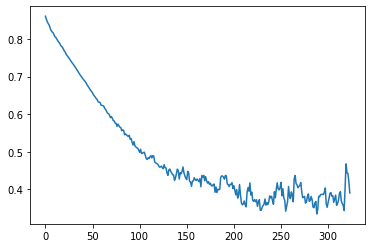

Epoch: 1, Loss: 0.3977:  17%|██████████████▌                                                                     | 324/1875 [02:44<08:30,  3.04it/s]

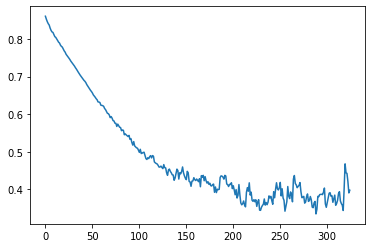

Epoch: 1, Loss: 0.3900:  17%|██████████████▌                                                                     | 325/1875 [02:44<08:08,  3.17it/s]

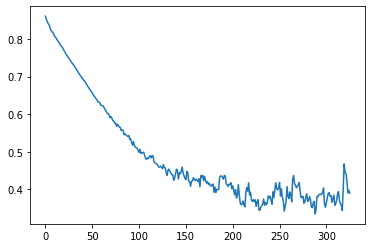

Epoch: 1, Loss: 0.3944:  17%|██████████████▌                                                                     | 326/1875 [02:44<08:05,  3.19it/s]

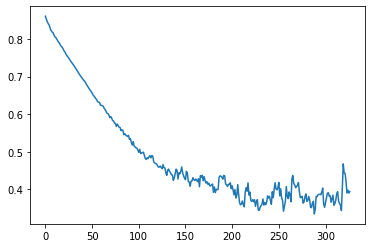

Epoch: 1, Loss: 0.4156:  17%|██████████████▋                                                                     | 327/1875 [02:45<07:59,  3.23it/s]

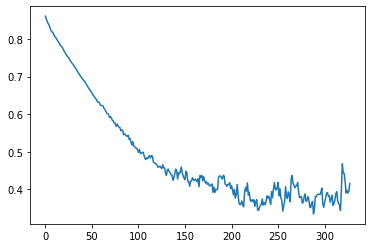

Epoch: 1, Loss: 0.3931:  17%|██████████████▋                                                                     | 328/1875 [02:45<07:54,  3.26it/s]

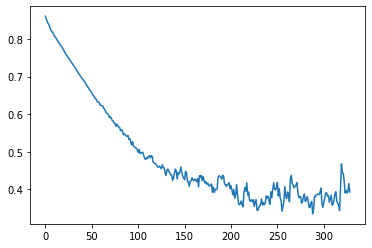

Epoch: 1, Loss: 0.3867:  18%|██████████████▋                                                                     | 329/1875 [02:45<07:58,  3.23it/s]

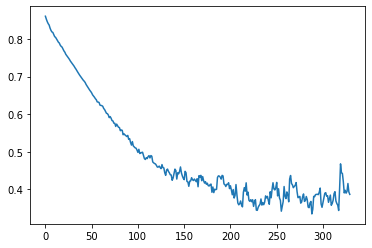

Epoch: 1, Loss: 0.3796:  18%|██████████████▊                                                                     | 330/1875 [02:46<07:50,  3.28it/s]

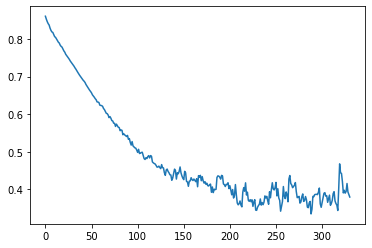

Epoch: 1, Loss: 0.3731:  18%|██████████████▊                                                                     | 331/1875 [02:46<07:47,  3.30it/s]

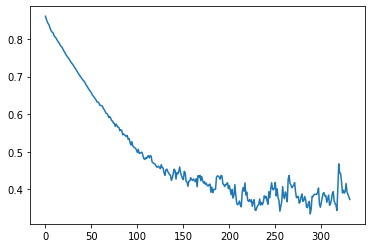

Epoch: 1, Loss: 0.3550:  18%|██████████████▊                                                                     | 332/1875 [02:46<07:45,  3.31it/s]

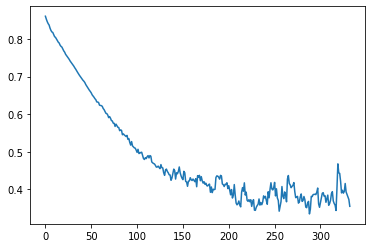

Epoch: 1, Loss: 0.3495:  18%|██████████████▉                                                                     | 333/1875 [02:46<07:45,  3.32it/s]

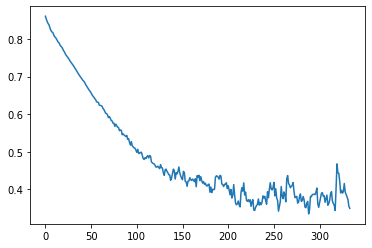

Epoch: 1, Loss: 0.3524:  18%|██████████████▉                                                                     | 334/1875 [02:47<07:38,  3.36it/s]

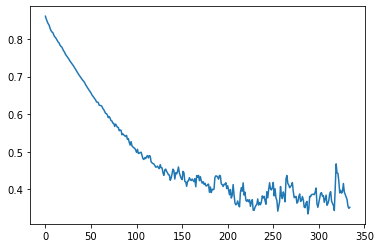

Epoch: 1, Loss: 0.3835:  18%|███████████████                                                                     | 335/1875 [02:47<07:40,  3.35it/s]

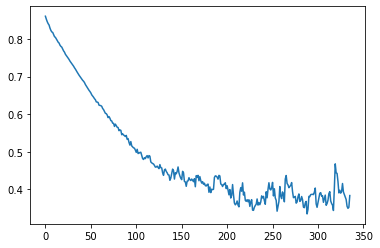

Epoch: 1, Loss: 0.3618:  18%|███████████████                                                                     | 336/1875 [02:47<07:37,  3.37it/s]

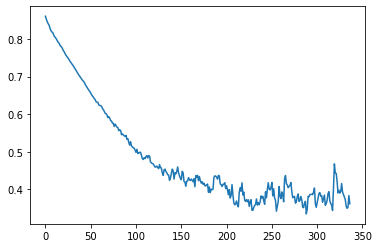

Epoch: 1, Loss: 0.4021:  18%|███████████████                                                                     | 337/1875 [02:48<07:51,  3.26it/s]

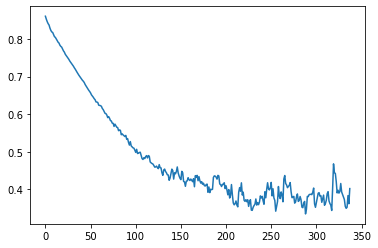

Epoch: 1, Loss: 0.3799:  18%|███████████████▏                                                                    | 338/1875 [02:48<07:49,  3.27it/s]

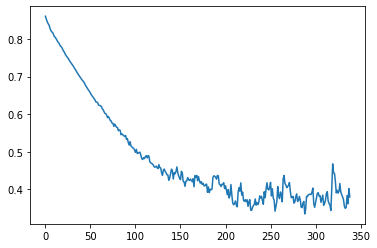

Epoch: 1, Loss: 0.3885:  18%|███████████████▏                                                                    | 339/1875 [02:48<07:45,  3.30it/s]

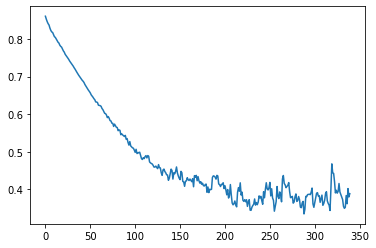

Epoch: 1, Loss: 0.3762:  18%|███████████████▏                                                                    | 340/1875 [02:50<07:44,  3.31it/s]

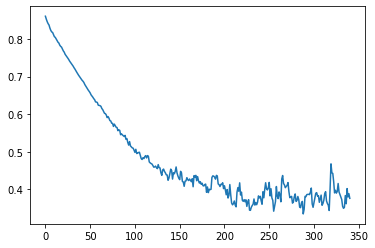

Epoch: 1, Loss: 0.3826:  18%|███████████████▎                                                                    | 341/1875 [02:51<22:11,  1.15it/s]

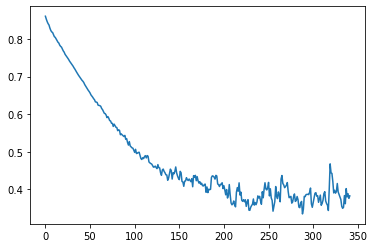

Epoch: 1, Loss: 0.3953:  18%|███████████████▎                                                                    | 342/1875 [02:52<19:54,  1.28it/s]

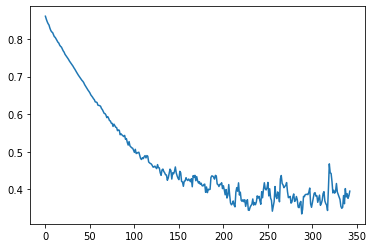

Epoch: 1, Loss: 0.3954:  18%|███████████████▎                                                                    | 343/1875 [02:52<20:07,  1.27it/s]

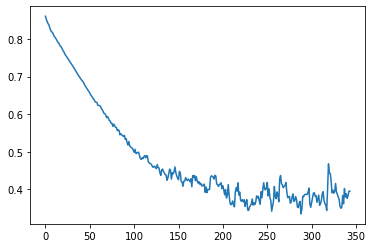

Epoch: 1, Loss: 0.4251:  18%|███████████████▍                                                                    | 344/1875 [02:53<17:52,  1.43it/s]

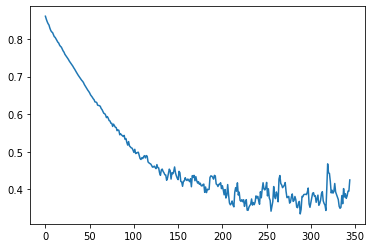

Epoch: 1, Loss: 0.3734:  18%|███████████████▍                                                                    | 345/1875 [02:53<15:56,  1.60it/s]

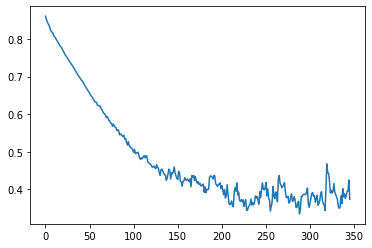

Epoch: 1, Loss: 0.3773:  18%|███████████████▌                                                                    | 346/1875 [02:55<14:32,  1.75it/s]

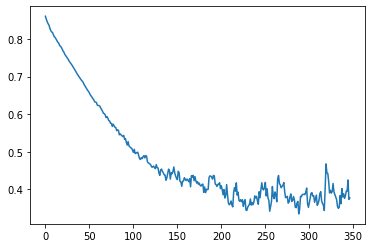

Epoch: 1, Loss: 0.3671:  19%|███████████████▌                                                                    | 347/1875 [02:55<22:30,  1.13it/s]

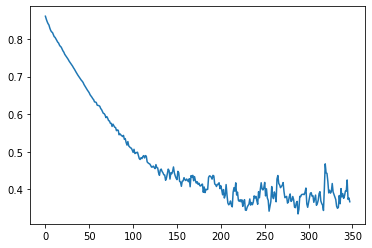

Epoch: 1, Loss: 0.3696:  19%|███████████████▌                                                                    | 348/1875 [02:56<19:32,  1.30it/s]

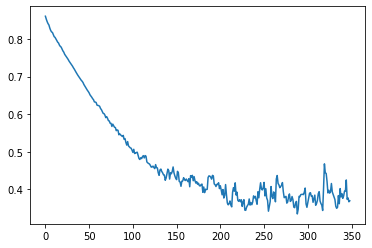

Epoch: 1, Loss: 0.3875:  19%|███████████████▋                                                                    | 349/1875 [02:56<16:00,  1.59it/s]

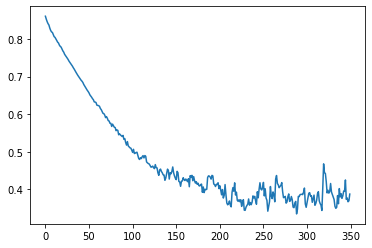

Epoch: 1, Loss: 0.3774:  19%|███████████████▋                                                                    | 350/1875 [02:56<13:52,  1.83it/s]

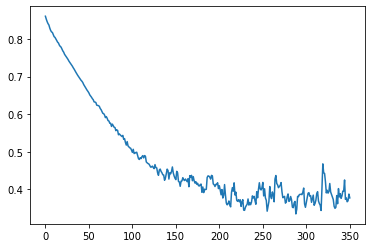

Epoch: 1, Loss: 0.3704:  19%|███████████████▋                                                                    | 351/1875 [02:57<12:09,  2.09it/s]

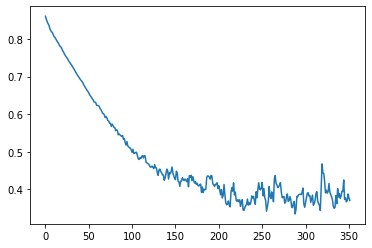

Epoch: 1, Loss: 0.3589:  19%|███████████████▊                                                                    | 352/1875 [02:57<11:29,  2.21it/s]

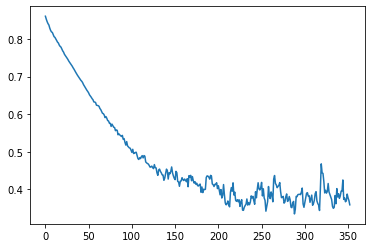

Epoch: 1, Loss: 0.3703:  19%|███████████████▊                                                                    | 353/1875 [02:57<10:23,  2.44it/s]

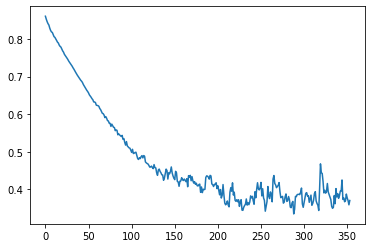

Epoch: 1, Loss: 0.3738:  19%|███████████████▊                                                                    | 354/1875 [02:58<09:42,  2.61it/s]

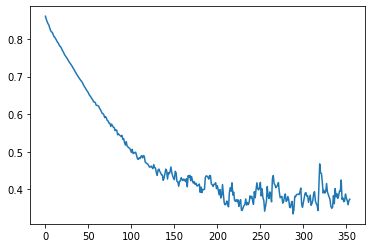

Epoch: 1, Loss: 0.3791:  19%|███████████████▉                                                                    | 355/1875 [02:58<08:57,  2.83it/s]

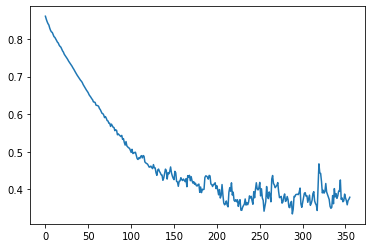

Epoch: 1, Loss: 0.3657:  19%|███████████████▉                                                                    | 356/1875 [02:58<08:58,  2.82it/s]

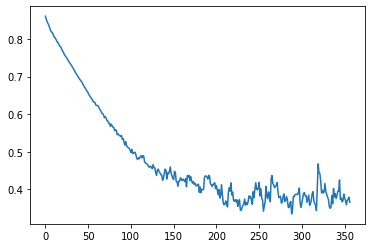

Epoch: 1, Loss: 0.3707:  19%|███████████████▉                                                                    | 357/1875 [02:59<08:32,  2.96it/s]

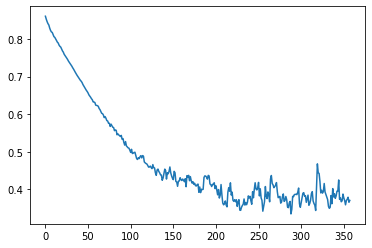

Epoch: 1, Loss: 0.3784:  19%|████████████████                                                                    | 358/1875 [02:59<08:13,  3.07it/s]

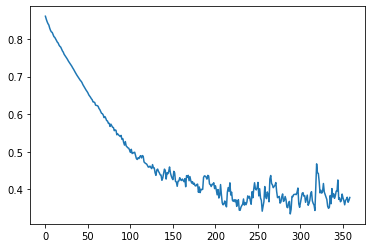

Epoch: 1, Loss: 0.3580:  19%|████████████████                                                                    | 359/1875 [02:59<08:01,  3.15it/s]

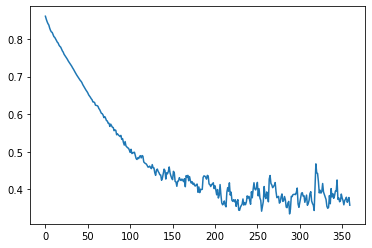

Epoch: 1, Loss: 0.3593:  19%|████████████████▏                                                                   | 360/1875 [03:00<07:53,  3.20it/s]

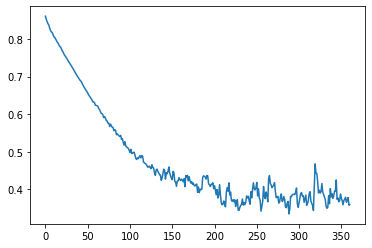

Epoch: 1, Loss: 0.3737:  19%|████████████████▏                                                                   | 361/1875 [03:00<07:52,  3.20it/s]

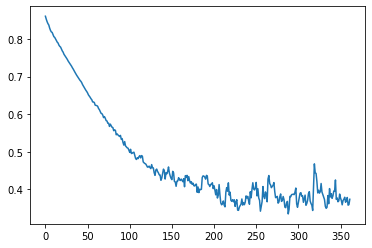

Epoch: 1, Loss: 0.3698:  19%|████████████████▏                                                                   | 362/1875 [03:00<07:48,  3.23it/s]

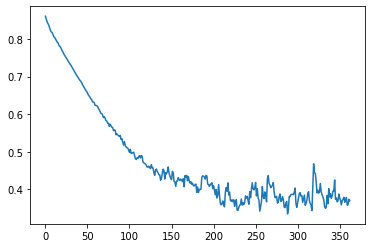

Epoch: 1, Loss: 0.3661:  19%|████████████████▎                                                                   | 363/1875 [03:00<07:57,  3.17it/s]

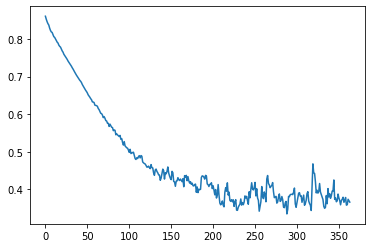

Epoch: 1, Loss: 0.3690:  19%|████████████████▎                                                                   | 364/1875 [03:01<07:52,  3.20it/s]

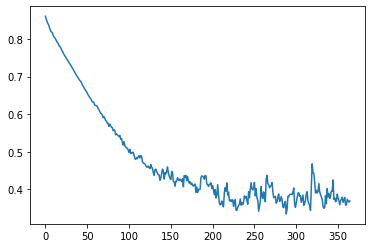

Epoch: 1, Loss: 0.3738:  19%|████████████████▎                                                                   | 365/1875 [03:01<07:47,  3.23it/s]

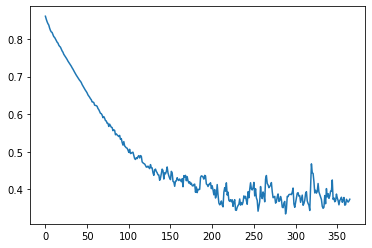

Epoch: 1, Loss: 0.3616:  20%|████████████████▍                                                                   | 366/1875 [03:01<08:15,  3.05it/s]

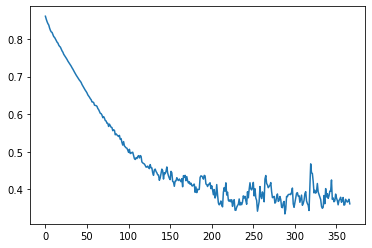

Epoch: 1, Loss: 0.3653:  20%|████████████████▍                                                                   | 367/1875 [03:02<08:10,  3.08it/s]

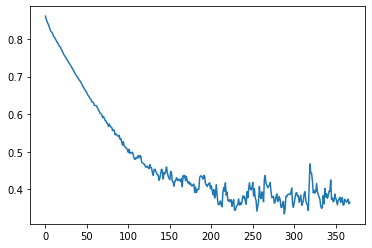

Epoch: 1, Loss: 0.3821:  20%|████████████████▍                                                                   | 368/1875 [03:02<08:51,  2.83it/s]

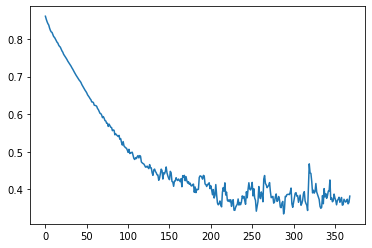

Epoch: 1, Loss: 0.3570:  20%|████████████████▌                                                                   | 369/1875 [03:03<08:45,  2.87it/s]

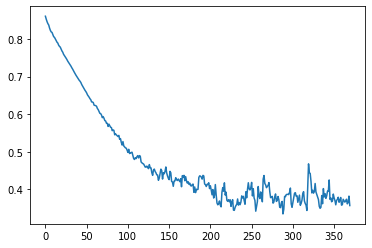

Epoch: 1, Loss: 0.3724:  20%|████████████████▌                                                                   | 370/1875 [03:03<08:25,  2.97it/s]

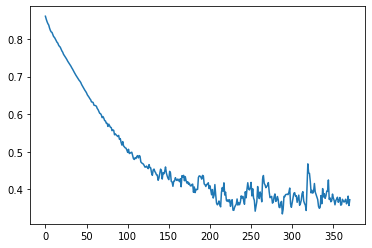

Epoch: 1, Loss: 0.3625:  20%|████████████████▌                                                                   | 371/1875 [03:03<08:14,  3.04it/s]

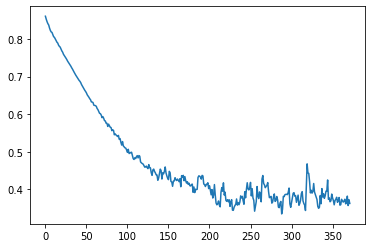

Epoch: 1, Loss: 0.3685:  20%|████████████████▋                                                                   | 372/1875 [03:03<08:05,  3.10it/s]

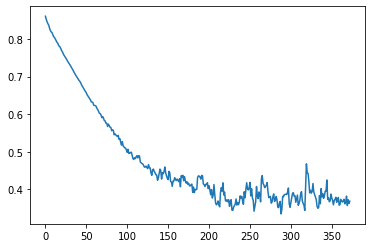

Epoch: 1, Loss: 0.3525:  20%|████████████████▋                                                                   | 373/1875 [03:04<07:56,  3.15it/s]

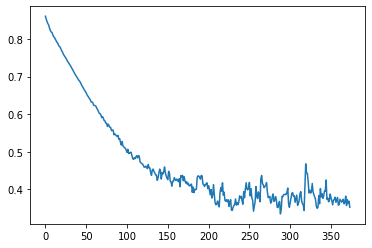

Epoch: 1, Loss: 0.4107:  20%|████████████████▊                                                                   | 374/1875 [03:04<08:44,  2.86it/s]

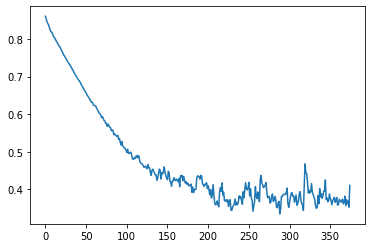

Epoch: 1, Loss: 0.3887:  20%|████████████████▊                                                                   | 375/1875 [03:05<08:27,  2.95it/s]

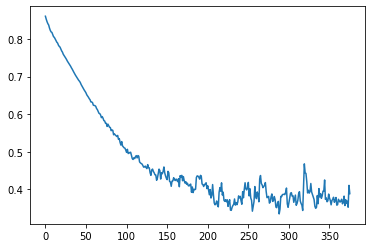

Epoch: 1, Loss: 0.3710:  20%|████████████████▊                                                                   | 376/1875 [03:06<14:56,  1.67it/s]

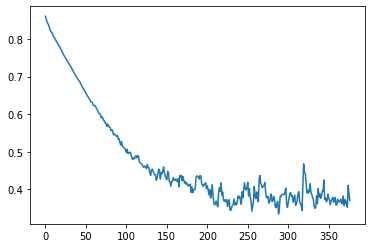

Epoch: 1, Loss: 0.3908:  20%|████████████████▉                                                                   | 377/1875 [03:06<13:04,  1.91it/s]

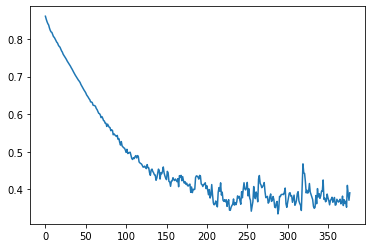

Epoch: 1, Loss: 0.3880:  20%|████████████████▉                                                                   | 378/1875 [03:06<11:46,  2.12it/s]

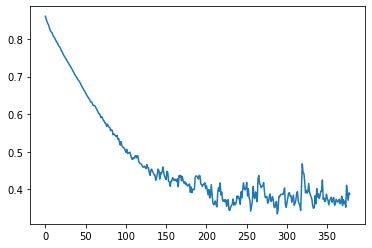

Epoch: 1, Loss: 0.3716:  20%|████████████████▉                                                                   | 379/1875 [03:07<10:49,  2.30it/s]

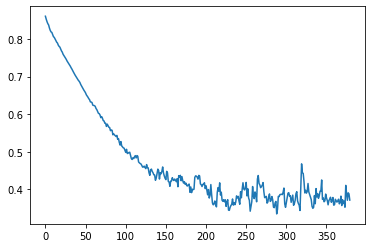

Epoch: 1, Loss: 0.3855:  20%|█████████████████                                                                   | 380/1875 [03:07<10:44,  2.32it/s]

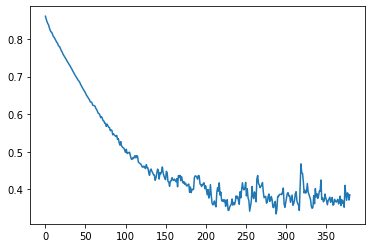

Epoch: 1, Loss: 0.3885:  20%|█████████████████                                                                   | 381/1875 [03:08<10:16,  2.42it/s]

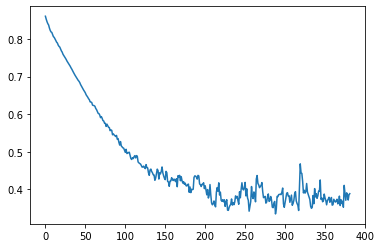

Epoch: 1, Loss: 0.3790:  20%|█████████████████                                                                   | 382/1875 [03:08<10:06,  2.46it/s]

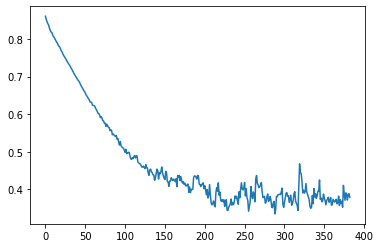

Epoch: 1, Loss: 0.4029:  20%|█████████████████▏                                                                  | 383/1875 [03:08<09:15,  2.68it/s]

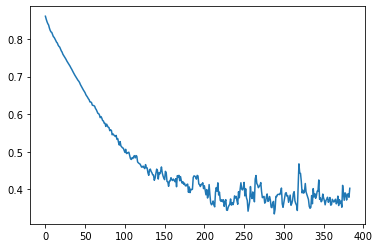

Epoch: 1, Loss: 0.3789:  20%|█████████████████▏                                                                  | 384/1875 [03:09<08:39,  2.87it/s]

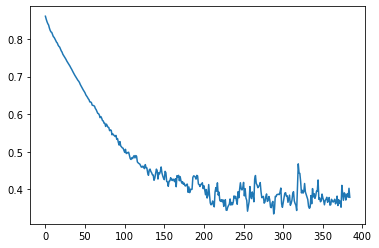

Epoch: 1, Loss: 0.3799:  21%|█████████████████▏                                                                  | 385/1875 [03:09<08:26,  2.94it/s]

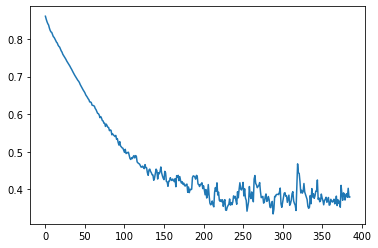

Epoch: 1, Loss: 0.3795:  21%|█████████████████▎                                                                  | 386/1875 [03:09<08:10,  3.04it/s]

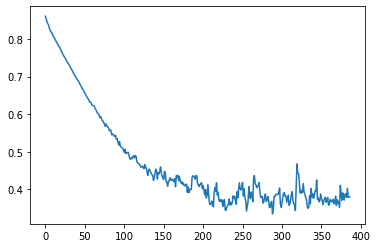

Epoch: 1, Loss: 0.3840:  21%|█████████████████▎                                                                  | 387/1875 [03:10<08:11,  3.03it/s]

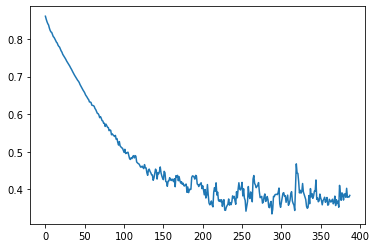

Epoch: 1, Loss: 0.3892:  21%|█████████████████▍                                                                  | 388/1875 [03:11<12:27,  1.99it/s]

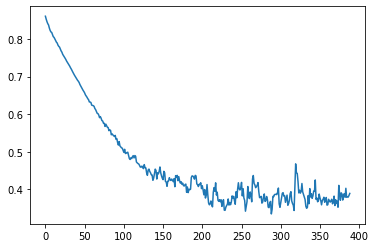

Epoch: 1, Loss: 0.3948:  21%|█████████████████▍                                                                  | 389/1875 [03:11<15:09,  1.63it/s]

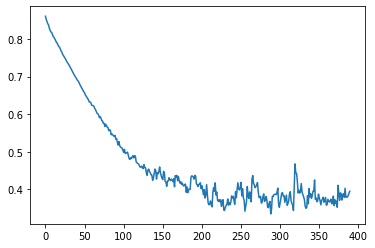

Epoch: 1, Loss: 0.3891:  21%|█████████████████▍                                                                  | 390/1875 [03:12<12:53,  1.92it/s]

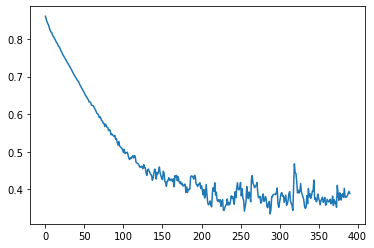

Epoch: 1, Loss: 0.3821:  21%|█████████████████▌                                                                  | 391/1875 [03:12<11:24,  2.17it/s]

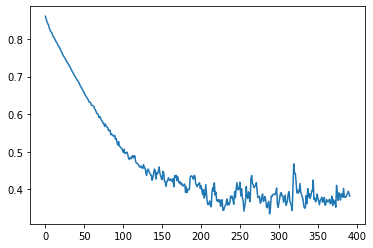

Epoch: 1, Loss: 0.3981:  21%|█████████████████▌                                                                  | 392/1875 [03:12<10:24,  2.38it/s]

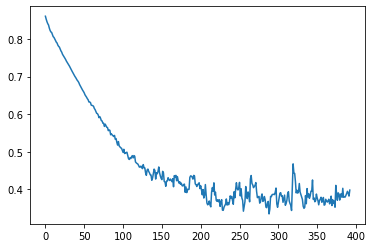

Epoch: 1, Loss: 0.3774:  21%|█████████████████▌                                                                  | 393/1875 [03:12<09:34,  2.58it/s]

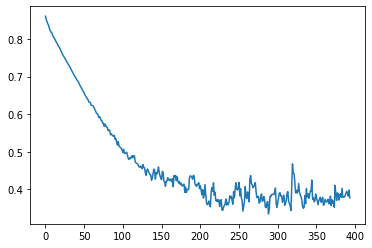

Epoch: 1, Loss: 0.4015:  21%|█████████████████▋                                                                  | 394/1875 [03:13<08:58,  2.75it/s]

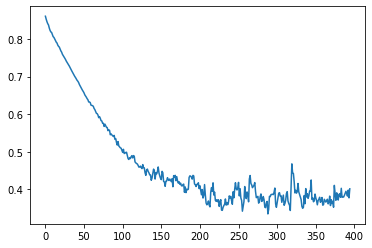

Epoch: 1, Loss: 0.3750:  21%|█████████████████▋                                                                  | 395/1875 [03:13<08:29,  2.90it/s]

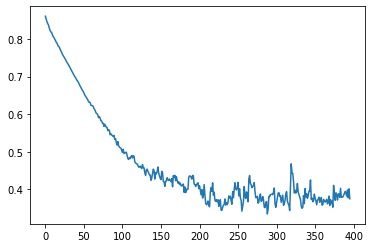

Epoch: 1, Loss: 0.3898:  21%|█████████████████▋                                                                  | 396/1875 [03:13<08:26,  2.92it/s]

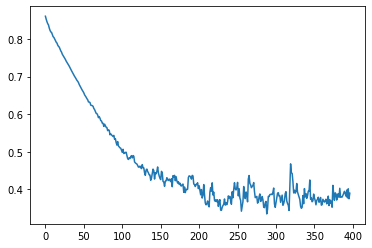

Epoch: 1, Loss: 0.3633:  21%|█████████████████▊                                                                  | 397/1875 [03:14<08:06,  3.04it/s]

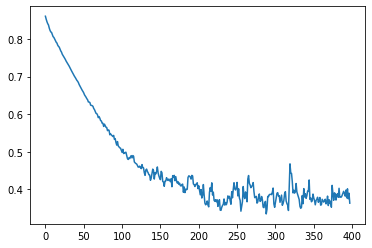

Epoch: 1, Loss: 0.3559:  21%|█████████████████▊                                                                  | 398/1875 [03:14<08:00,  3.07it/s]

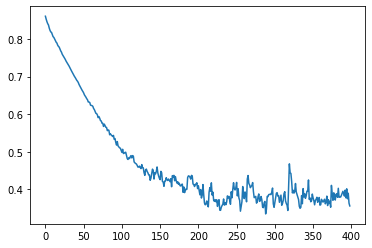

Epoch: 1, Loss: 0.3563:  21%|█████████████████▉                                                                  | 399/1875 [03:14<07:44,  3.17it/s]

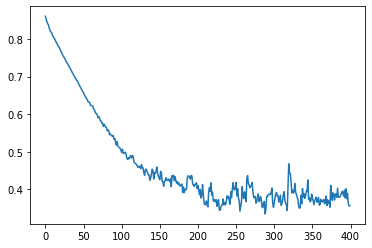

Epoch: 1, Loss: 0.3407:  21%|█████████████████▉                                                                  | 400/1875 [03:15<07:38,  3.22it/s]

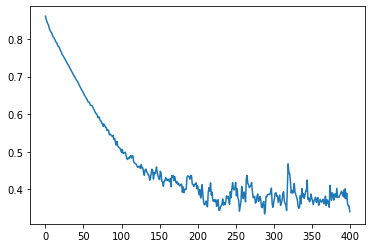

Epoch: 1, Loss: 0.3416:  21%|█████████████████▉                                                                  | 401/1875 [03:15<08:04,  3.04it/s]

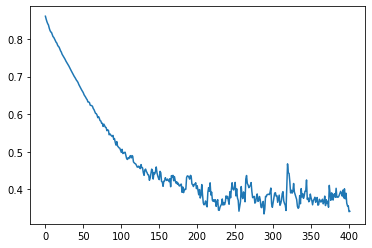

Epoch: 1, Loss: 0.3580:  21%|██████████████████                                                                  | 402/1875 [03:15<07:55,  3.09it/s]

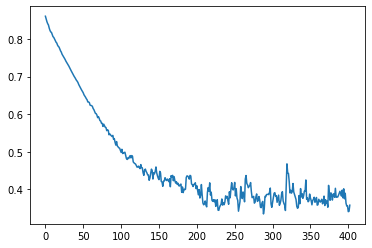

Epoch: 1, Loss: 0.3920:  21%|██████████████████                                                                  | 403/1875 [03:16<07:52,  3.12it/s]

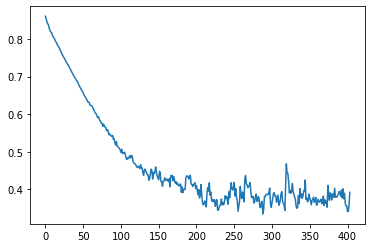

Epoch: 1, Loss: 0.4011:  22%|██████████████████                                                                  | 404/1875 [03:16<07:45,  3.16it/s]

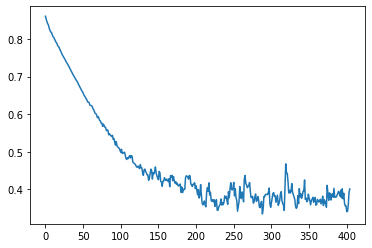

Epoch: 1, Loss: 0.4079:  22%|██████████████████▏                                                                 | 405/1875 [03:16<08:07,  3.01it/s]

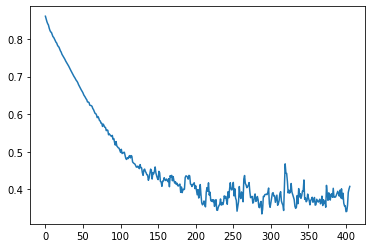

Epoch: 1, Loss: 0.3947:  22%|██████████████████▏                                                                 | 406/1875 [03:17<08:01,  3.05it/s]

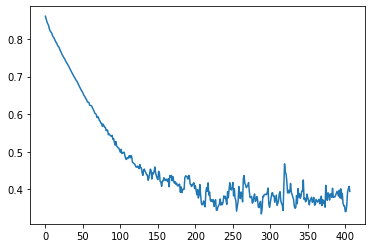

Epoch: 1, Loss: 0.4065:  22%|██████████████████▏                                                                 | 407/1875 [03:17<07:46,  3.15it/s]

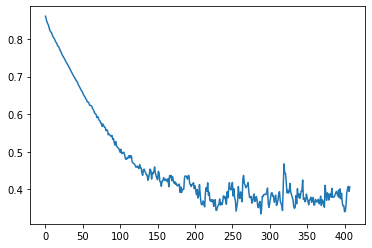

Epoch: 1, Loss: 0.4340:  22%|██████████████████▎                                                                 | 408/1875 [03:17<07:55,  3.08it/s]

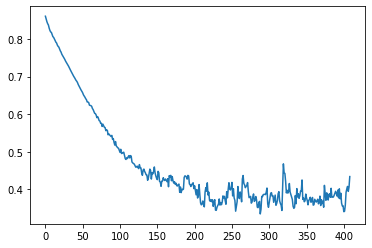

Epoch: 1, Loss: 0.4115:  22%|██████████████████▎                                                                 | 409/1875 [03:18<08:14,  2.97it/s]

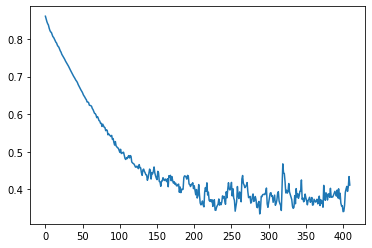

Epoch: 1, Loss: 0.3847:  22%|██████████████████▎                                                                 | 410/1875 [03:18<07:57,  3.07it/s]

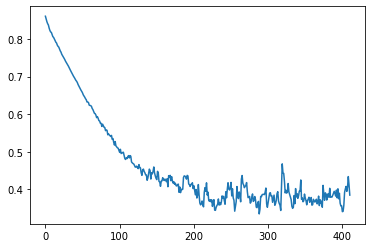

Epoch: 1, Loss: 0.3858:  22%|██████████████████▍                                                                 | 411/1875 [03:18<07:45,  3.15it/s]

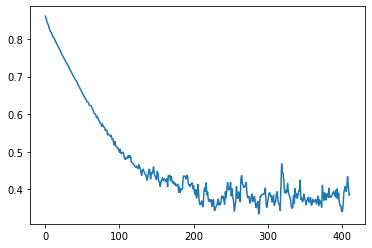

Epoch: 1, Loss: 0.3966:  22%|██████████████████▍                                                                 | 412/1875 [03:19<07:37,  3.20it/s]

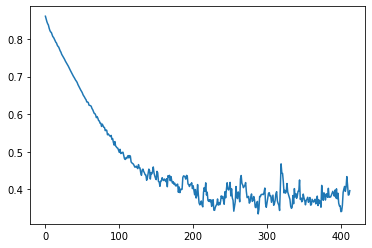

Epoch: 1, Loss: 0.3879:  22%|██████████████████▌                                                                 | 413/1875 [03:19<07:28,  3.26it/s]

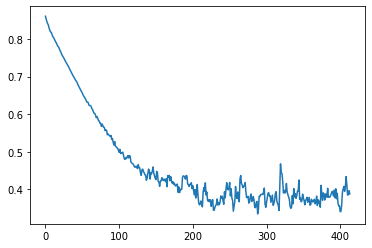

Epoch: 1, Loss: 0.3868:  22%|██████████████████▌                                                                 | 414/1875 [03:19<07:17,  3.34it/s]

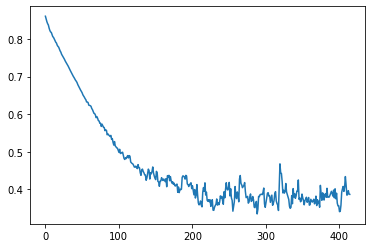

Epoch: 1, Loss: 0.3808:  22%|██████████████████▌                                                                 | 415/1875 [03:19<07:08,  3.40it/s]

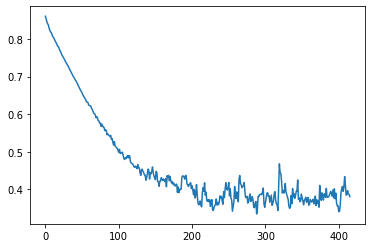

Epoch: 1, Loss: 0.3910:  22%|██████████████████▋                                                                 | 416/1875 [03:20<07:07,  3.42it/s]

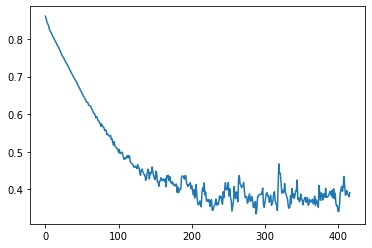

Epoch: 1, Loss: 0.3790:  22%|██████████████████▋                                                                 | 417/1875 [03:20<07:03,  3.45it/s]

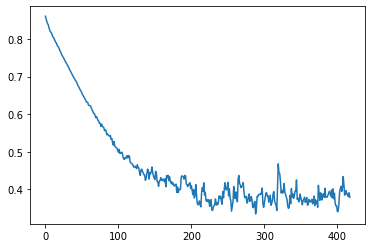

Epoch: 1, Loss: 0.3709:  22%|██████████████████▋                                                                 | 418/1875 [03:20<07:04,  3.43it/s]

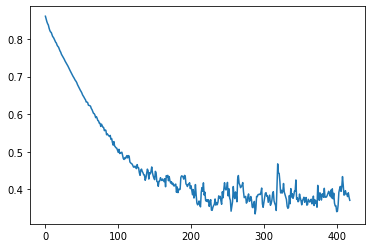

Epoch: 1, Loss: 0.3857:  22%|██████████████████▊                                                                 | 419/1875 [03:21<07:20,  3.31it/s]

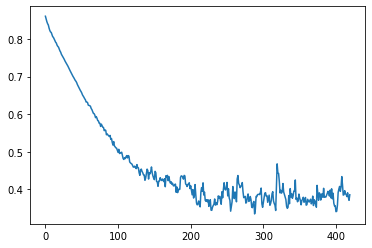

Epoch: 1, Loss: 0.3802:  22%|██████████████████▊                                                                 | 420/1875 [03:22<13:09,  1.84it/s]

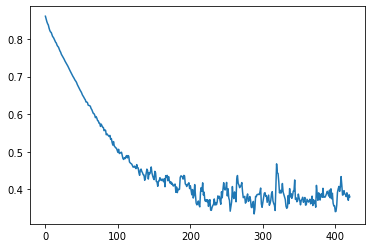

Epoch: 1, Loss: 0.3987:  22%|██████████████████▊                                                                 | 421/1875 [03:22<11:40,  2.07it/s]

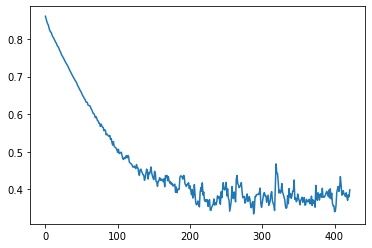

Epoch: 1, Loss: 0.4045:  23%|██████████████████▉                                                                 | 422/1875 [03:22<10:30,  2.30it/s]

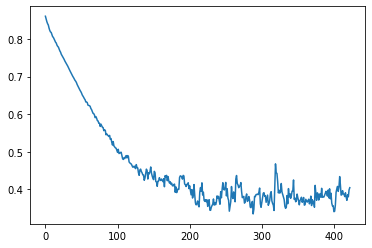

Epoch: 1, Loss: 0.4076:  23%|██████████████████▉                                                                 | 423/1875 [03:23<09:21,  2.59it/s]

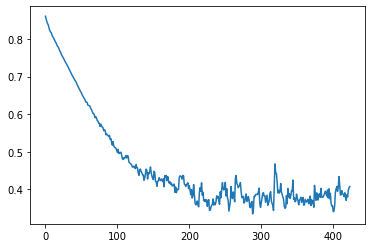

Epoch: 1, Loss: 0.4034:  23%|██████████████████▉                                                                 | 424/1875 [03:23<08:48,  2.74it/s]

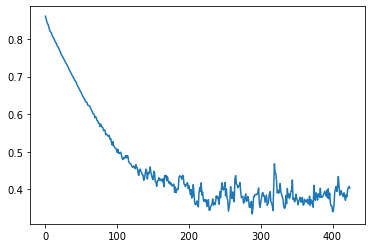

Epoch: 1, Loss: 0.3667:  23%|███████████████████                                                                 | 425/1875 [03:23<08:13,  2.94it/s]

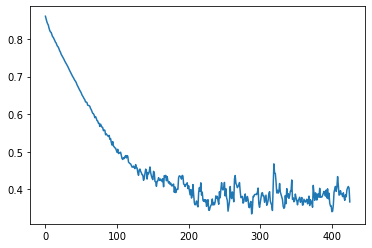

Epoch: 1, Loss: 0.3489:  23%|███████████████████                                                                 | 426/1875 [03:24<07:54,  3.05it/s]

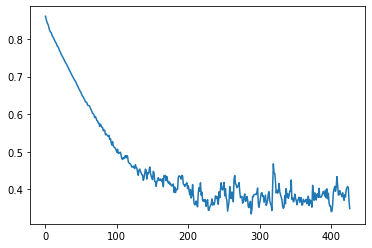

Epoch: 1, Loss: 0.3514:  23%|███████████████████▏                                                                | 427/1875 [03:24<07:41,  3.14it/s]

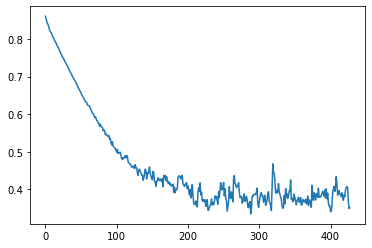

Epoch: 1, Loss: 0.3222:  23%|███████████████████▏                                                                | 428/1875 [03:24<07:51,  3.07it/s]

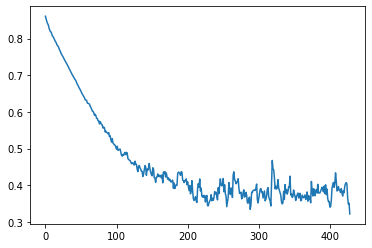

Epoch: 1, Loss: 0.3494:  23%|███████████████████▏                                                                | 429/1875 [03:24<07:44,  3.11it/s]

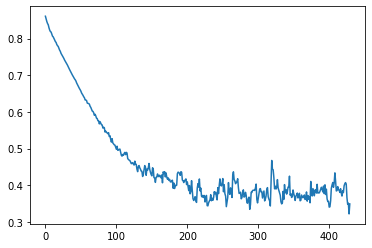

Epoch: 1, Loss: 0.3514:  23%|███████████████████▎                                                                | 430/1875 [03:25<07:30,  3.21it/s]

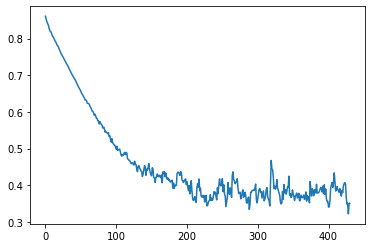

Epoch: 1, Loss: 0.3548:  23%|███████████████████▎                                                                | 431/1875 [03:25<07:22,  3.27it/s]

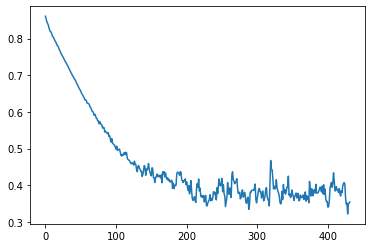

Epoch: 1, Loss: 0.3639:  23%|███████████████████▎                                                                | 432/1875 [03:26<07:52,  3.05it/s]

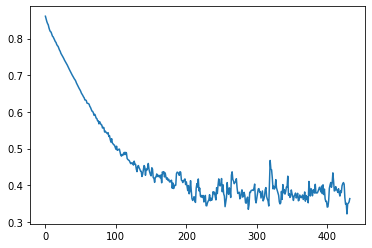

Epoch: 1, Loss: 0.3723:  23%|███████████████████▍                                                                | 433/1875 [03:27<14:14,  1.69it/s]

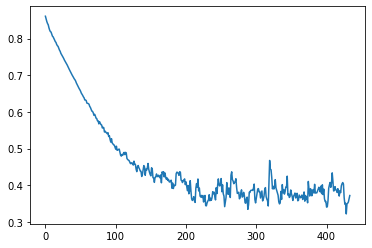

Epoch: 1, Loss: 0.3657:  23%|███████████████████▍                                                                | 434/1875 [03:28<16:44,  1.44it/s]

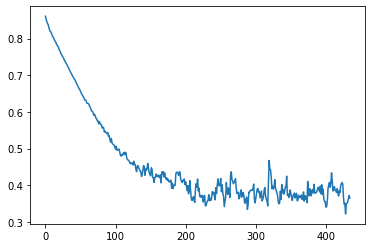

Epoch: 1, Loss: 0.3706:  23%|███████████████████▍                                                                | 435/1875 [03:28<15:03,  1.59it/s]

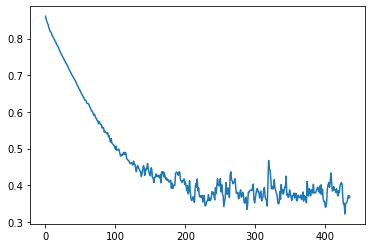

Epoch: 1, Loss: 0.3562:  23%|███████████████████▌                                                                | 436/1875 [03:28<12:55,  1.86it/s]

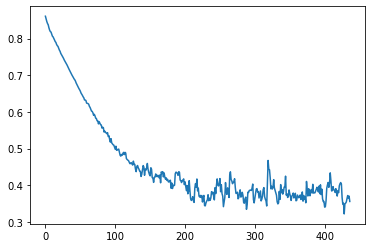

Epoch: 1, Loss: 0.3500:  23%|███████████████████▌                                                                | 437/1875 [03:29<11:14,  2.13it/s]

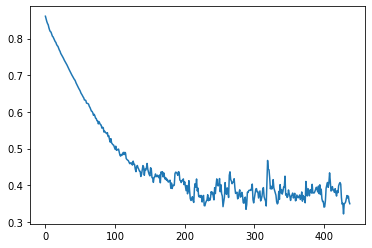

Epoch: 1, Loss: 0.3924:  23%|███████████████████▌                                                                | 438/1875 [03:29<10:09,  2.36it/s]

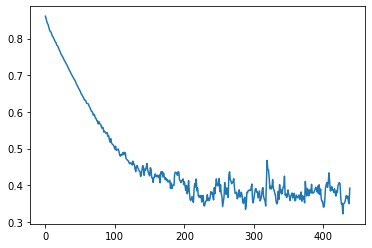

Epoch: 1, Loss: 0.4113:  23%|███████████████████▋                                                                | 439/1875 [03:30<11:18,  2.12it/s]

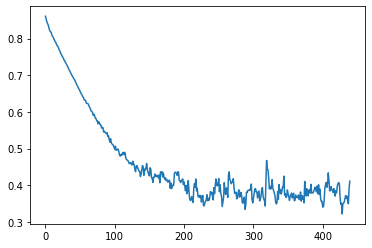

Epoch: 1, Loss: 0.4165:  23%|███████████████████▋                                                                | 440/1875 [03:30<10:04,  2.37it/s]

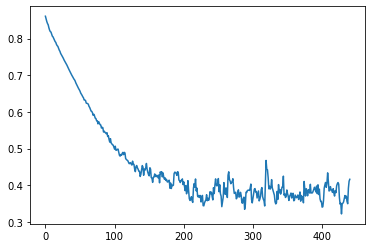

Epoch: 1, Loss: 0.3800:  24%|███████████████████▊                                                                | 441/1875 [03:30<09:53,  2.42it/s]

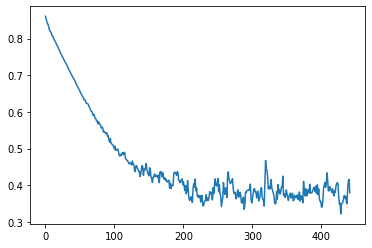

Epoch: 1, Loss: 0.4128:  24%|███████████████████▊                                                                | 442/1875 [03:31<09:12,  2.59it/s]

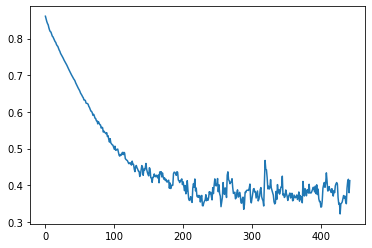

Epoch: 1, Loss: 0.4007:  24%|███████████████████▊                                                                | 443/1875 [03:31<08:34,  2.78it/s]

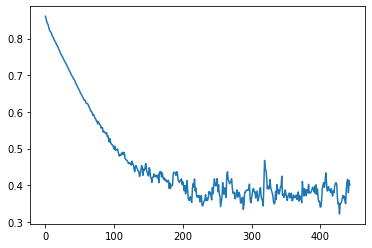

Epoch: 1, Loss: 0.3940:  24%|███████████████████▉                                                                | 444/1875 [03:31<08:05,  2.95it/s]

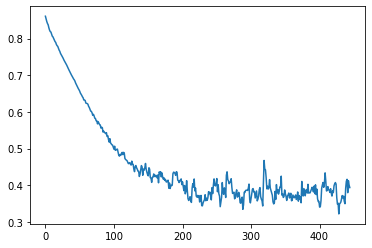

Epoch: 1, Loss: 0.3902:  24%|███████████████████▉                                                                | 445/1875 [03:32<07:46,  3.06it/s]

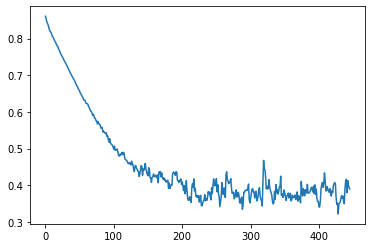

Epoch: 1, Loss: 0.3850:  24%|███████████████████▉                                                                | 446/1875 [03:32<08:09,  2.92it/s]

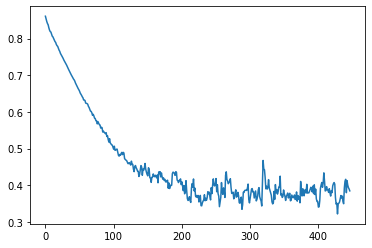

Epoch: 1, Loss: 0.3972:  24%|████████████████████                                                                | 447/1875 [03:32<07:56,  2.99it/s]

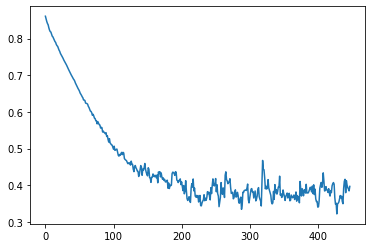

Epoch: 1, Loss: 0.3774:  24%|████████████████████                                                                | 448/1875 [03:33<08:02,  2.96it/s]

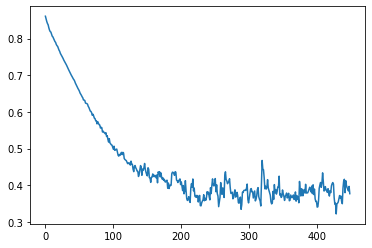

Epoch: 1, Loss: 0.3829:  24%|████████████████████                                                                | 449/1875 [03:33<08:07,  2.92it/s]

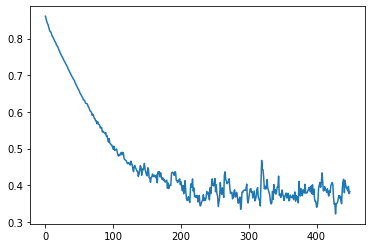

Epoch: 1, Loss: 0.3727:  24%|████████████████████▏                                                               | 450/1875 [03:33<07:45,  3.06it/s]

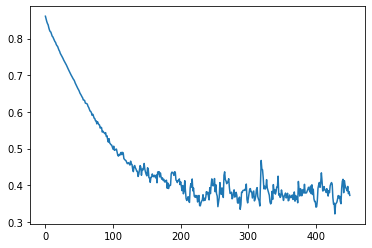

Epoch: 1, Loss: 0.3537:  24%|████████████████████▏                                                               | 451/1875 [03:33<07:30,  3.16it/s]

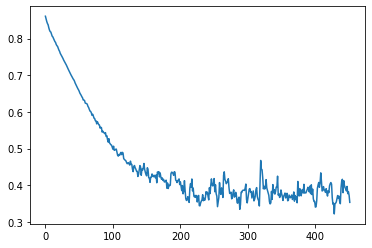

Epoch: 1, Loss: 0.3714:  24%|████████████████████▏                                                               | 452/1875 [03:34<07:18,  3.24it/s]

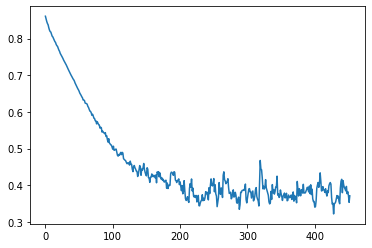

Epoch: 1, Loss: 0.3352:  24%|████████████████████▎                                                               | 453/1875 [03:34<07:50,  3.02it/s]

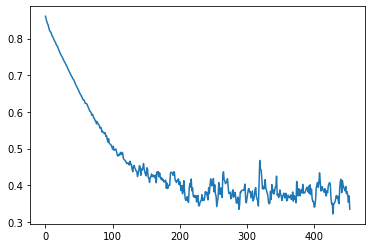

Epoch: 1, Loss: 0.3507:  24%|████████████████████▎                                                               | 454/1875 [03:34<07:41,  3.08it/s]

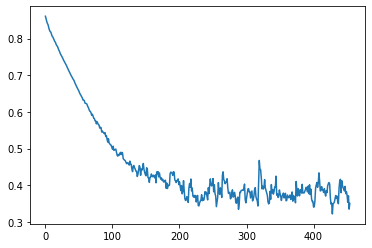

Epoch: 1, Loss: 0.3455:  24%|████████████████████▍                                                               | 455/1875 [03:35<08:03,  2.94it/s]

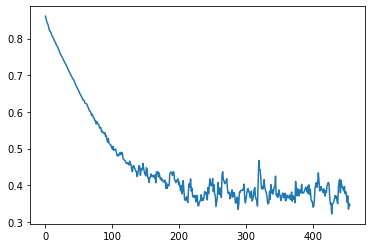

Epoch: 1, Loss: 0.3555:  24%|████████████████████▍                                                               | 456/1875 [03:35<07:48,  3.03it/s]

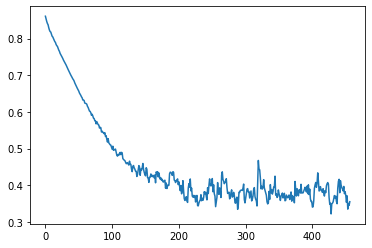

Epoch: 1, Loss: 0.3646:  24%|████████████████████▍                                                               | 457/1875 [03:35<07:32,  3.13it/s]

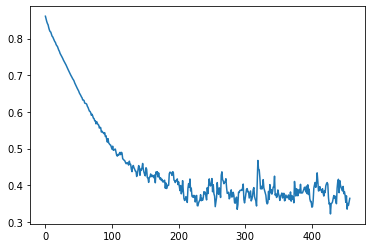

Epoch: 1, Loss: 0.3624:  24%|████████████████████▌                                                               | 458/1875 [03:36<07:30,  3.15it/s]

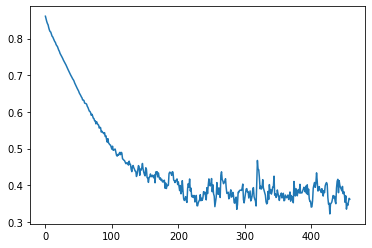

Epoch: 1, Loss: 0.3935:  24%|████████████████████▌                                                               | 459/1875 [03:36<07:19,  3.22it/s]

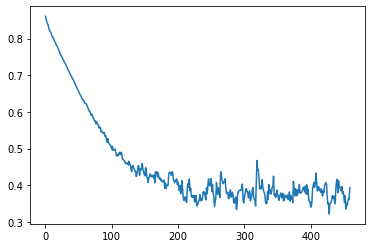

Epoch: 1, Loss: 0.3712:  25%|████████████████████▌                                                               | 460/1875 [03:36<07:17,  3.24it/s]

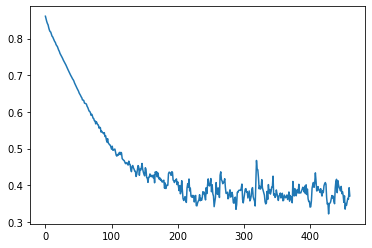

Epoch: 1, Loss: 0.3515:  25%|████████████████████▋                                                               | 461/1875 [03:37<07:16,  3.24it/s]

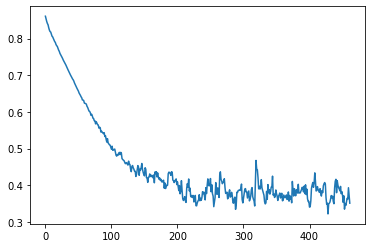

Epoch: 1, Loss: 0.3544:  25%|████████████████████▋                                                               | 462/1875 [03:37<10:06,  2.33it/s]

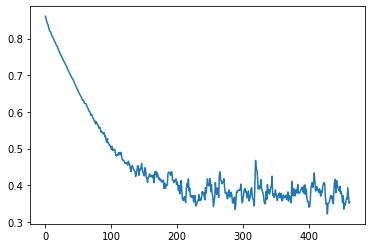

Epoch: 1, Loss: 0.3778:  25%|████████████████████▋                                                               | 463/1875 [03:38<09:41,  2.43it/s]

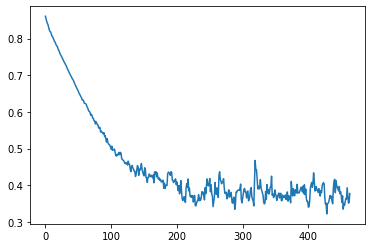

Epoch: 1, Loss: 0.3628:  25%|████████████████████▊                                                               | 464/1875 [03:38<09:13,  2.55it/s]

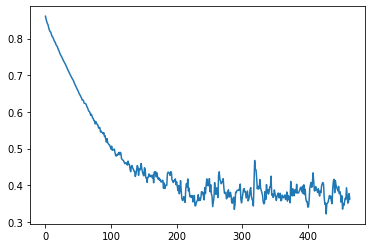

Epoch: 1, Loss: 0.3626:  25%|████████████████████▊                                                               | 465/1875 [03:38<08:35,  2.73it/s]

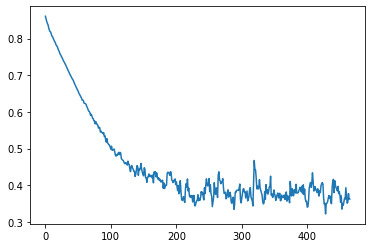

Epoch: 1, Loss: 0.3636:  25%|████████████████████▉                                                               | 466/1875 [03:39<08:05,  2.90it/s]

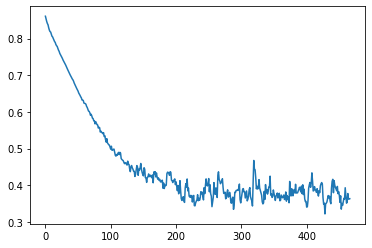

Epoch: 1, Loss: 0.3597:  25%|████████████████████▉                                                               | 467/1875 [03:39<07:50,  2.99it/s]

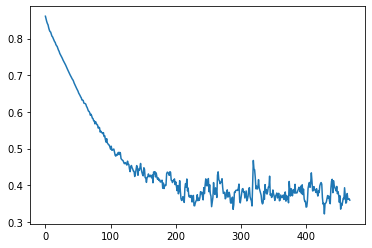

Epoch: 1, Loss: 0.3393:  25%|████████████████████▉                                                               | 468/1875 [03:39<07:33,  3.10it/s]

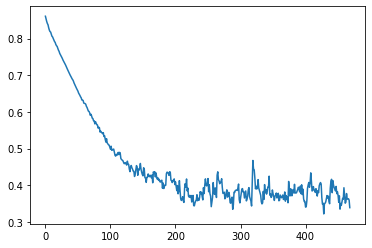

Epoch: 1, Loss: 0.3491:  25%|█████████████████████                                                               | 469/1875 [03:40<07:29,  3.13it/s]

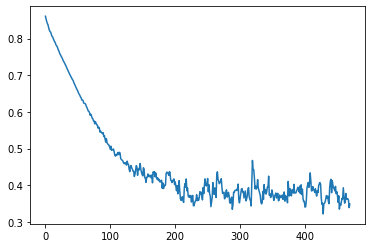

Epoch: 1, Loss: 0.3680:  25%|█████████████████████                                                               | 470/1875 [03:40<07:18,  3.21it/s]

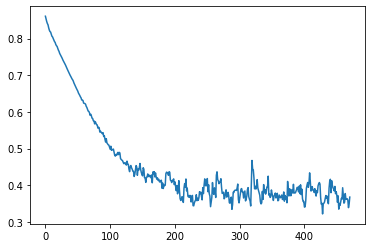

Epoch: 1, Loss: 0.3663:  25%|█████████████████████                                                               | 471/1875 [03:40<08:01,  2.92it/s]

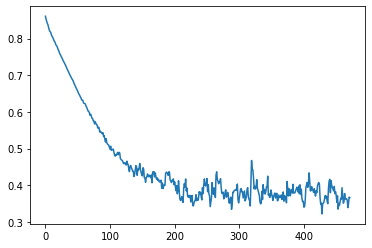

Epoch: 1, Loss: 0.3606:  25%|█████████████████████▏                                                              | 472/1875 [03:41<08:22,  2.79it/s]

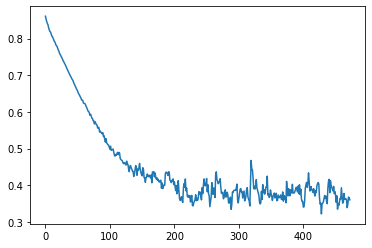

Epoch: 1, Loss: 0.3445:  25%|█████████████████████▏                                                              | 473/1875 [03:41<08:01,  2.91it/s]

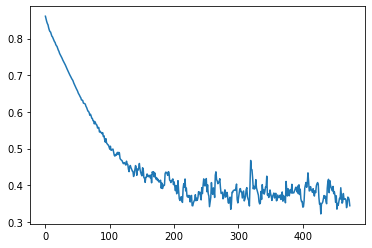

Epoch: 1, Loss: 0.3280:  25%|█████████████████████▏                                                              | 474/1875 [03:41<08:29,  2.75it/s]

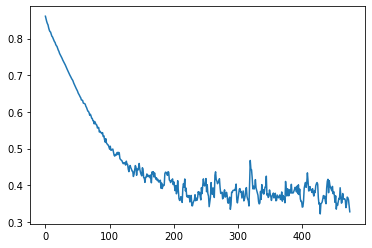

Epoch: 1, Loss: 0.3601:  25%|█████████████████████▎                                                              | 475/1875 [03:42<08:05,  2.88it/s]

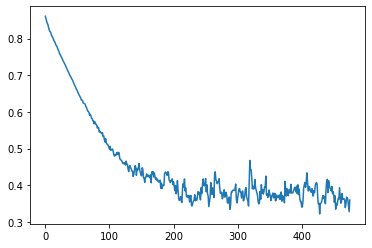

Epoch: 1, Loss: 0.3628:  25%|█████████████████████▎                                                              | 476/1875 [03:43<10:21,  2.25it/s]

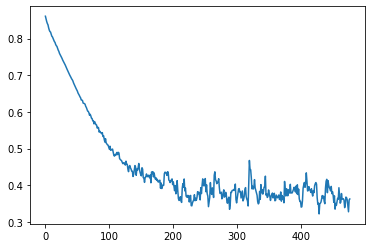

Epoch: 1, Loss: 0.3451:  25%|█████████████████████▎                                                              | 477/1875 [03:44<13:52,  1.68it/s]

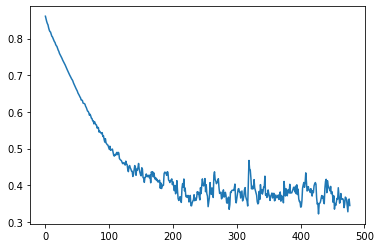

Epoch: 1, Loss: 0.3482:  25%|█████████████████████▍                                                              | 478/1875 [03:44<13:55,  1.67it/s]

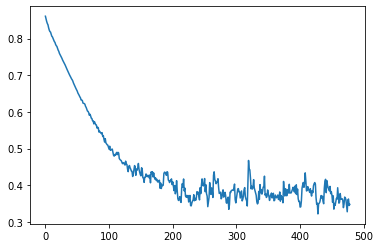

Epoch: 1, Loss: 0.3460:  26%|█████████████████████▍                                                              | 479/1875 [03:45<13:06,  1.78it/s]

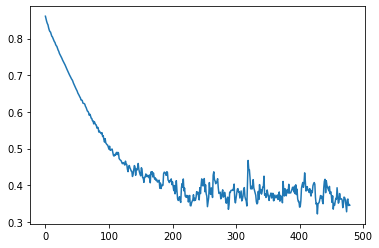

Epoch: 1, Loss: 0.3440:  26%|█████████████████████▌                                                              | 480/1875 [03:45<12:34,  1.85it/s]

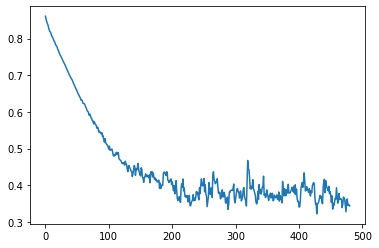

Epoch: 1, Loss: 0.3422:  26%|█████████████████████▌                                                              | 481/1875 [03:46<12:23,  1.88it/s]

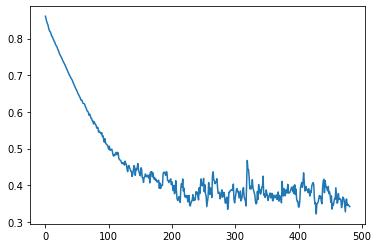

Epoch: 1, Loss: 0.3286:  26%|█████████████████████▌                                                              | 482/1875 [03:46<12:19,  1.88it/s]

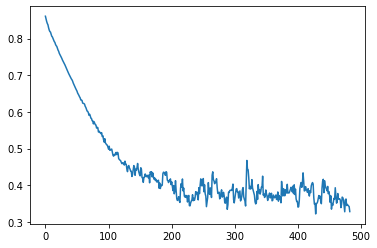

Epoch: 1, Loss: 0.3621:  26%|█████████████████████▋                                                              | 483/1875 [03:47<11:51,  1.96it/s]

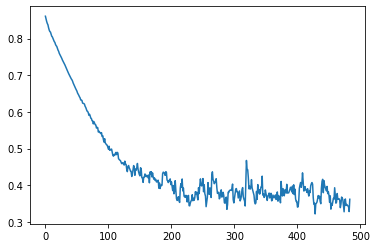

Epoch: 1, Loss: 0.3701:  26%|█████████████████████▋                                                              | 484/1875 [03:47<11:38,  1.99it/s]

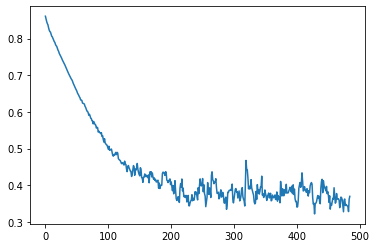

Epoch: 1, Loss: 0.3480:  26%|█████████████████████▋                                                              | 485/1875 [03:48<11:57,  1.94it/s]

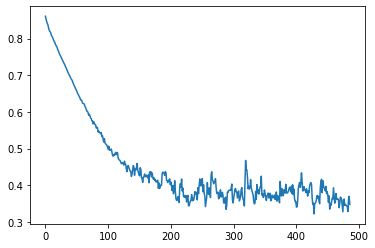

Epoch: 1, Loss: 0.3516:  26%|█████████████████████▊                                                              | 486/1875 [03:48<14:03,  1.65it/s]

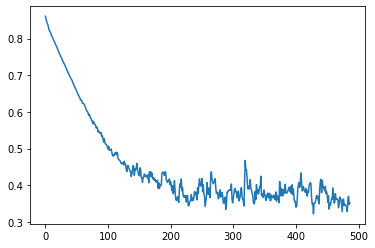

Epoch: 1, Loss: 0.3580:  26%|█████████████████████▊                                                              | 487/1875 [03:49<13:07,  1.76it/s]

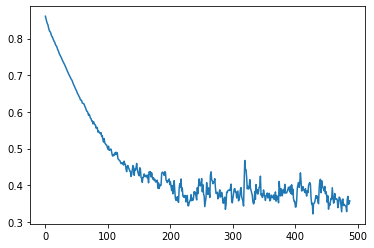

Epoch: 1, Loss: 0.3594:  26%|█████████████████████▊                                                              | 488/1875 [03:50<12:59,  1.78it/s]

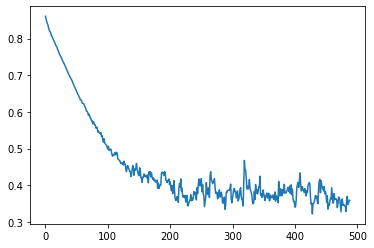

Epoch: 1, Loss: 0.3649:  26%|█████████████████████▉                                                              | 489/1875 [03:50<13:38,  1.69it/s]

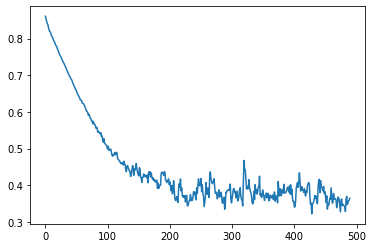

Epoch: 1, Loss: 0.3588:  26%|█████████████████████▉                                                              | 490/1875 [03:51<13:48,  1.67it/s]

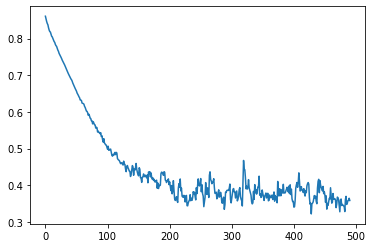

Epoch: 1, Loss: 0.3593:  26%|█████████████████████▉                                                              | 491/1875 [03:51<12:17,  1.88it/s]

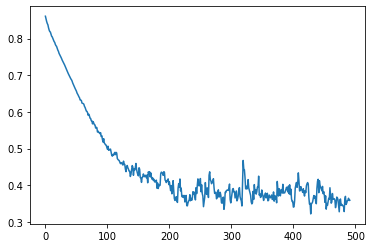

Epoch: 1, Loss: 0.3642:  26%|██████████████████████                                                              | 492/1875 [03:52<11:41,  1.97it/s]

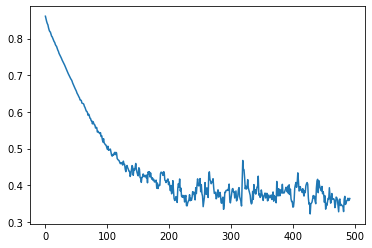

Epoch: 1, Loss: 0.3593:  26%|██████████████████████                                                              | 493/1875 [03:52<12:22,  1.86it/s]

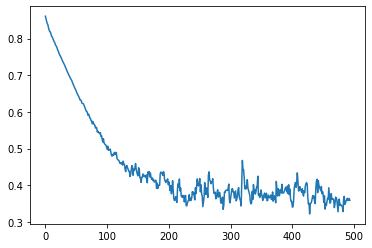

Epoch: 1, Loss: 0.3550:  26%|██████████████████████▏                                                             | 494/1875 [03:52<11:02,  2.08it/s]

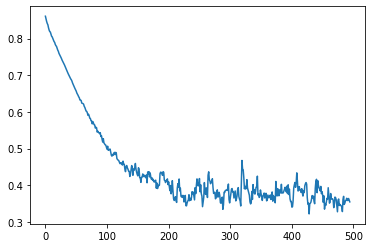

Epoch: 1, Loss: 0.3472:  26%|██████████████████████▏                                                             | 495/1875 [03:53<09:55,  2.32it/s]

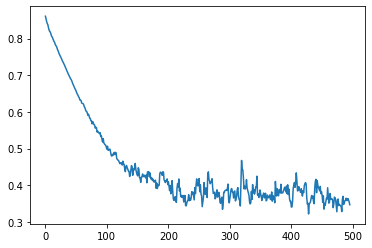

Epoch: 1, Loss: 0.3758:  26%|██████████████████████▏                                                             | 496/1875 [03:54<12:45,  1.80it/s]

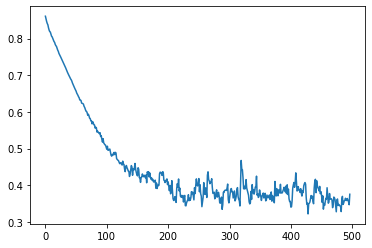

Epoch: 1, Loss: 0.3790:  27%|██████████████████████▎                                                             | 497/1875 [03:55<14:24,  1.59it/s]

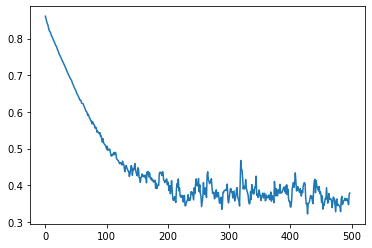

Epoch: 1, Loss: 0.3559:  27%|██████████████████████▎                                                             | 498/1875 [03:55<13:42,  1.67it/s]

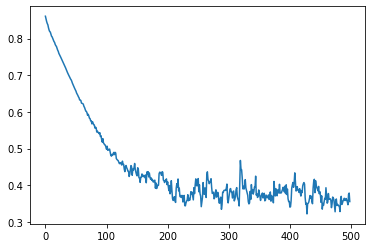

Epoch: 1, Loss: 0.3578:  27%|██████████████████████▎                                                             | 499/1875 [03:56<13:15,  1.73it/s]

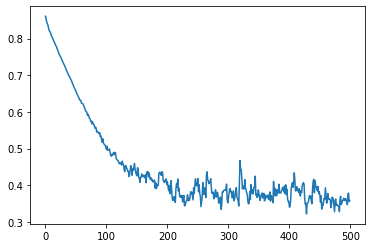

Epoch: 1, Loss: 0.3691:  27%|██████████████████████▍                                                             | 500/1875 [03:56<13:19,  1.72it/s]

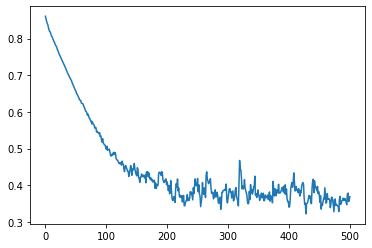

Epoch: 1, Loss: 0.3774:  27%|██████████████████████▍                                                             | 501/1875 [03:57<12:31,  1.83it/s]

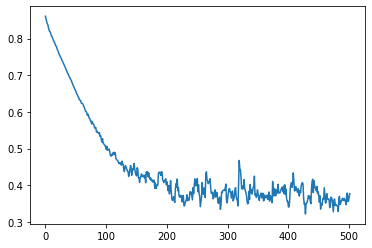

Epoch: 1, Loss: 0.3824:  27%|██████████████████████▍                                                             | 502/1875 [03:57<11:46,  1.94it/s]

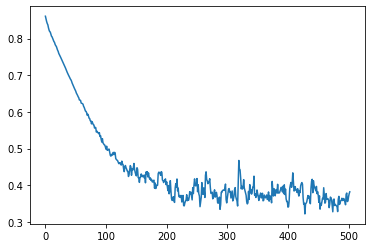

Epoch: 1, Loss: 0.3824:  27%|██████████████████████▌                                                             | 503/1875 [03:58<10:51,  2.11it/s]


KeyboardInterrupt: 

In [702]:
num_epochs = 10
optimizer = SGD(model.parameters(), lr=1e-2)
criterion = nn.BCELoss()
loss_history = []

for epoch in range(num_epochs):
    tqdm_train_data = tqdm(train_data)
    for images, _ in tqdm_train_data:
        optimizer.zero_grad()
        pred_images, _ = model(images)
        loss = criterion(pred_images, images)
        
        loss.backward()
        loss_history.append(loss.item())
        
        tqdm_train_data.set_description("Epoch: {}, Loss: {:.4f}".format(epoch + 1, loss.item()))
        optimizer.step()
        
        plt.plot(loss_history)
        plt.show()
        